In [51]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pickle
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from copy import deepcopy 

from IPython import display

import matplotlib as mpl
import matplotlib.pyplot as plt

#import time
np.set_printoptions(precision=3, suppress=True)

In [52]:
#COLUMN_NAMES = ["dim1", "dim2", "dim3", "dim4", 
#                "dim5", "dim6", "dim7", "dim8", 
#                "dim9", "dim10", "label"]
#LABEL_NAME = "label"
#INPUT_NAMES = list(COLUMN_NAMES)
#INPUT_NAMES.remove(LABEL_NAME)

# loading the trafectories from pickle files
###trajectory_list = pickle.load(open("../5_N-Dim_Doublewell-generator/trajectory_list.p", "rb"))
###trajectory_label_list = pickle.load(open("../3_N-Dim_Doublewell-generator/trajectory_label_list.p", "rb"))
trajectory_list = pickle.load(open("../5_ZPotential_Autoencoder/trajectory_list.p", "rb"))
trajectory_label_list = pickle.load(open("../5_ZPotential_Autoencoder/trajectory_label_list.p", "rb"))

In [53]:
"""System parameters"""
# number of cores used
CORES_USED = 3

In [54]:
"""Dataset parameters"""
# set size of batches
BATCH_SIZE = 64
# determines whether the last n values are going to be dropped if no complete batch can be build from them
DROP_REMAINDER = False
# ratio of test set compared to the whole dataset
SPLIT_RATIO = 0.7
# number of dimensions in the data
DIMENSIONS = 10
# offset to generate datasets with future predictions. If = 0, the input and reconstruction snapshots are identical
OFFSET = 0

In [55]:
"""Model parametes"""
# number of bottleneck nodes
BOTTLENECK_SIZE = 2
# weight of the label loss and reconstruction loss. Only the relative ratio is relevant
LABEL_LOSS_WEIGHT = 1.0
RECONSTRUCTION_LOSS_WEIGHT = 1.0
# name of names of input and output in the model
INPUT_NAME = "input_snapshots"
OUTPUT_NAME_1 = "label"
OUTPUT_NAME_2 = "reconstruction"
# list off losses determined by the model. Utilized by the plot_all_input_importance function
LOSS_NAMES = ["total", OUTPUT_NAME_1, OUTPUT_NAME_2]
LOSS_TYPE_COUNT = len(LOSS_NAMES)
# number of epochs used for model training
EPOCHS = 3

In [56]:
"""Label map parameters"""
# resolution for the make_label_map_figure function
RESOLUTION = 21
# figure size for the figures generated by the make_label_map_figure function
FIG_SIZE = 50
# fraction of most extreme values that are considered outliers to both sides
"""so far only in use in the mapping function"""
OUTLIER_CUTOFF = 0.1

In [57]:
"""Input importance parameters"""
# sets thresholds for the strengt of correlation needed to be considered "correlated"
WEAK_CORRELATION_TRESHOLD = 0.01
STRONG_CORRELATION_TRESHOLD = 0.1

In [58]:
# additional section can be used for generation of present/future pairs
def generate_offset_snapshot_list(trajectory_list, offset):
    # Takes in a list or np.array of trajectories and an offset value and generates two np.arrays with respective new versions
    # of the trajectories. 
    # present_trajectory_list contains all snapshots of the trajectories excluding
    # the last n (speficified by offset) of each.
    # future_trajectory_list contains all snapshots of the trajectories excluding
    # the first n (specified by offset) of each.
    # Consequently the both lists can be used as input and desired output of an autoencoder to
    # train for future predictive variables.
    present_trajectory_list = np.array([trajectory[:-offset] for trajectory in trajectory_list])  
    #truncated_present_trajectory_list = 
    future_trajectory_list = np.array([trajectory[offset:] for trajectory in trajectory_list])
    return present_trajectory_list, future_trajectory_list

def get_snapshot_and_label_list(trajectory_list, trajectory_label_list, offset = 0, future = False, progress_label = False):
    # takes in a list of trajectories and corresponding labels and generates concatenated lists of snapshots, 
    # snapshot label and snapshot progress labels
    # can be used for present/future trajcetory lists by use or offset (same as used for generation of the list)
    # and future = True for the future trajectory list
    snapshot_list = []
    snapshot_label_list = []
    for trajectory_nr in range(len(trajectory_list)):
        trajectory = trajectory_list[trajectory_nr]
        trajectory_label = trajectory_label_list[trajectory_nr]
        for snapshot_nr in range(len(trajectory)):
            snapshot_list.append(trajectory[snapshot_nr])
            if progress_label == False:
                snapshot_label_list.append(trajectory_label)
            else:
                # Calculates the progress along the path for AB paths. If the path label is 1 or 0,
                # all snapshot are assigned the same label. If the path label is different (e.g. 0.5),
                # indicating a sucessfull transition a progress along the snapshots is calculated based on
                # the position within the trajectory and the total trajectory length.
                # For present/future lists, the offset needs to be taken into account in the denominator
                # If the dataset is a future variant of an offset trajectory list the progress label 
                # needs to additionally take the offset into account in the nominator.
                if trajectory_label == 0.0 or trajectory_label == 1.0:
                    snapshot_label_list.append(trajectory_label)
                else:
                    if future == True:
                        snapshot_label_list.append((snapshot_nr + offset)/(len(trajectory) - 1.0 + offset))
                    else:
                        snapshot_label_list.append(snapshot_nr/(len(trajectory)-1.0 + offset))
    return np.array(snapshot_list), np.array(snapshot_label_list)

def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))


In [59]:
def shuffled_train_test_split(trajectory_list, trajectory_label_list, split_ratio, offset = 0, progress_label = False):
    assert isinstance(split_ratio, float), "Split ratio needs to be a of type float"
    if offset == 0 or offset == None:
        snapshot_list, snapshot_label_list = get_snapshot_and_label_list(trajectory_list, \
                trajectory_label_list, progress_label = progress_label)
        snapshot_list, snapshot_label_list = shuffle(snapshot_list, snapshot_label_list)
        train_size = int(len(snapshot_label_list) * split_ratio)
        train_snapshot_list = snapshot_list[:train_size].copy()
        test_snapshot_list = snapshot_list[train_size:].copy()
        train_snapshot_label_list = snapshot_label_list[:train_size].copy()
        test_snapshot_label_list = snapshot_label_list[train_size:].copy()
        # Calculate mean and std of the test snapshots and use them to normalize the snapshot_lists
        train_mean = np.mean(train_snapshot_list, axis = 0)
        train_std = np.std(train_snapshot_list, axis = 0)
        train_snapshot_list = (train_snapshot_list - train_mean)/train_std
        test_snapshot_list = (test_snapshot_list - train_mean)/train_std
        
        return train_snapshot_list, train_snapshot_label_list, test_snapshot_list, test_snapshot_label_list
    else:
        present_trajectory_list, future_trajectory_list = generate_offset_snapshot_list(trajectory_list, offset)
        present_snapshot_list, _ = get_snapshot_and_label_list(
                present_trajectory_list, trajectory_label_list, offset)
        future_snapshot_list, future_snapshot_label_list = get_snapshot_and_label_list(
                future_trajectory_list, trajectory_label_list, offset, future = True, \
                progress_label = progress_label)
        present_snapshot_list, future_snapshot_list, future_snapshot_label_list = shuffle(
                present_snapshot_list, future_snapshot_list, future_snapshot_label_list)
        train_size = int(len(future_snapshot_label_list) * split_ratio)
        
        train_present_snapshot_list = present_snapshot_list[:train_size].copy()
        test_present_snapshot_list = present_snapshot_list[train_size:].copy()
        train_future_snapshot_list = future_snapshot_list[:train_size].copy()
        test_future_snapshot_list = future_snapshot_list[train_size:].copy()
        train_future_snapshot_label_list = future_snapshot_label_list[:train_size].copy()
        test_future_snapshot_label_list = future_snapshot_label_list[train_size:].copy()
        # Calculate mean and std of the test snapshots and use them to normalize the snapshot_lists
        train_mean = np.mean(train_present_snapshot_list, axis = 0)
        train_std = np.std(train__present_snapshot_list, axis = 0)
        train_present_snapshot_list = (train_present_snapshot_list - train_mean)/train_std
        test_present_snapshot_list = (test_present_snapshot_list - train_mean)/train_std
        train_future_snapshot_list = (train_future_snapshot_list - train_mean)/train_std
        test_future_snapshot_list = (test_future_snapshot_list - train_mean)/train_std
        
        return train_present_snapshot_list, train_future_snapshot_list, \
                train_future_snapshot_label_list, test_present_snapshot_list, \
                test_future_snapshot_list, test_future_snapshot_label_list

def generate_ds(trajectory_list, trajectory_label_list, split_ratio, offset = 0, progress_label = False):
    if offset == 0 or offset == None:
        train_snapshot_list, train_snapshot_label_list, \
                test_snapshot_list, test_snapshot_label_list = shuffled_train_test_split(
                        trajectory_list, trajectory_label_list, split_ratio, offset = 0, progress_label = False)
        dataset_size = len(train_snapshot_list) + len(test_snapshot_list)
        # generates the dataset by feeding in a tuple, of dictionaries (alternative would be a tuble of lists)
        train_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME: train_snapshot_list},
                {OUTPUT_NAME_1: train_snapshot_label_list, 
                OUTPUT_NAME_2: train_snapshot_list})).shuffle(dataset_size)
        test_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME: test_snapshot_list},
                {OUTPUT_NAME_1: test_snapshot_label_list, 
                OUTPUT_NAME_2: test_snapshot_list})).shuffle(dataset_size)
        step_number = int(len(test_snapshot_list)/BATCH_SIZE)
        
        return train_ds, test_ds, train_snapshot_list, \
                [], train_snapshot_label_list, test_snapshot_list, \
                [], test_snapshot_label_list
    else:
        train_snapshot_list, train_future_snapshot_list, train_future_snapshot_label_list, \
                test_snapshot_list, test_future_snapshot_list, test_future_snapshot_label_list = shuffled_train_test_split(
                        trajectory_list, trajectory_label_list, split_ratio, offset = offset, \
                        progress_label = False)
        dataset_size = len(train_snapshot_list) + len(test_snapshot_list)
        # generates the dataset by feeding in a tuple, of dictionaries (alternative would be a tuble of lists)
        train_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME: train_snapshot_list},
                {OUTPUT_NAME_1: train_future_snapshot_label_list, 
                OUTPUT_NAME_2: train_future_snapshot_list})).shuffle(dataset_size)
        test_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME: test_snapshot_list},
                {OUTPUT_NAME_1: test_future_snapshot_label_list, 
                OUTPUT_NAME_2: test_future_snapshot_list})).shuffle(dataset_size)
    
        return train_ds, test_ds, train_snapshot_list, \
                train_future_snapshot_list, train_future_snapshot_label_list, test_snapshot_list, \
                test_future_snapshot_list, test_future_snapshot_label_list
                
train_ds, test_ds, train_snapshot_list, train_future_snapshot_list, \
        train_snapshot_label_list, test_snapshot_list, test_future_snapshot_list, \
        test_snapshot_label_list = generate_ds(trajectory_list, \
                trajectory_label_list, SPLIT_RATIO, OFFSET, progress_label = False)

lower_bound = np.percentile(train_snapshot_list, 100*OUTLIER_CUTOFF, axis = 0)
upper_bound = np.percentile(train_snapshot_list, 100*(1-OUTLIER_CUTOFF), axis = 0)

train_ds_batch = train_ds.batch(BATCH_SIZE, drop_remainder=DROP_REMAINDER)
test_ds_batch = test_ds.batch(BATCH_SIZE, drop_remainder=DROP_REMAINDER)

In [60]:
STEP_NUMBER = int(len(test_snapshot_list)/BATCH_SIZE)
TEST_SIZE = len(test_snapshot_list)
DATASET_SIZE = TEST_SIZE + len(train_snapshot_list)
# if remainder is dopped during batching, the TEST_SIZE is reduced by the size of the last incomplete batch
if DROP_REMAINDER == True:
    TEST_SIZE = TEST_SIZE - (TEST_SIZE % BATCH_SIZE)

In [61]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

#weight_for_0 = (1 / neg)*(total)/2.0 
#weight_for_1 = (1 / pos)*(total)/2.0

#class_weight = {0: weight_for_0, 1: weight_for_1}
#print('Weight for class 0: {:.2f}'.format(weight_for_0))
#print('Weight for class 1: {:.2f}'.format(weight_for_1))


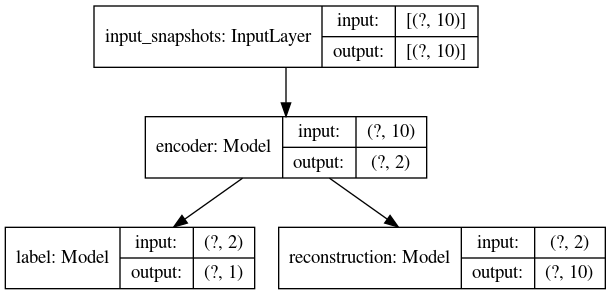

In [62]:
encoder_input = keras.Input(shape=(DIMENSIONS,),name=INPUT_NAME)
x = keras.layers.Dense(DIMENSIONS, activation= 'tanh')(encoder_input)
x = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(x)
x = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(x)
encoder_output = keras.layers.Dense(BOTTLENECK_SIZE, activation='tanh', name='bottleneck')(x)

encoder = keras.Model(encoder_input, encoder_output, name ="encoder")
#encoder.summary()

decoder_input = keras.Input(shape=(BOTTLENECK_SIZE,), name ="encoded_snapshots")

x1 = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(decoder_input)
x1 = keras.layers.Dense(DIMENSIONS, activation='tanh')(x1)
decoder_output_1 = keras.layers.Dense(1, activation='tanh',name=OUTPUT_NAME_1)(x1)
decoder_1 = keras.Model(decoder_input, decoder_output_1, name=OUTPUT_NAME_1)
#decoder_1.summary()

x2 = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(decoder_input)
x2 = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(x2)
decoder_output_2 = keras.layers.Dense(DIMENSIONS, activation='tanh',name=OUTPUT_NAME_2)(x2)
decoder_2 = keras.Model(decoder_input, decoder_output_2, name=OUTPUT_NAME_2)
#decoder_2.summary()

autoencoder_input = keras.Input(shape=(DIMENSIONS,), name=INPUT_NAME)
encoded_snaphot = encoder(autoencoder_input)
label_snapshot = decoder_1(encoded_snaphot)
reconstructed_snapshot = decoder_2(encoded_snaphot)
autoencoder = keras.Model(inputs=autoencoder_input, outputs=[label_snapshot,reconstructed_snapshot])

model_layout = keras.utils.plot_model(autoencoder, 'multi_input_and_output_model.png', show_shapes=True)
display.display(model_layout)
#display.display(keras.utils.plot_model(encoder, 'encoder.png', show_shapes=True))
#display.display(keras.utils.plot_model(decoder_1, 'decoder_1.png', show_shapes=True))
#display.display(keras.utils.plot_model(decoder_2, 'decoder_2.png', show_shapes=True))


In [63]:
autoencoder.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={OUTPUT_NAME_1:keras.losses.MeanAbsoluteError(),
                      OUTPUT_NAME_2: keras.losses.MeanAbsoluteError()},
              loss_weights=[LABEL_LOSS_WEIGHT, RECONSTRUCTION_LOSS_WEIGHT])

autoencoder_1 = keras.Model(inputs=autoencoder_input, outputs=label_snapshot)
autoencoder_1.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={OUTPUT_NAME_1:keras.losses.MeanAbsoluteError()})

autoencoder_2 = keras.Model(inputs=autoencoder_input, outputs=reconstructed_snapshot)
autoencoder_2.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={OUTPUT_NAME_2:keras.losses.MeanAbsoluteError()})

In [67]:
#autoencoder.fit(train_ds_batch,epochs=EPOCHS, class_weight=class_weight)
autoencoder.fit(train_ds_batch,epochs=EPOCHS)


Train for 10460 steps
Epoch 1/3
10460/10460 [==============================] - 36s 3ms/step - loss: 0.7362 - label_loss: 0.0472 - reconstruction_loss: 0.6890
Epoch 2/3
10460/10460 [==============================] - 34s 3ms/step - loss: 0.7115 - label_loss: 0.0410 - reconstruction_loss: 0.6706
Epoch 3/3
10460/10460 [==============================] - 36s 3ms/step - loss: 0.7007 - label_loss: 0.0386 - reconstruction_loss: 0.6621


In [68]:
autoencoder.evaluate(test_ds_batch, verbose=1, steps = STEP_NUMBER)

4482/4482 [==============================] - 8s 2ms/step - loss: 0.6978 - label_loss: 0.0358 - reconstruction_loss: 0.6620


[0.6978353624203438, 0.035813782, 0.66202223]

In [69]:
def map_given_labels(snapshot_list, snapshot_label_list, x_list, y_list, x_var_pos, y_var_pos):
    x_nr = len(x_list)
    y_nr = len(y_list)
    min_x = min(x_list)
    max_x = max(x_list)
    min_y = min(y_list)
    max_y = max(y_list)
    x_span = max_x - min_x
    y_span = max_y - min_y

    # generate a list of lists of lists to store all labels in
    label_map = [[[] for y in y_list] for x in x_list]
    # sort the labels of each snapshot to the corresponding "positions" in the grid (by sorting them in the list)
    for snapshot_nr in range(len(snapshot_list)):
        x_snap = snapshot_list[snapshot_nr][x_var_pos]
        y_snap = snapshot_list[snapshot_nr][y_var_pos]
        # utilizes "int" to be able to use for iteration, "round" to round to closest full number, 
        # "i-min_x" to offset to start at 0, ""/x_span*(x-nr-1)"" to rescale
        x_int = int(round((x_snap - min_x)/x_span*(x_nr-1)))
        y_int = int(round((y_snap - min_y)/y_span*(y_nr-1)))
        # after the gridpoint closest to the snapshot position is determined 
        # if the snapshot lies within the bounds
        # the snapshots label is appended to the list corresponding to that grid point
        if x_int >= 0 and x_int <= x_nr-1 and y_int >= 0 and y_int <= y_nr-1:
            label_map[x_int][y_int].append(snapshot_label_list[snapshot_nr])
        else:
            # snapshot lies outside of the bounds
            pass
    # takes the mean of all labels associated to each respective grid point
    for row_ind in range(len(label_map)):
        for col_ind in range(len(label_map[row_ind])):
            if len(label_map[row_ind][col_ind]) > 0:
                label_map[row_ind][col_ind] = np.mean(label_map[row_ind][col_ind])
            else:
                label_map[row_ind][col_ind] = float('NaN')
    return [label_map]

In [70]:
def map_generated(model, input_type, output_type, x_list, y_list, additional_dim_val, x_var_pos, y_var_pos):
    assert x_var_pos != y_var_pos, "x_var_pos and y_var_pos need to differ"
    if input_type == "bn":
        dimensions = BOTTLENECK_SIZE
    elif input_type == "snapshot":
        dimensions = DIMENSIONS
    else:
        assert True, "input_type needs to be set to 'bn' (bottleneck) or 'snapshot'."
    if output_type == "label":
        output_len = 1
    elif output_type == "bn":
        output_len = BOTTLENECK_SIZE
    elif output_type == "snapshot":
        output_len = DIMENSIONS
    else:
        assert True, "output_type needs to be set to 'bn' (bottleneck), 'label' or 'snapshot'."
    output_map = [[] for i in range(output_len)]
    for x in x_list:
        output_current_row = [[] for i in range(output_len)]
        for y in y_list:
            # make predicition for current grid point
            prediction = model.predict([[x if x_var_pos == pos_nr else y if \
                    y_var_pos == pos_nr else additional_dim_val \
                    for pos_nr in range(dimensions)]])[0]
            for i in range(output_len):
                output_current_row[i].append(prediction[i])
        for i in range(output_len):
            output_map[i].append(output_current_row[i])
    return np.array(output_map)    

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
0


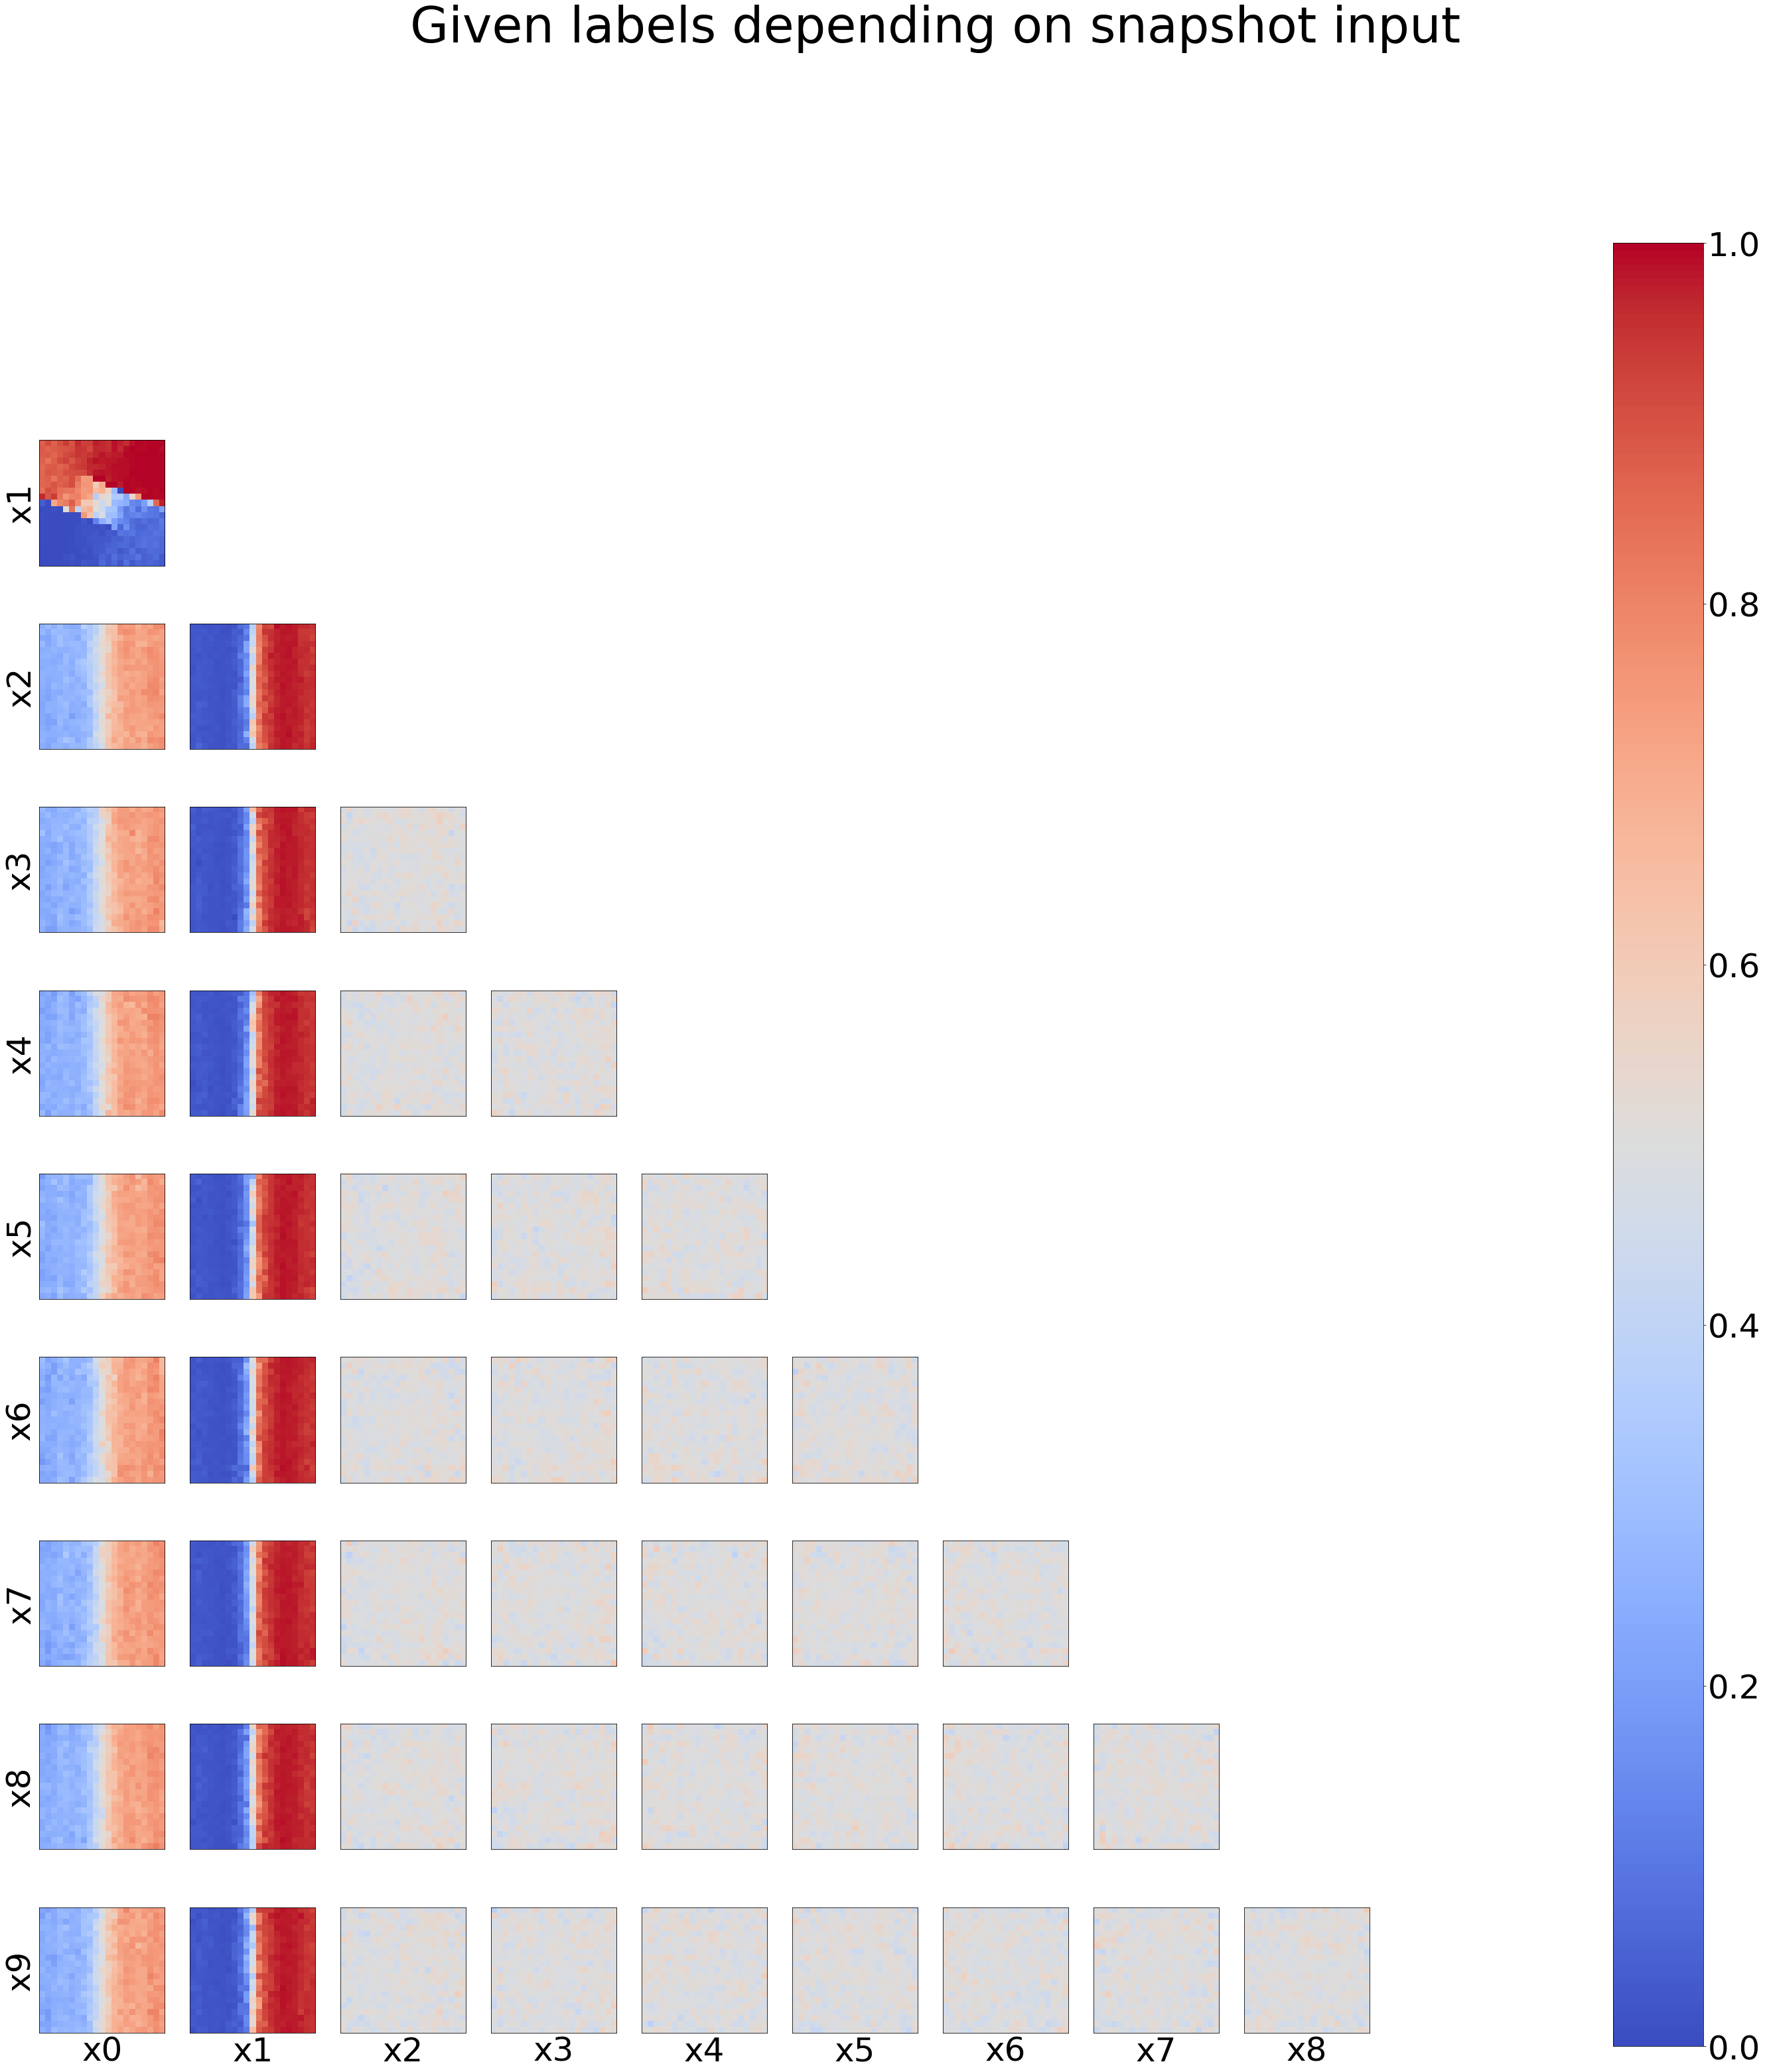

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
0


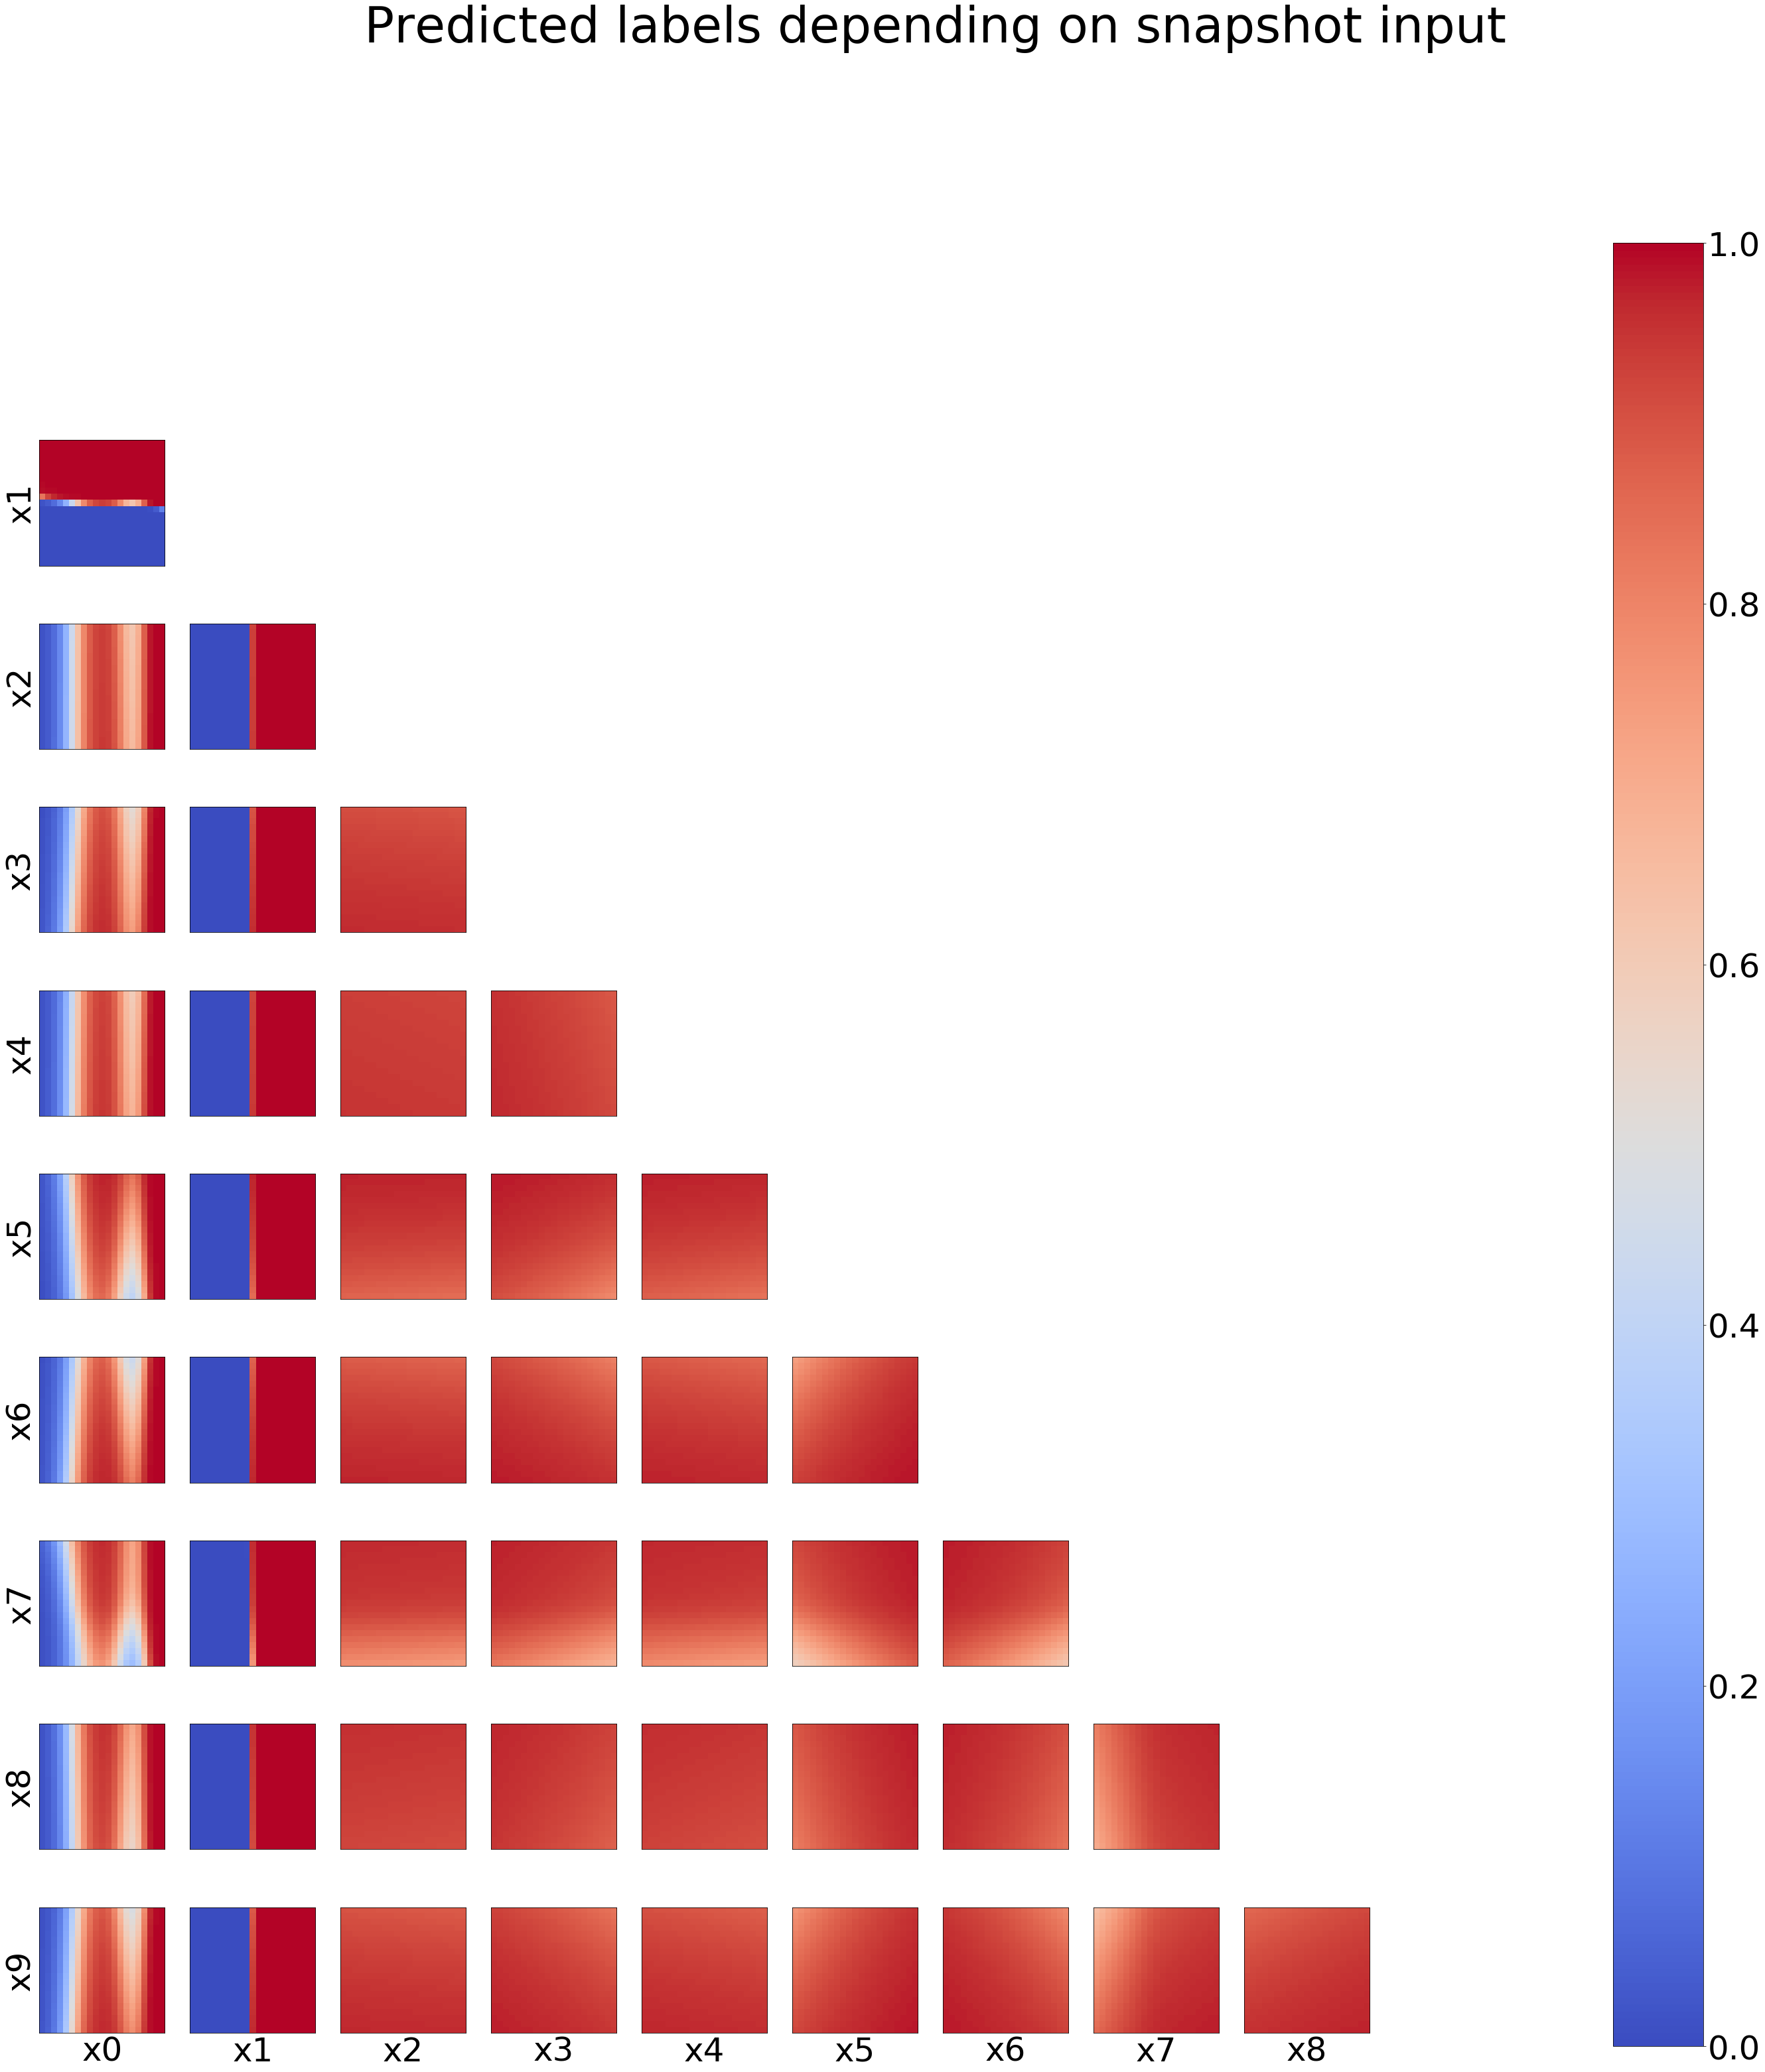

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
0


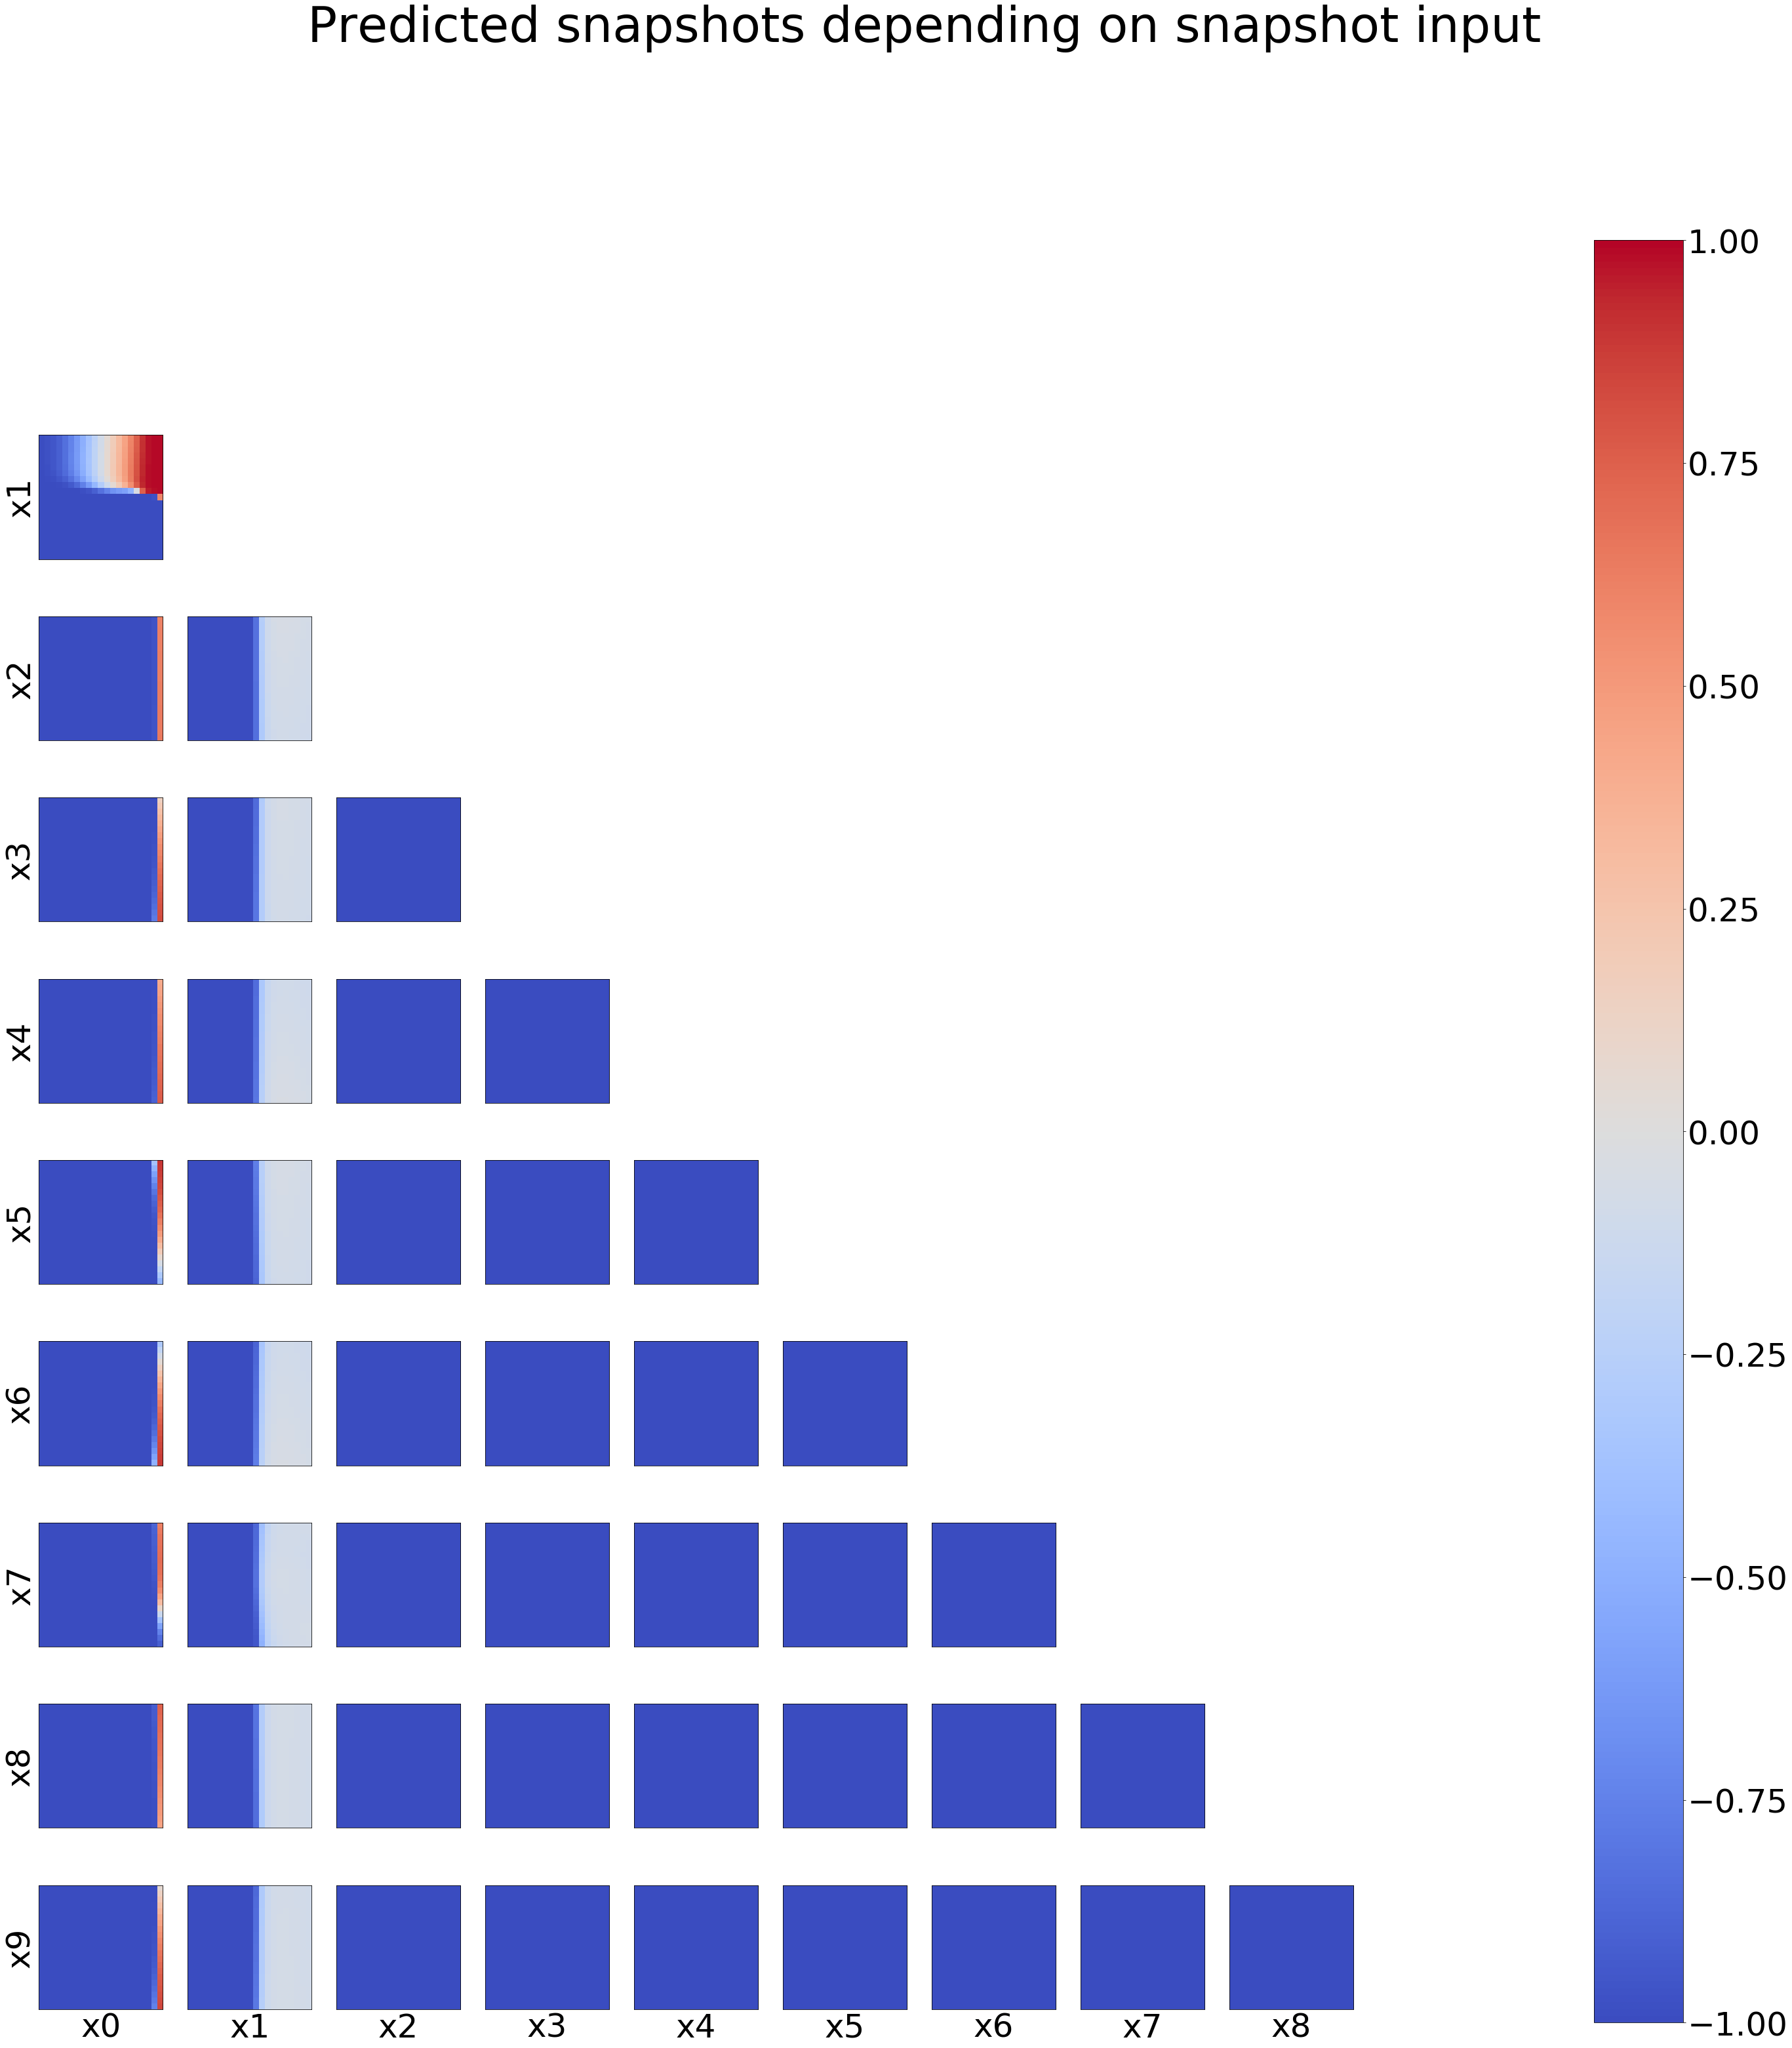

1


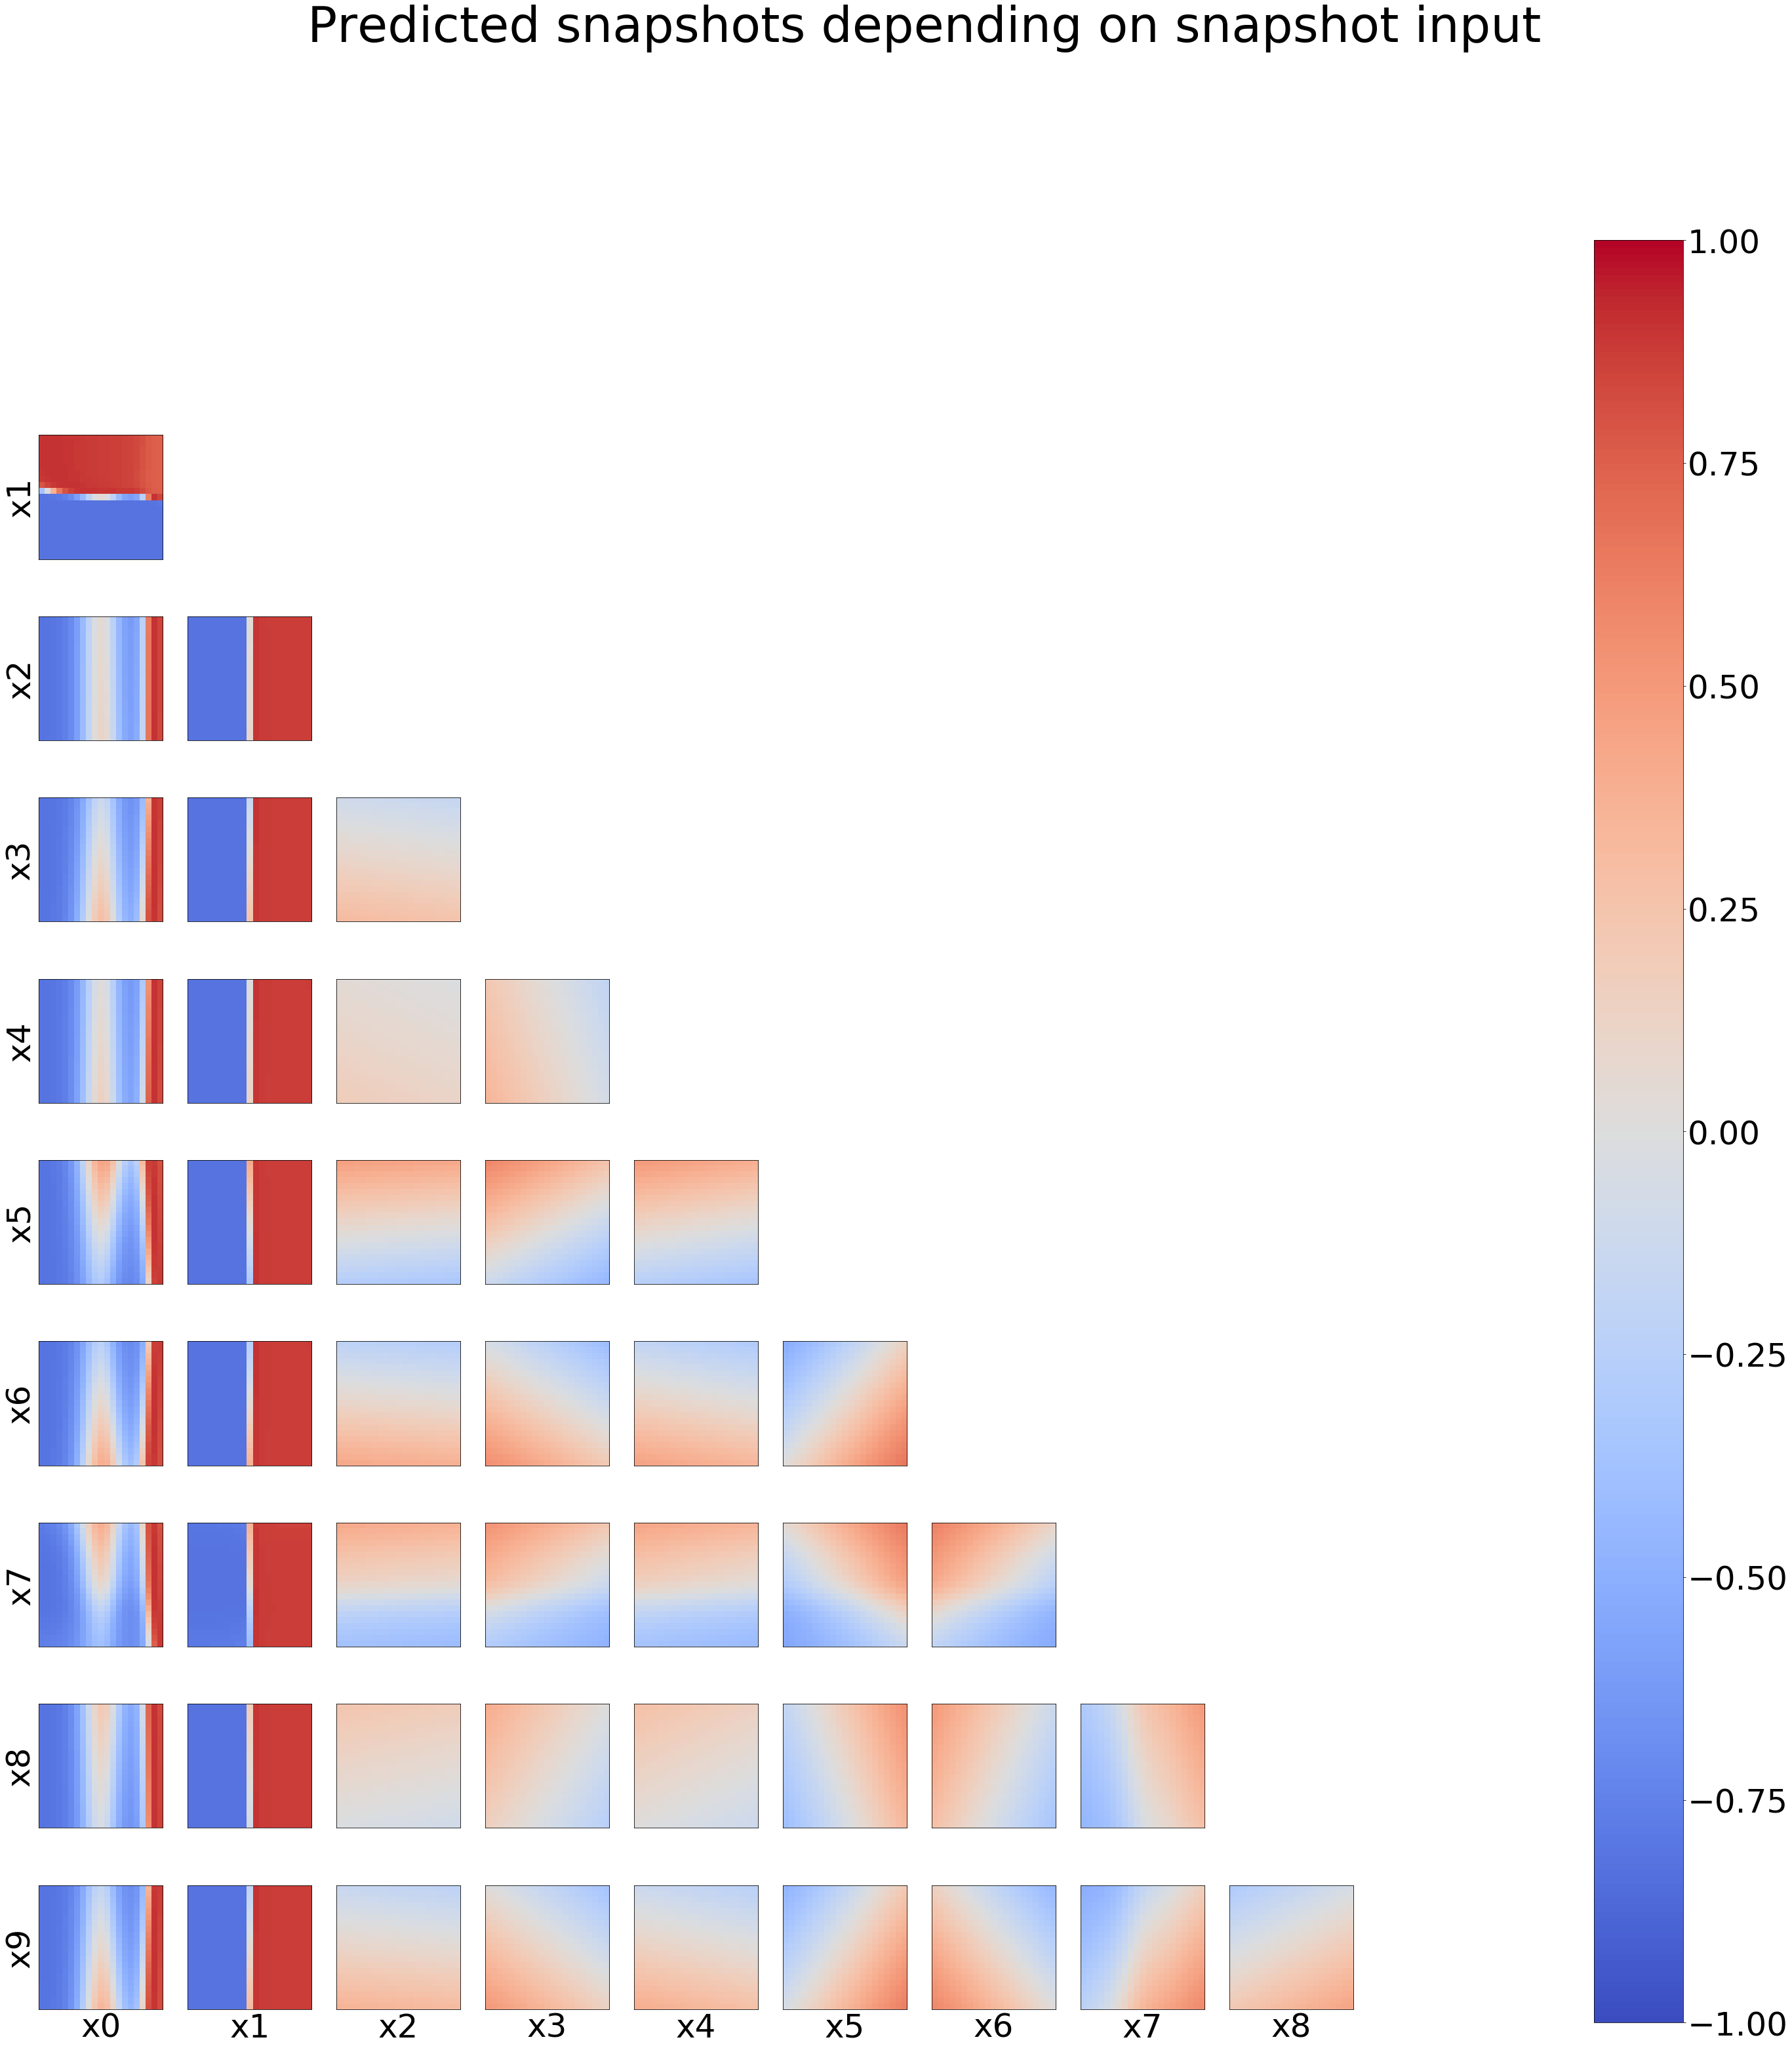

2


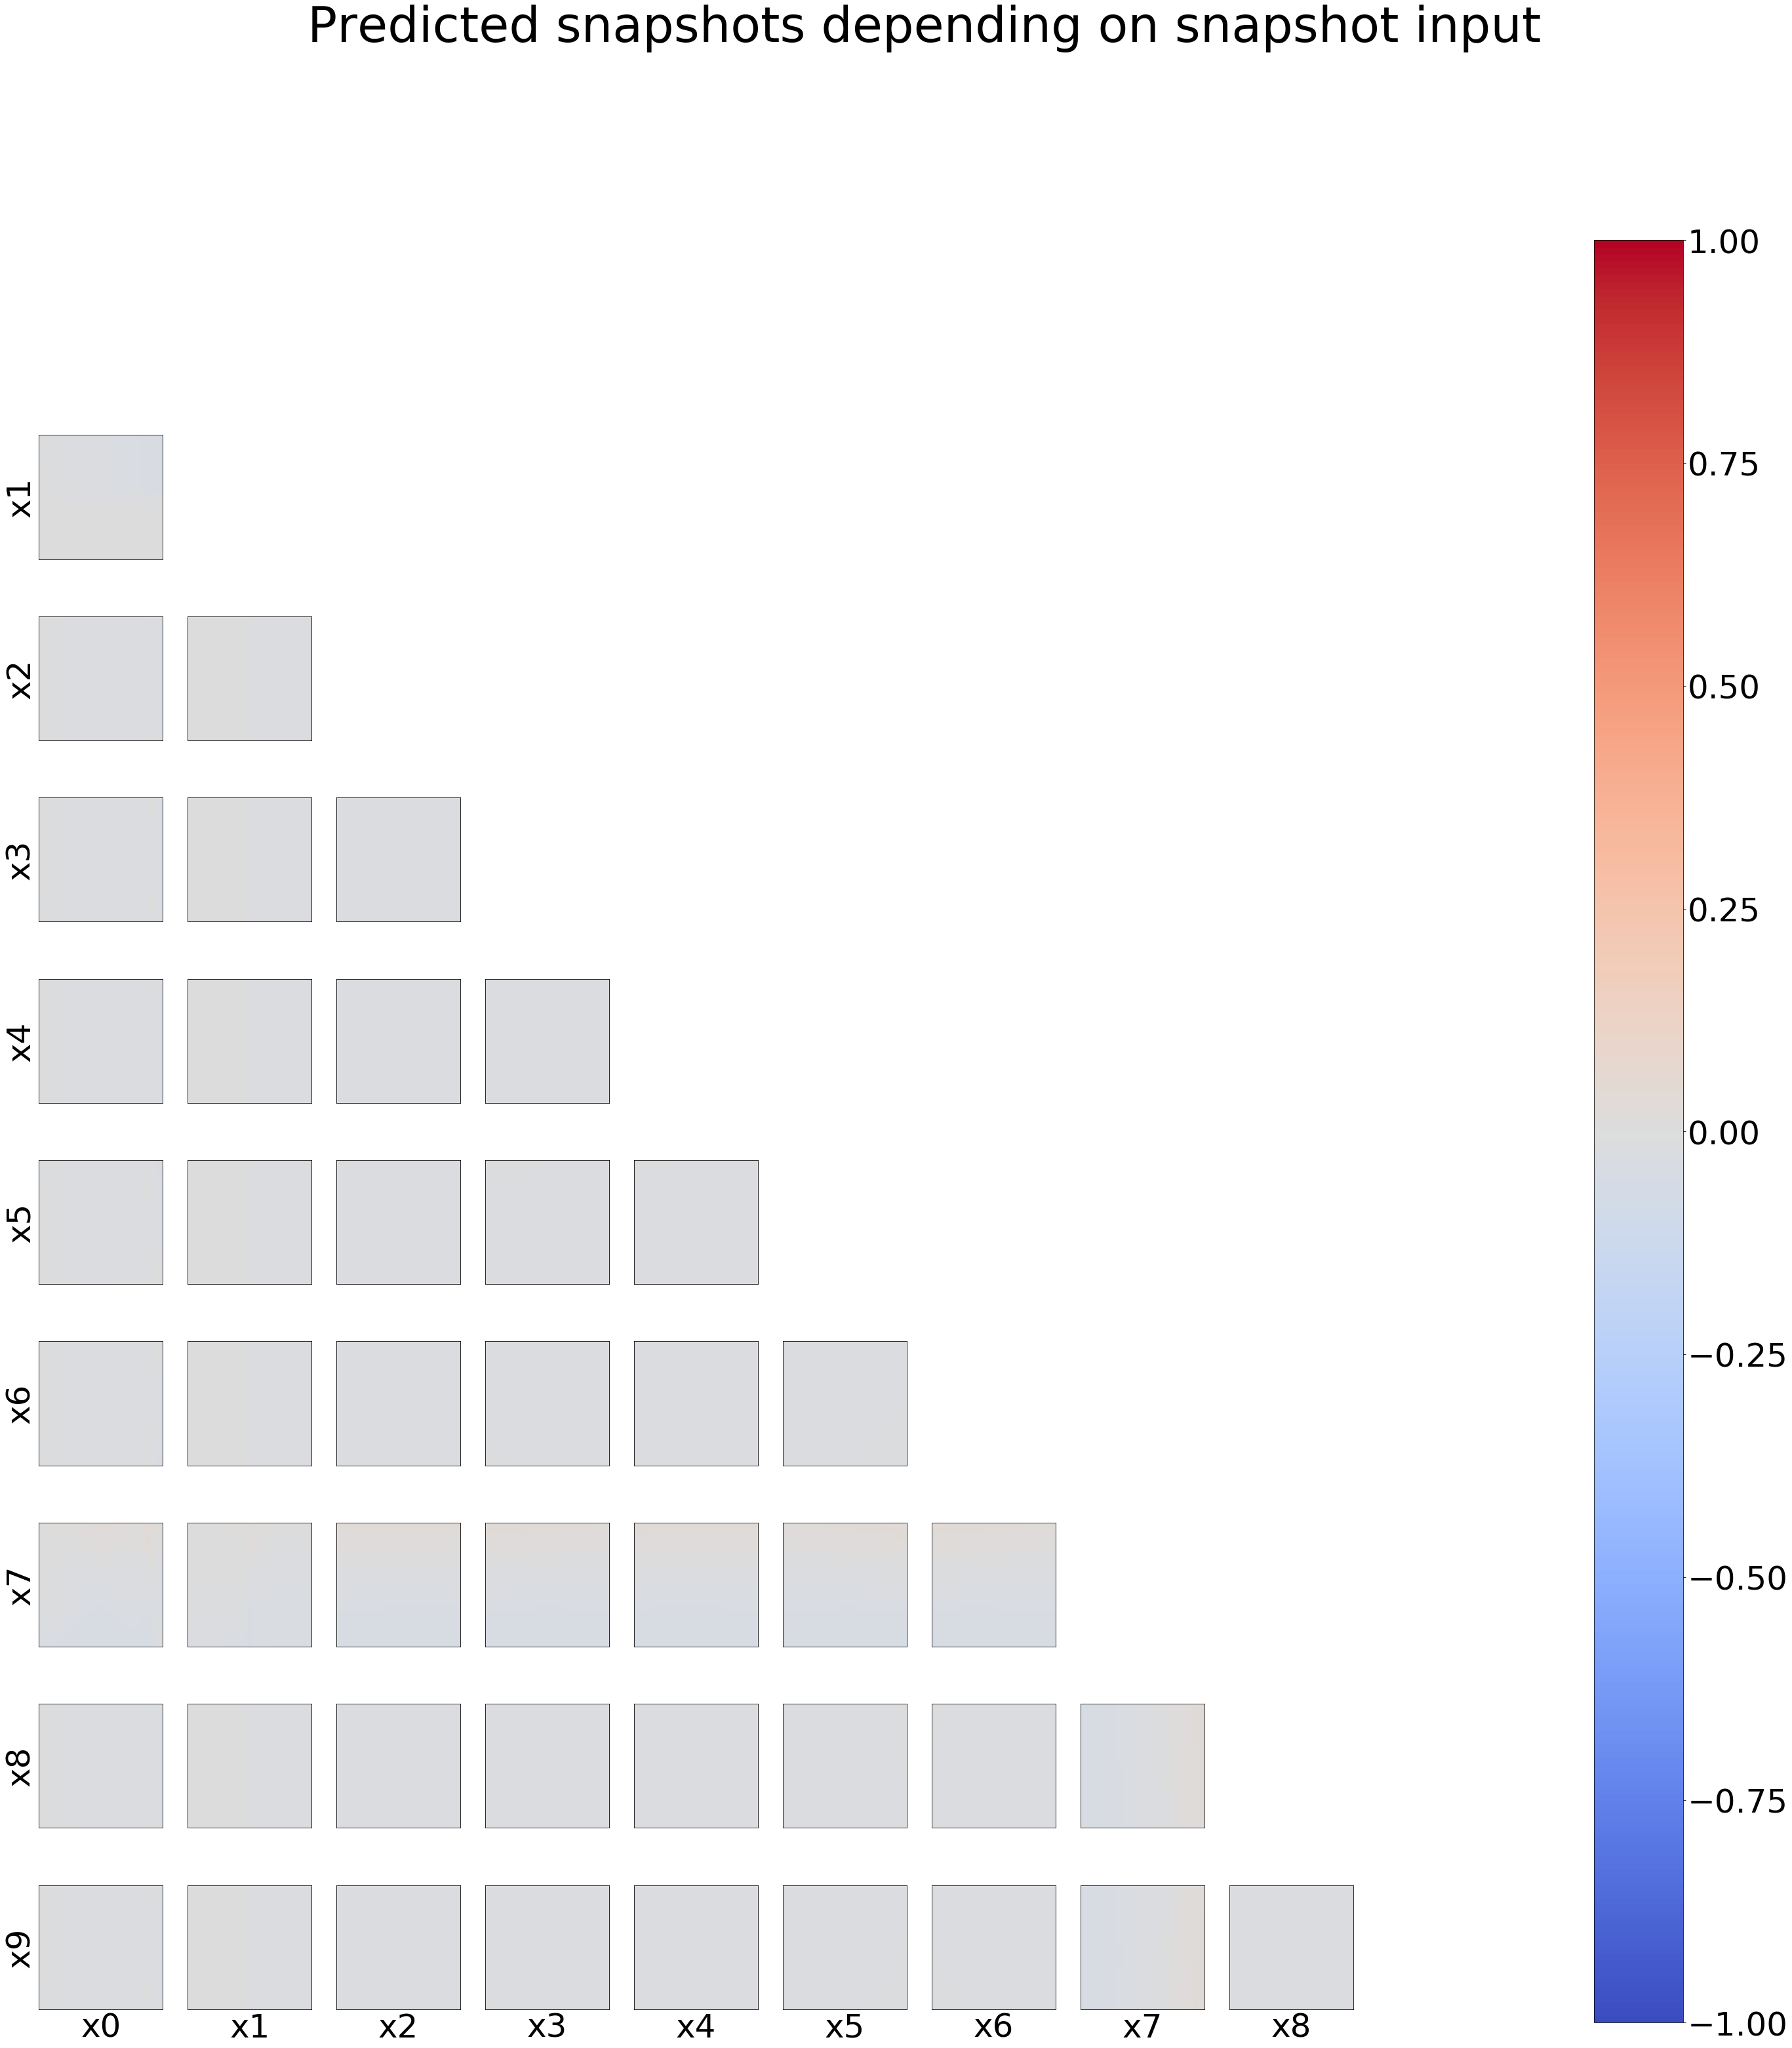

3


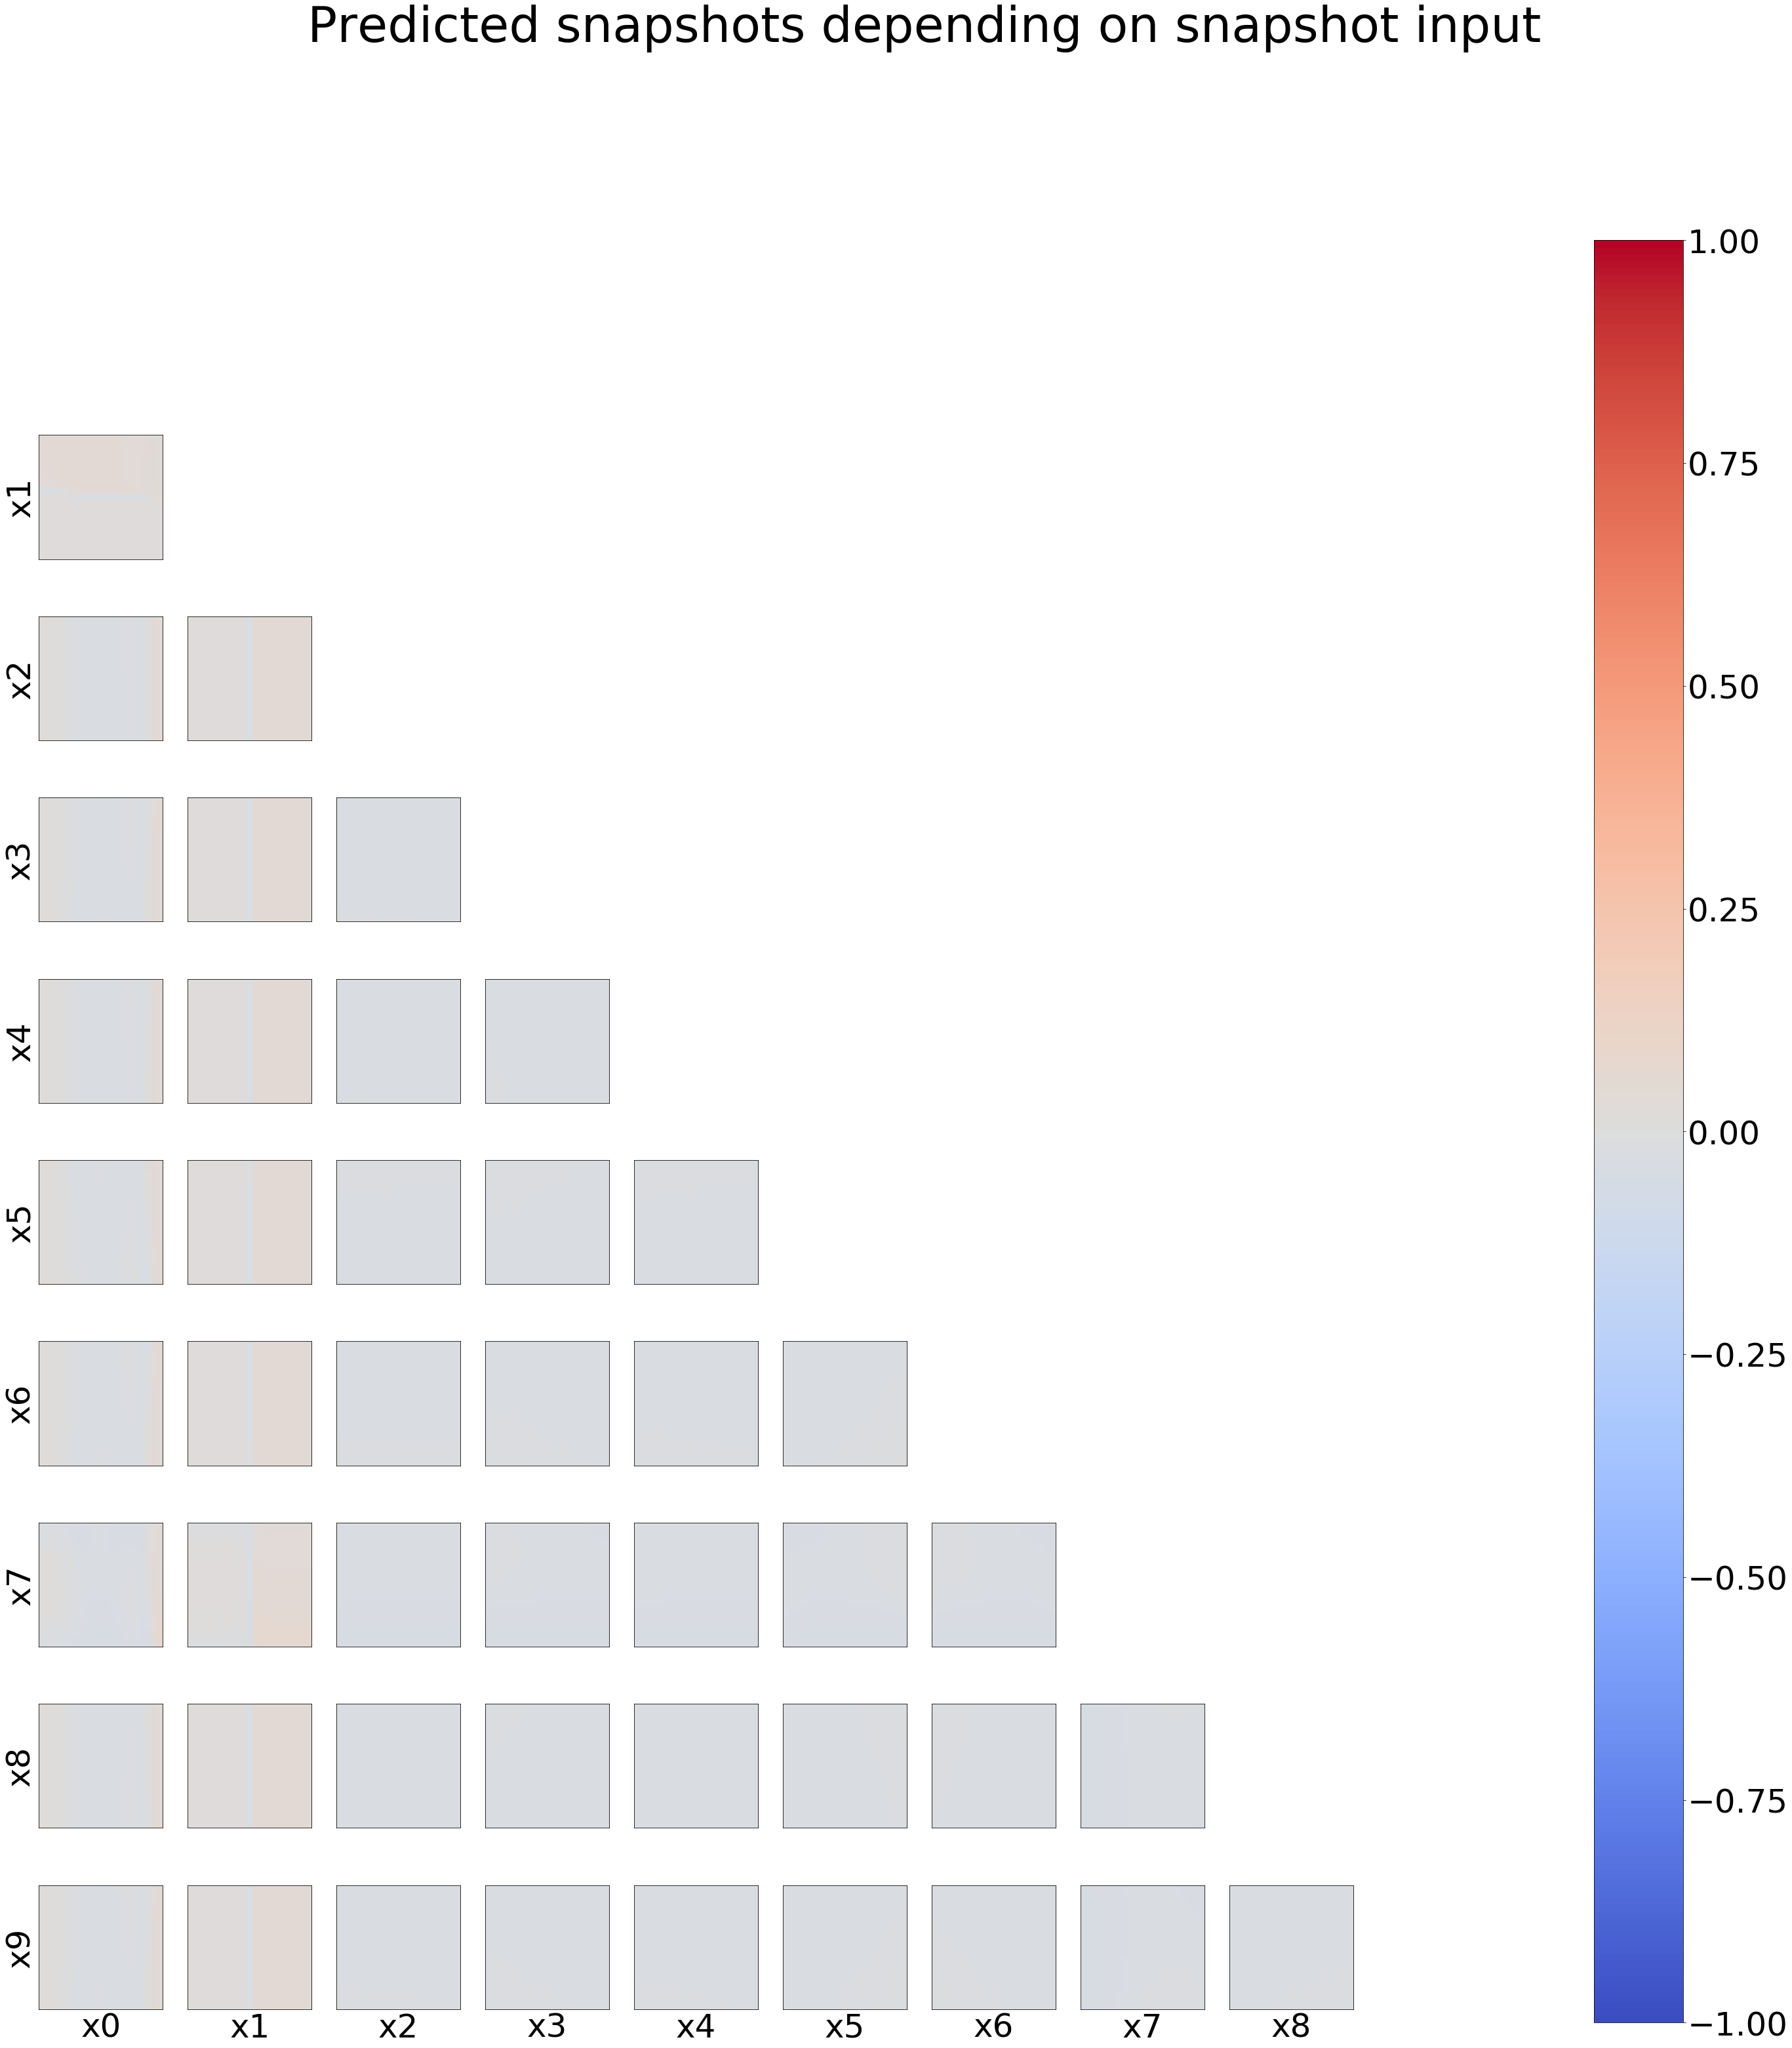

4


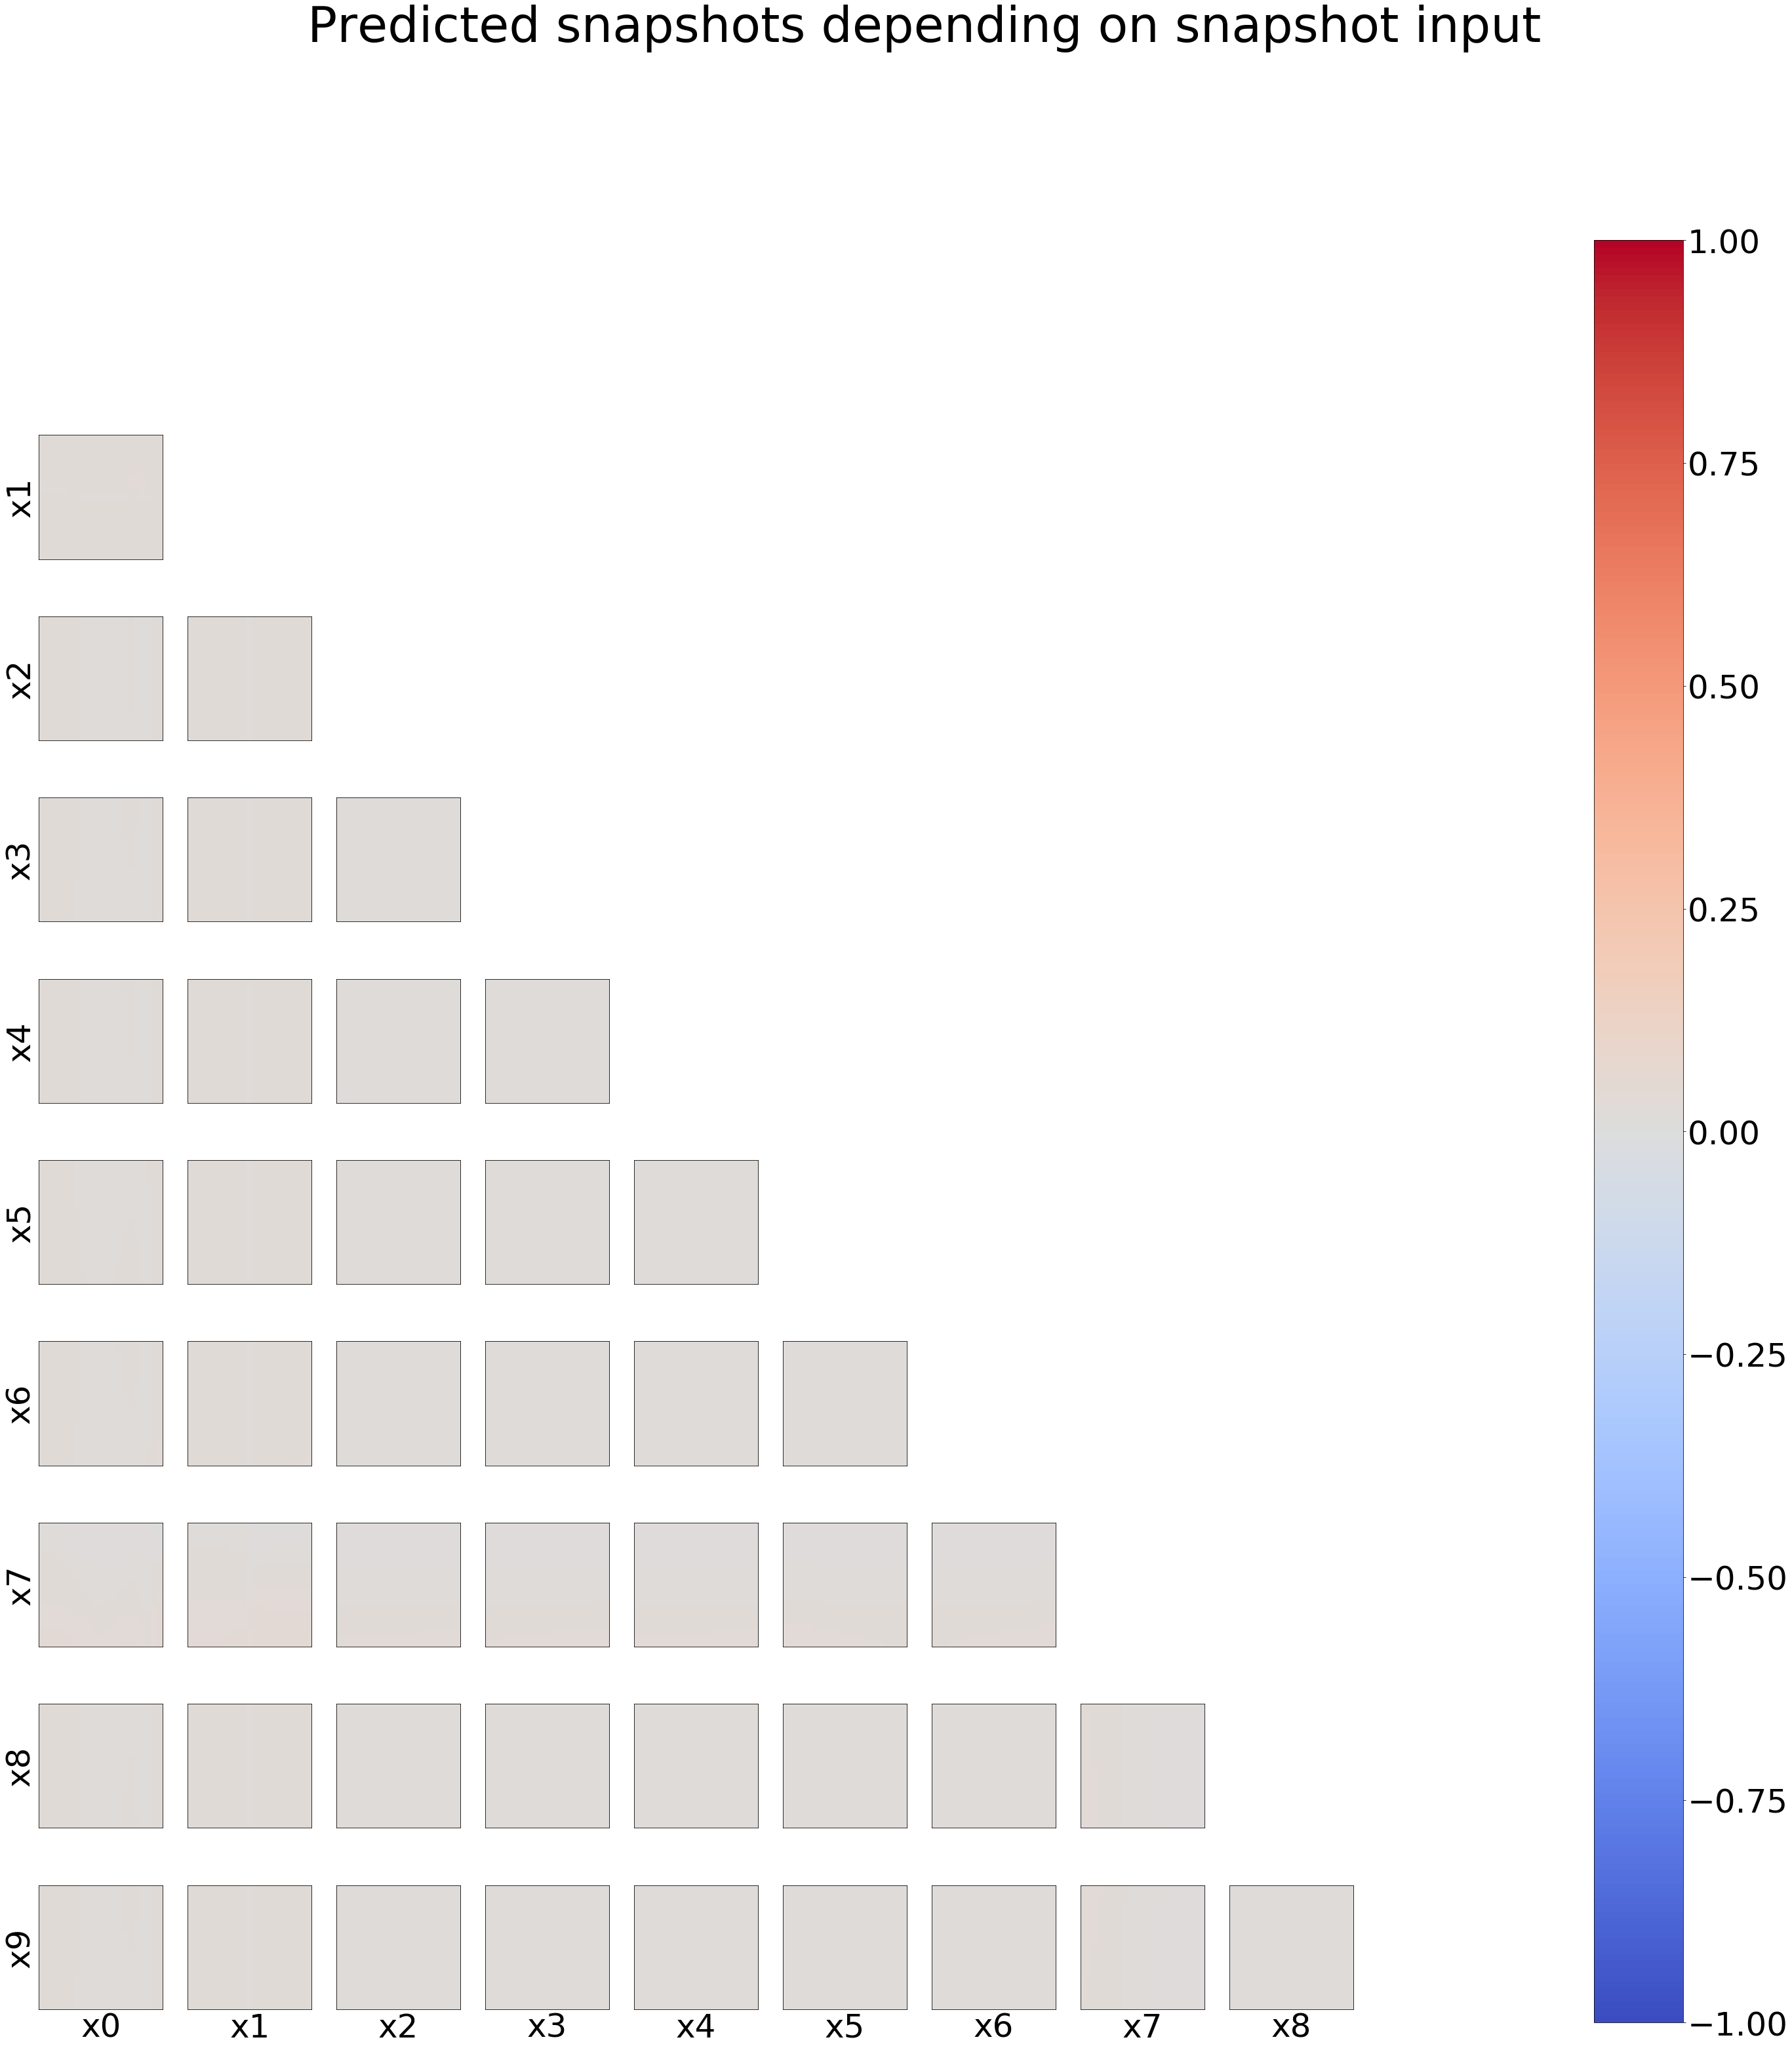

5


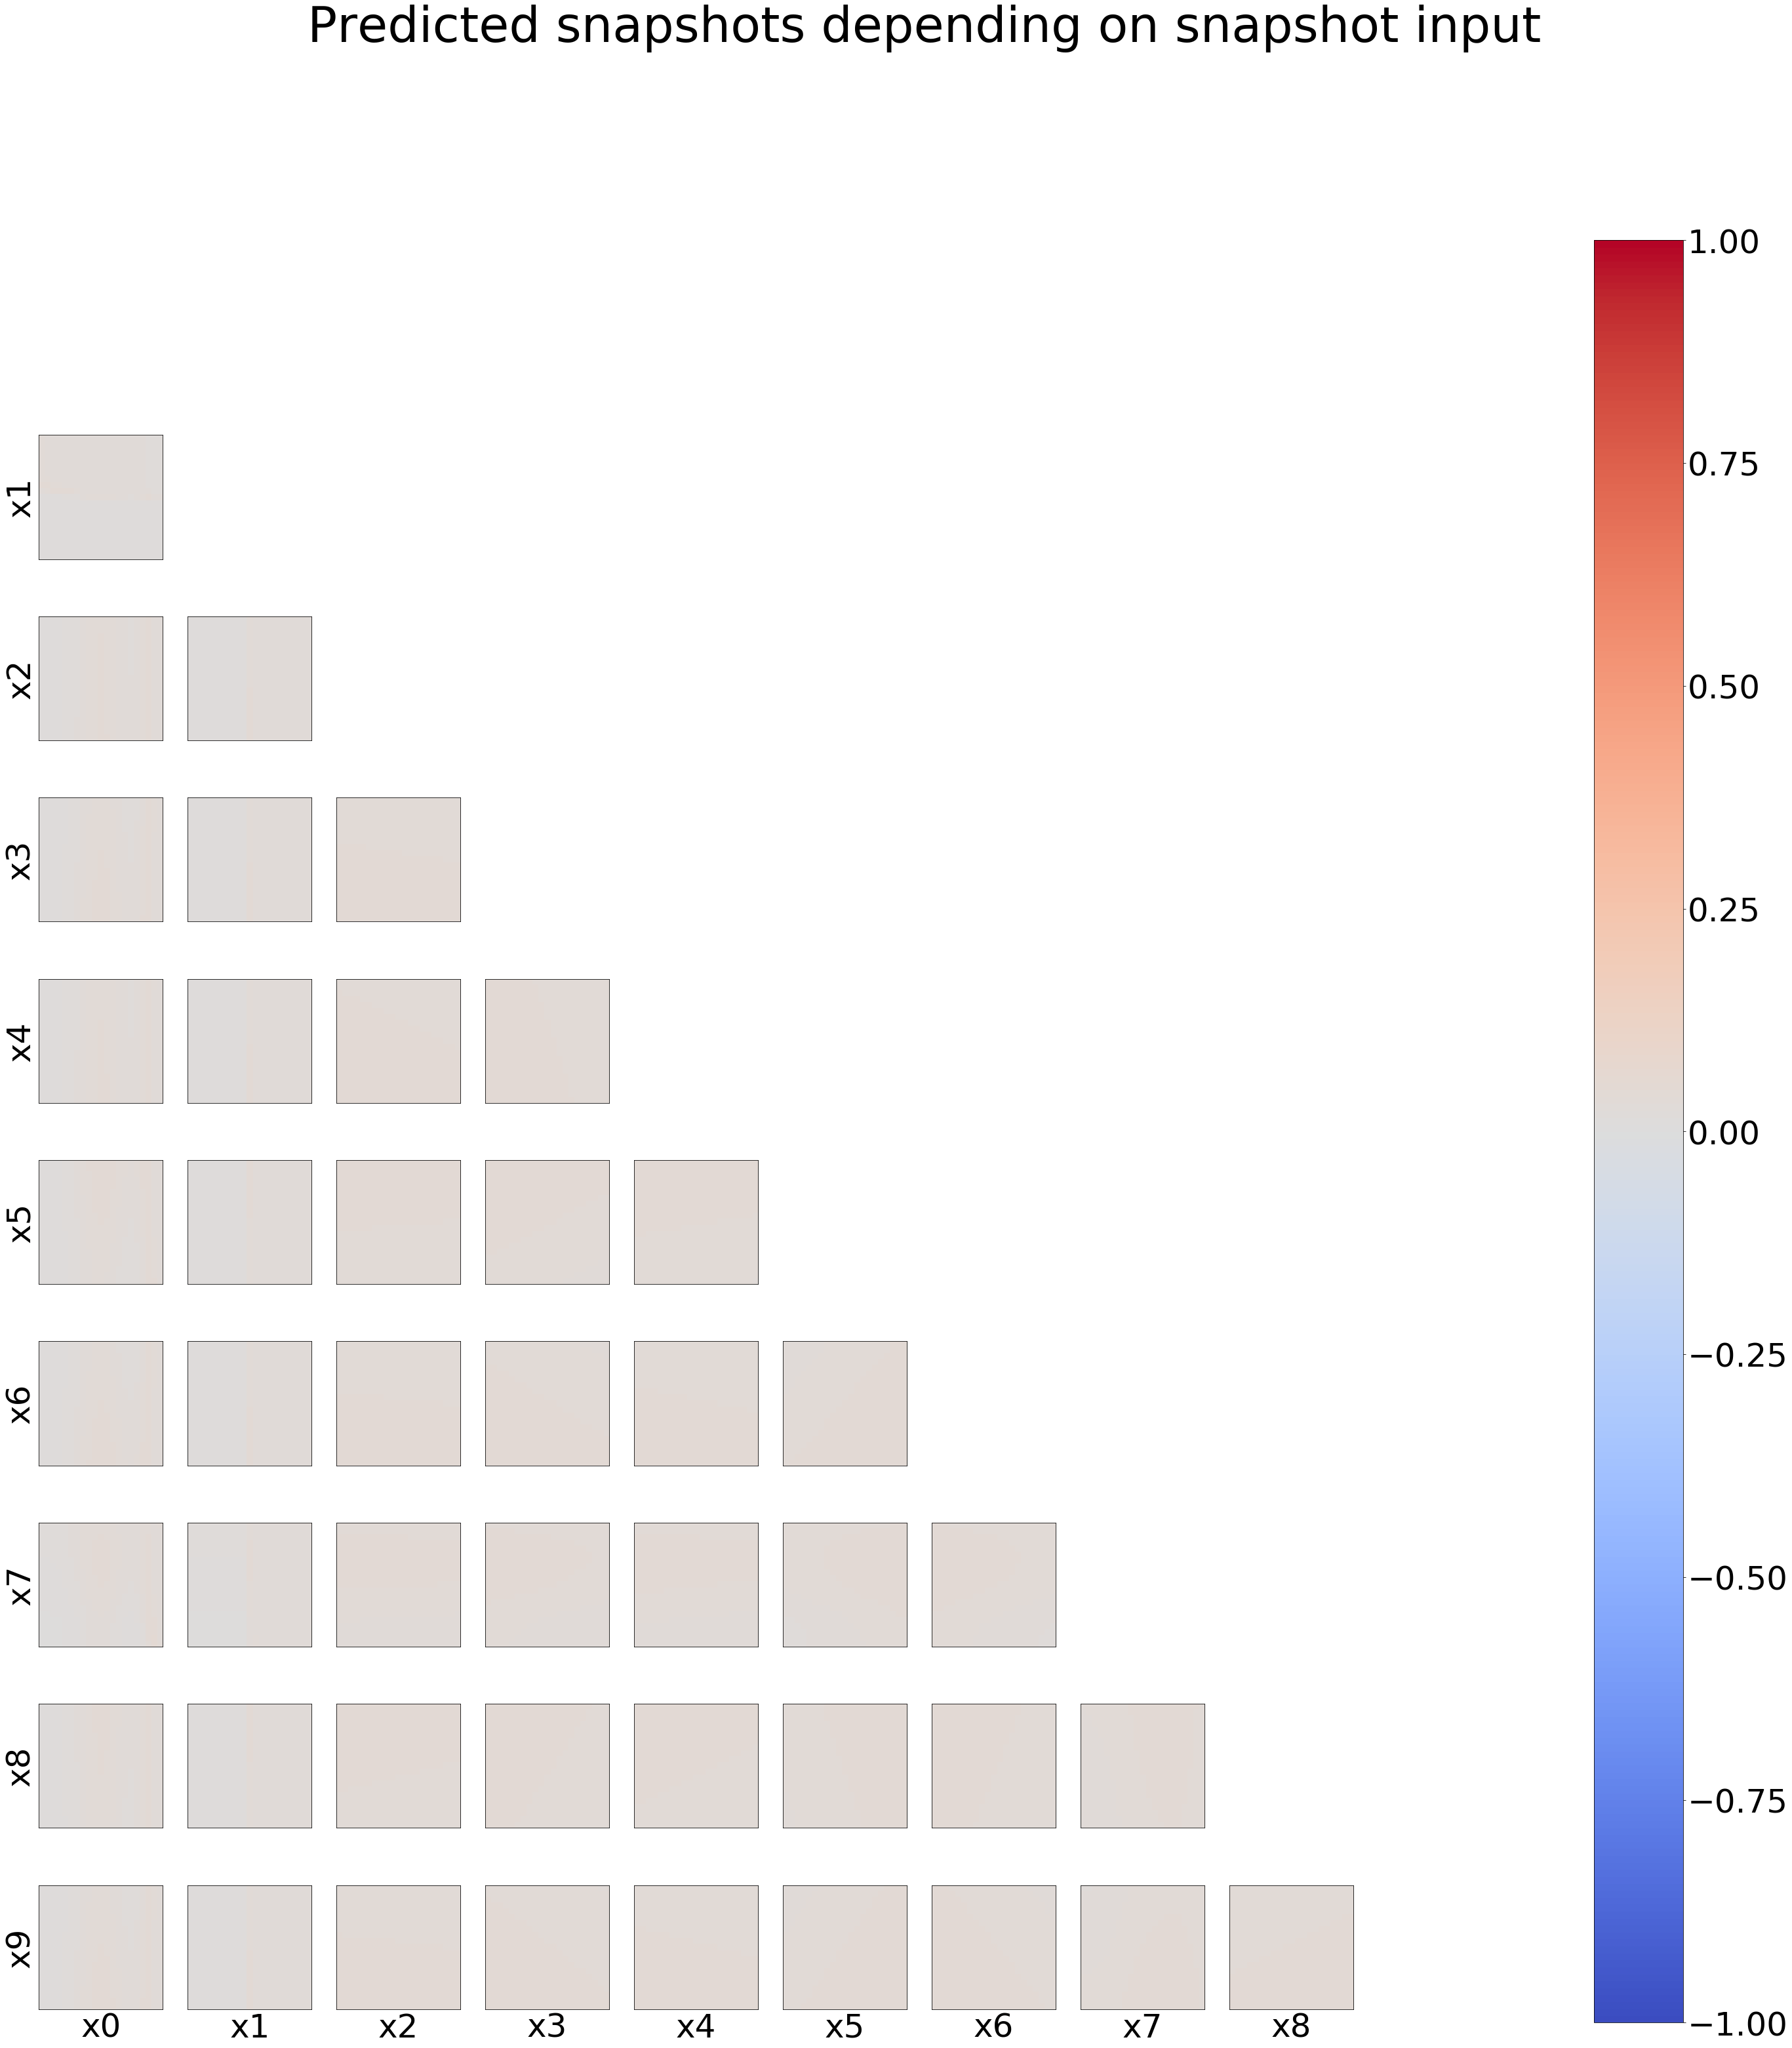

6


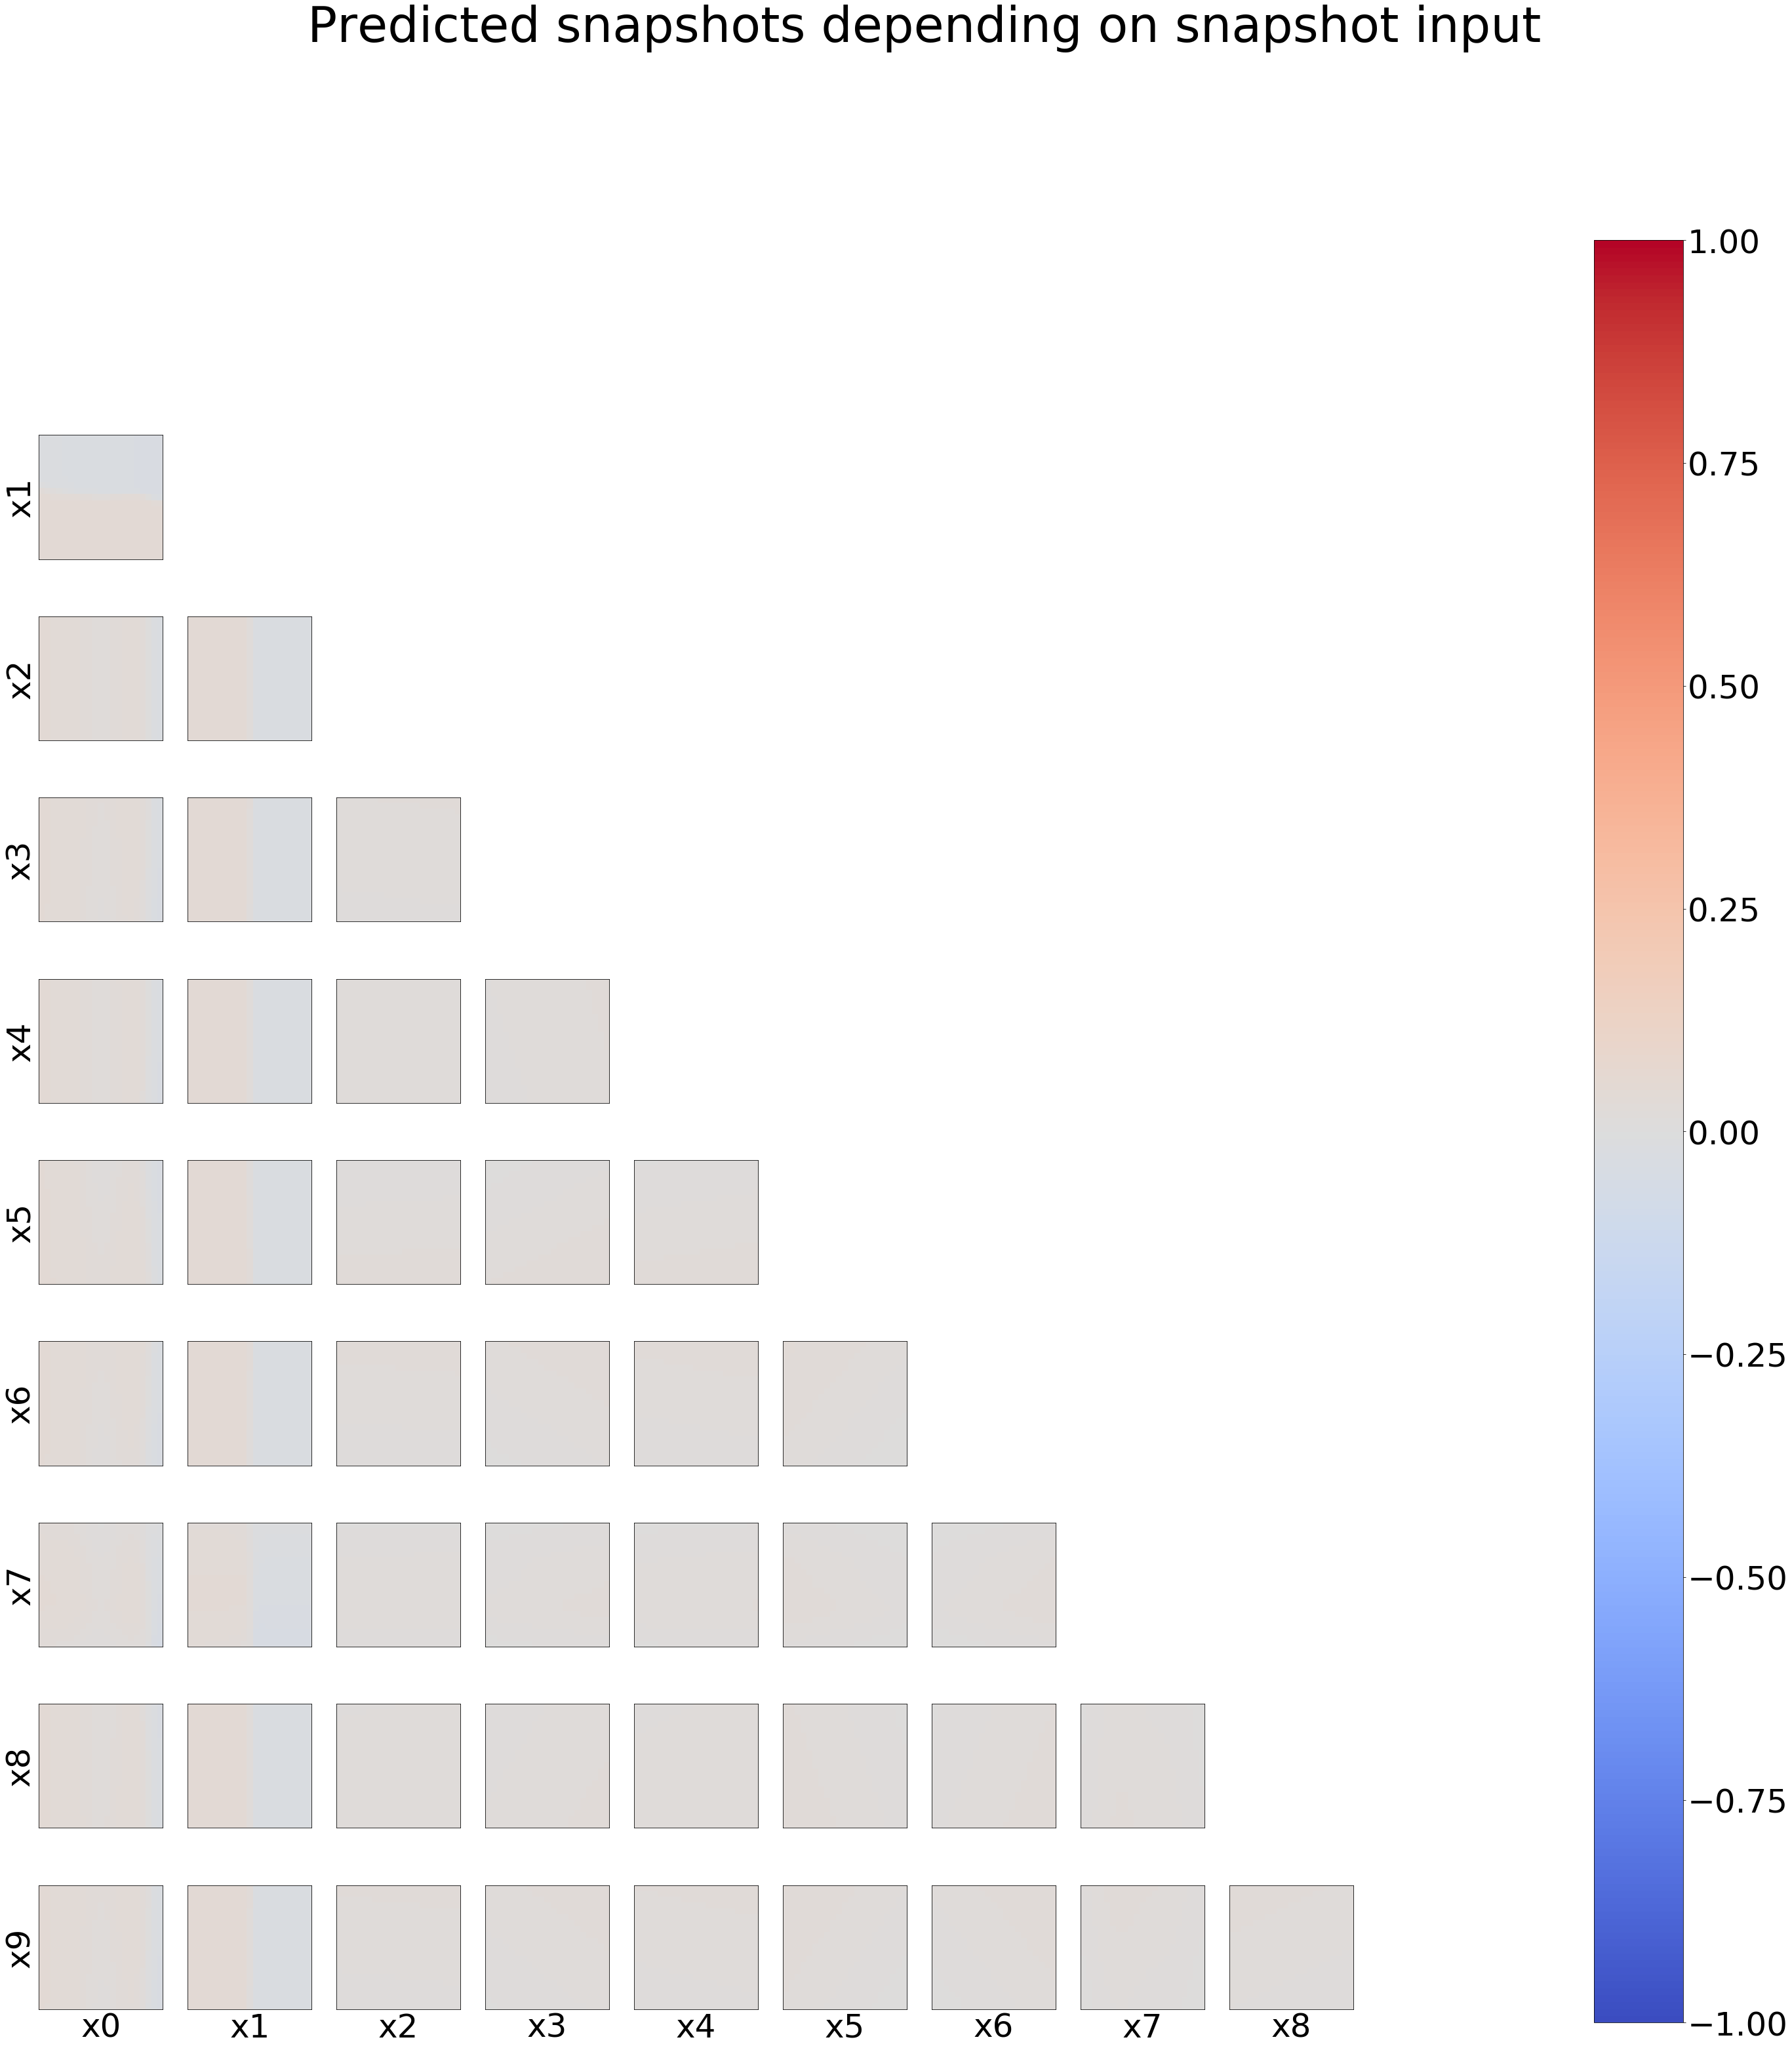

7


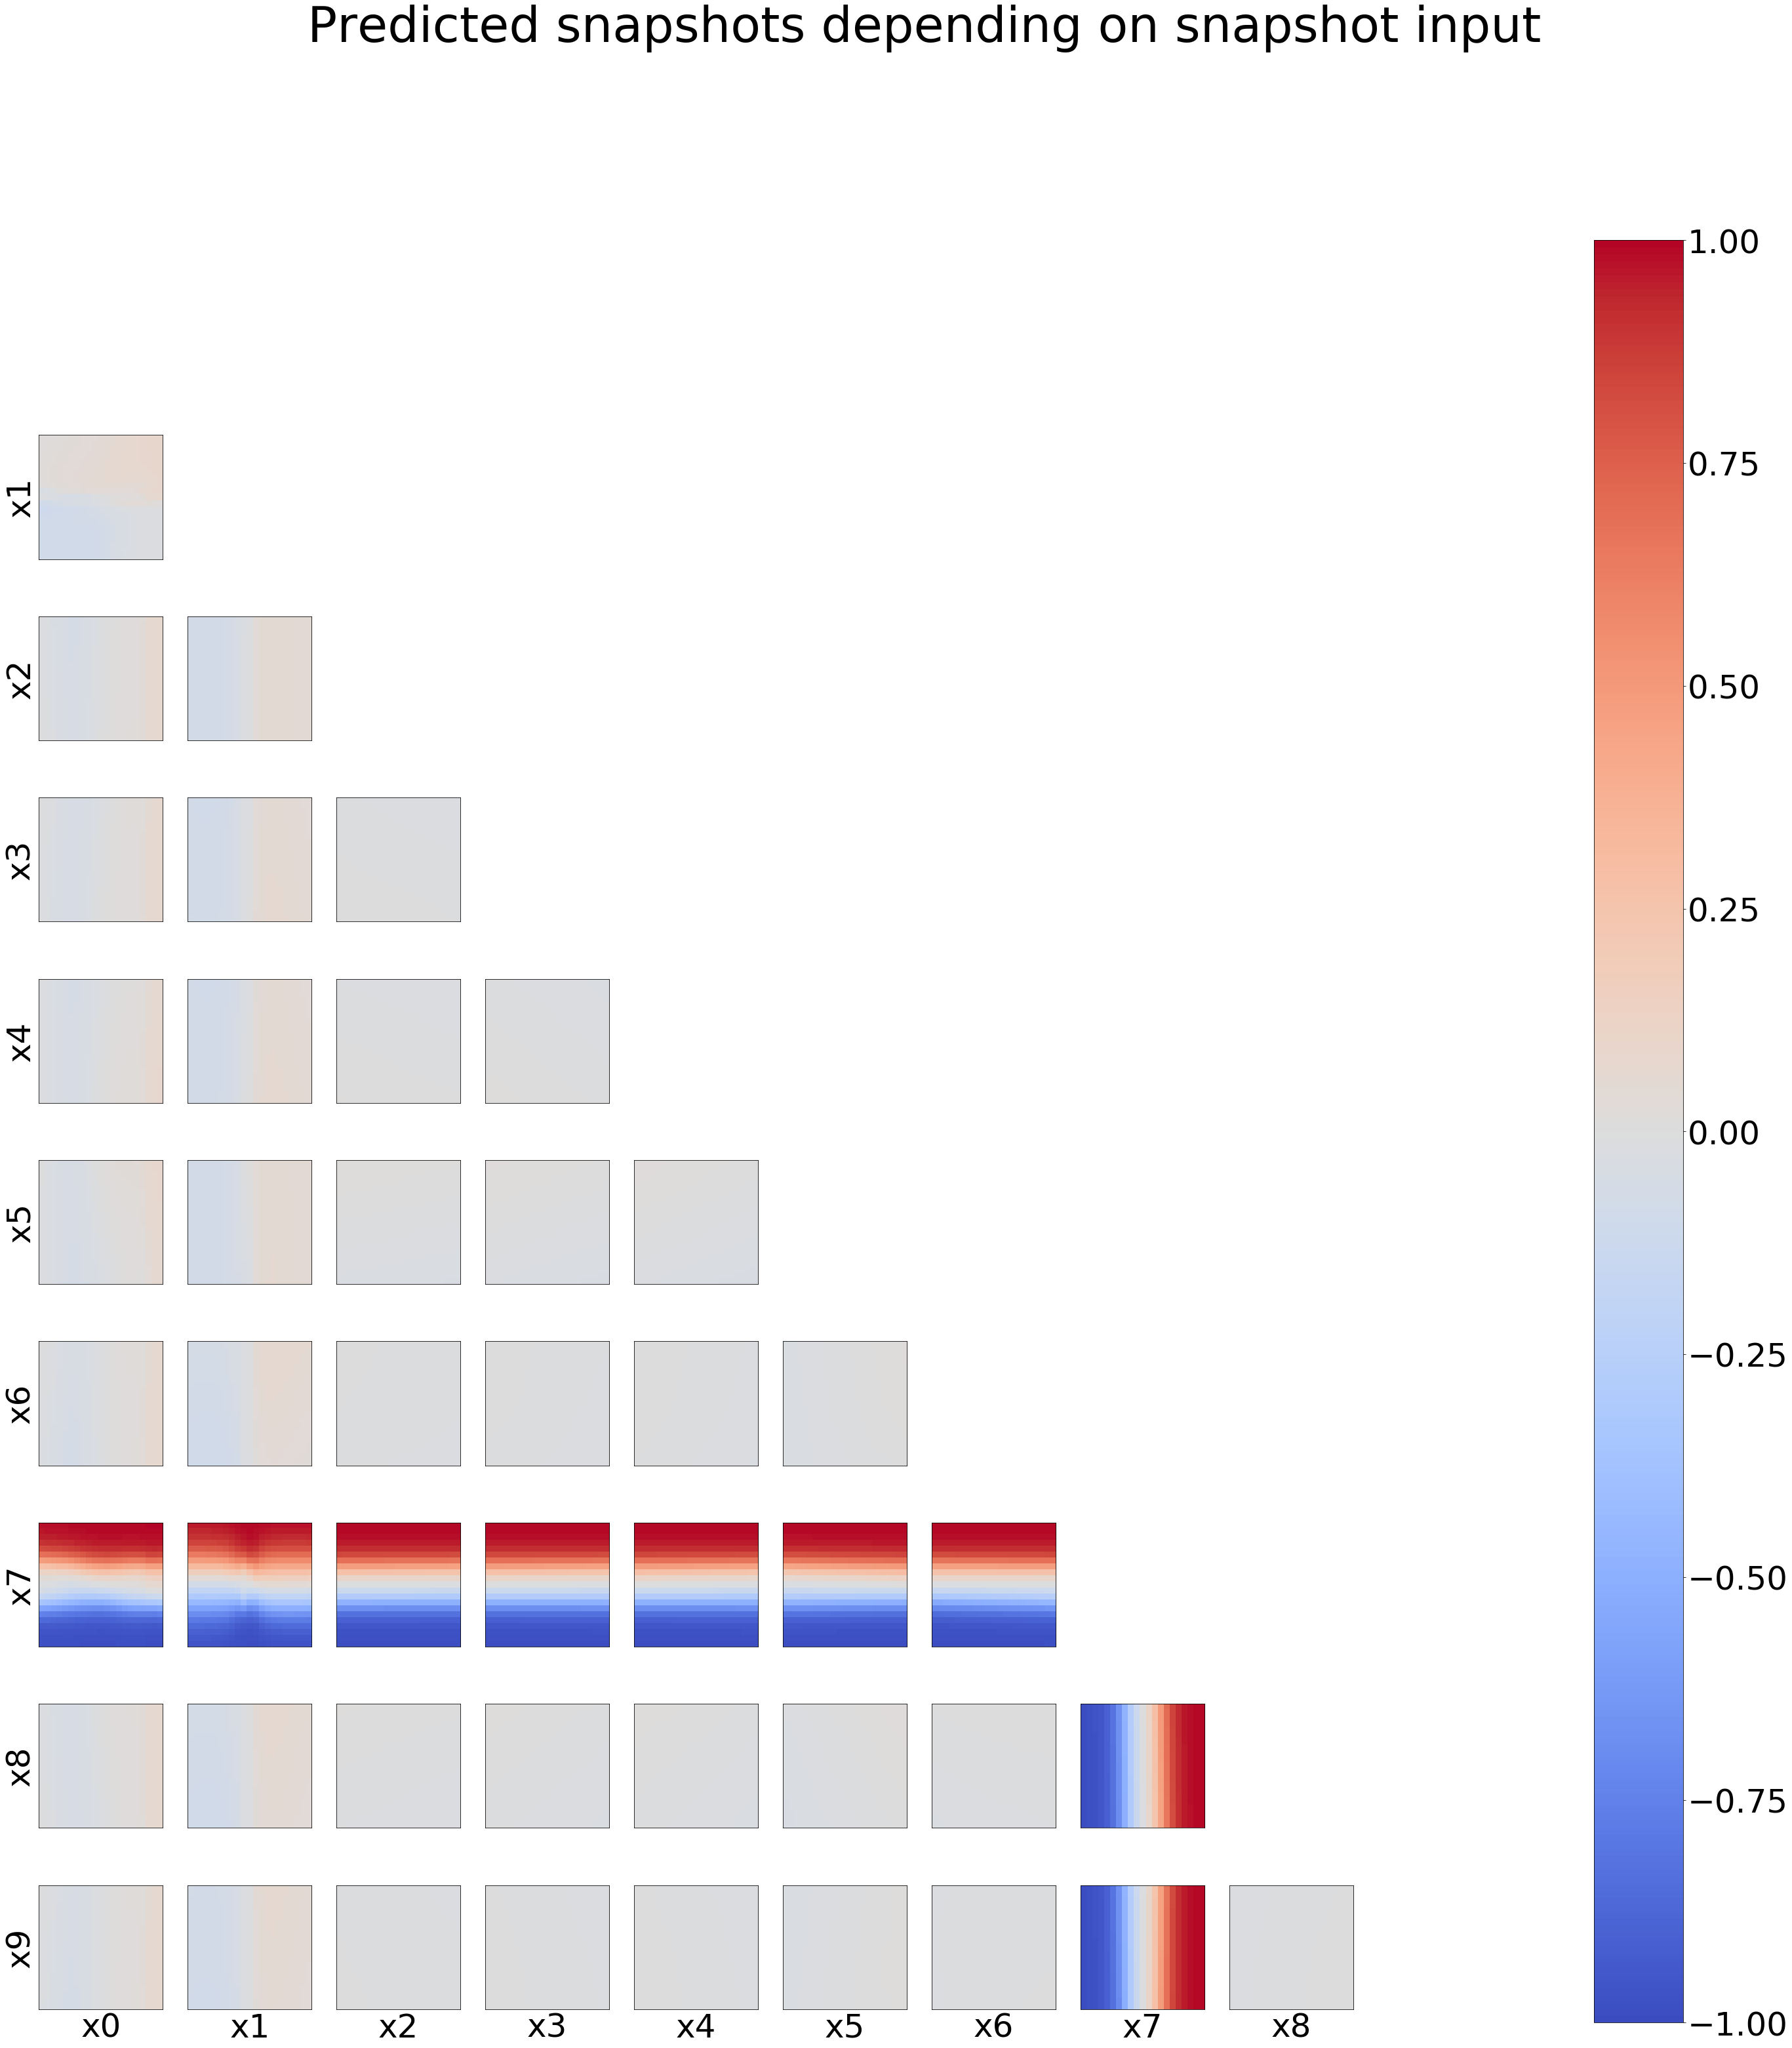

8


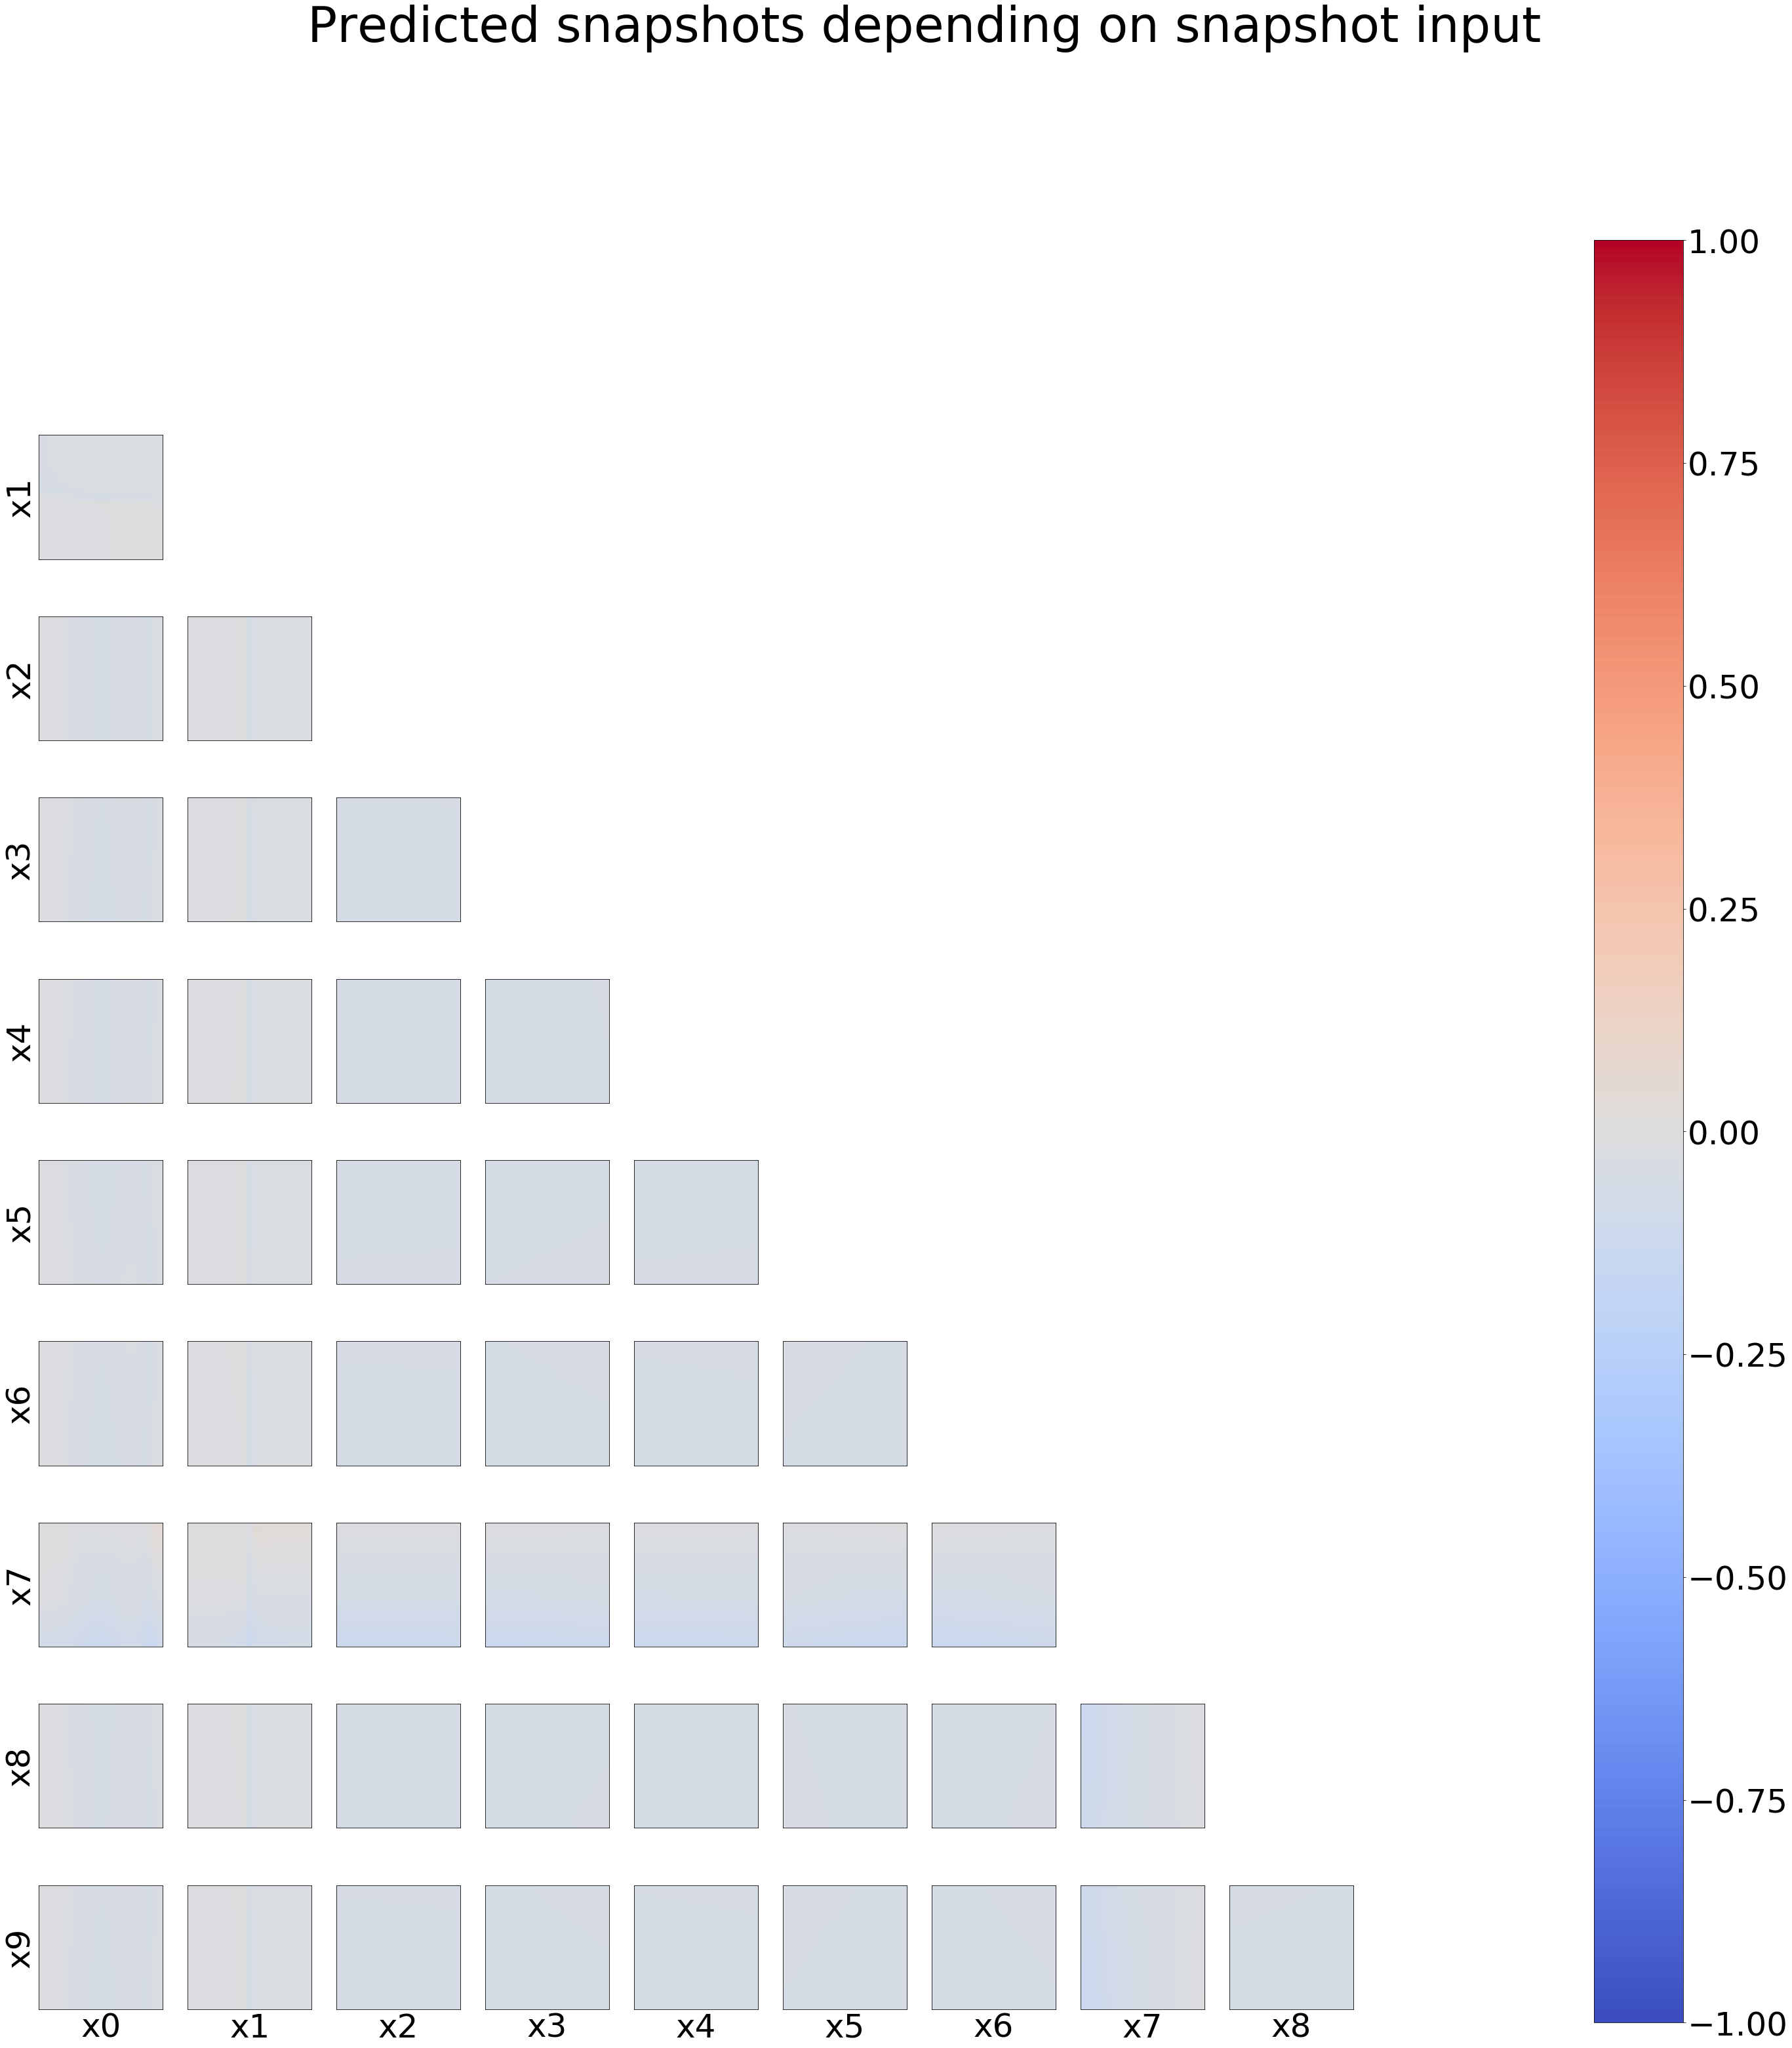

9


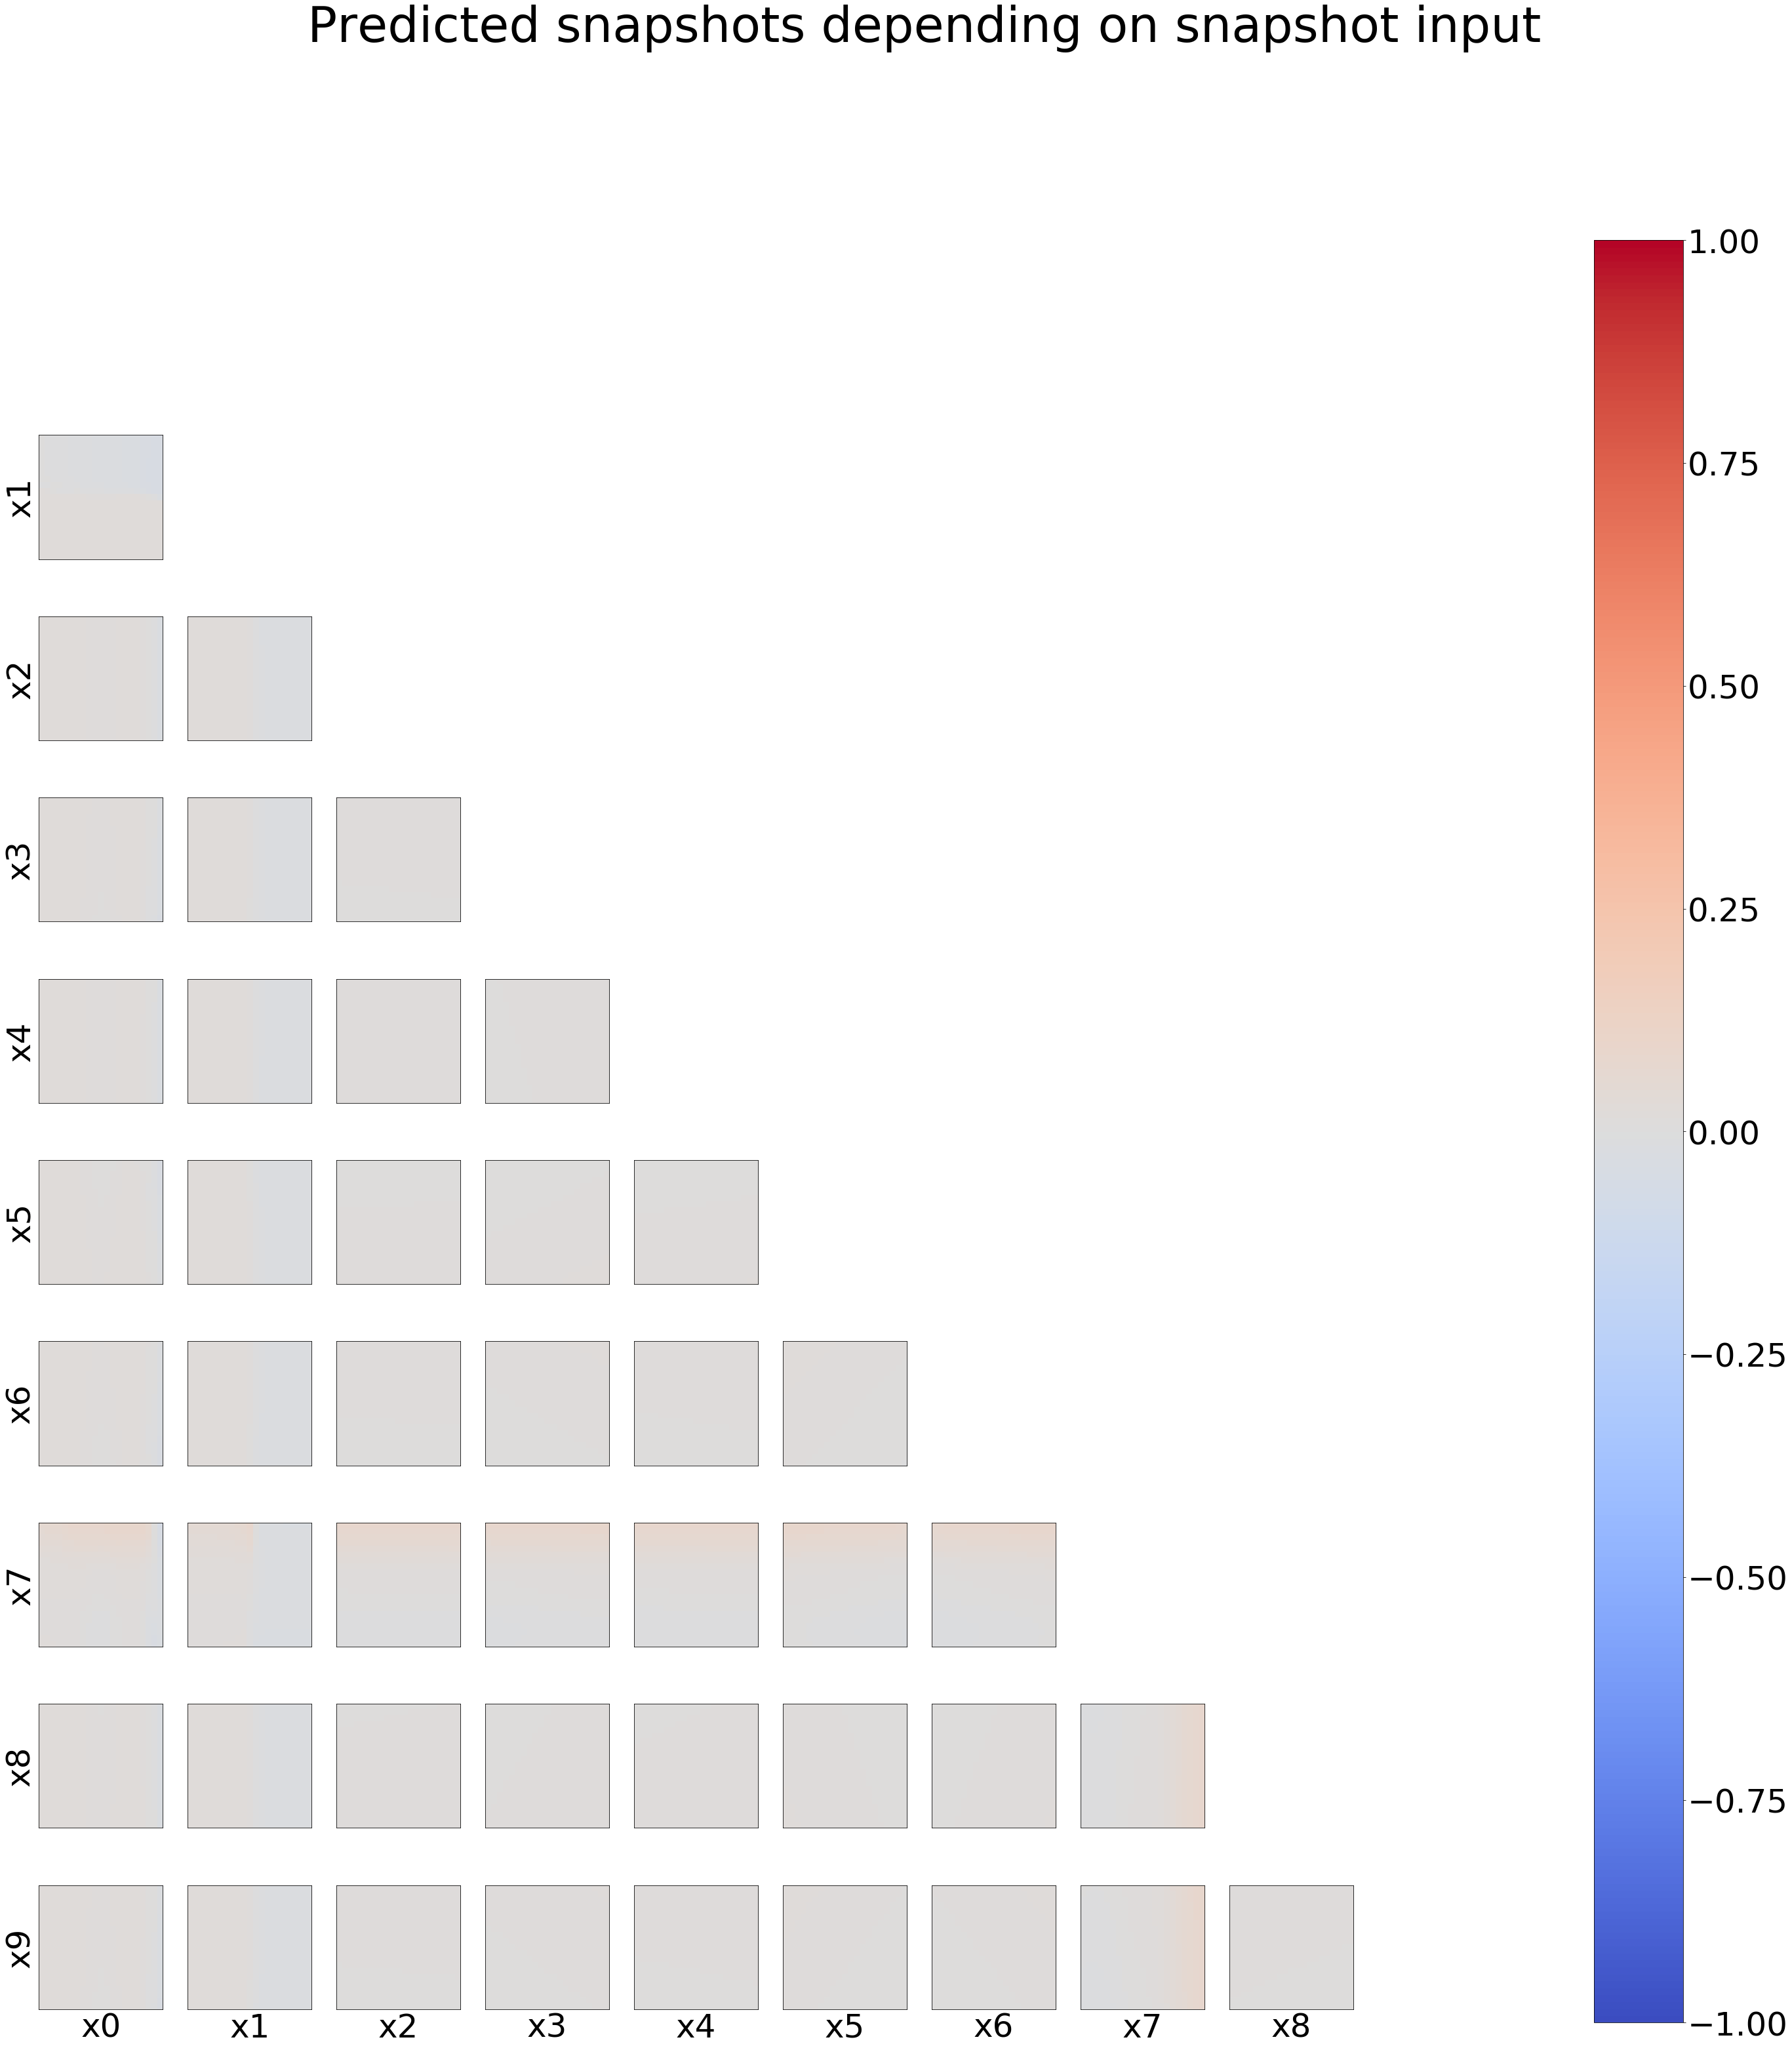

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
0


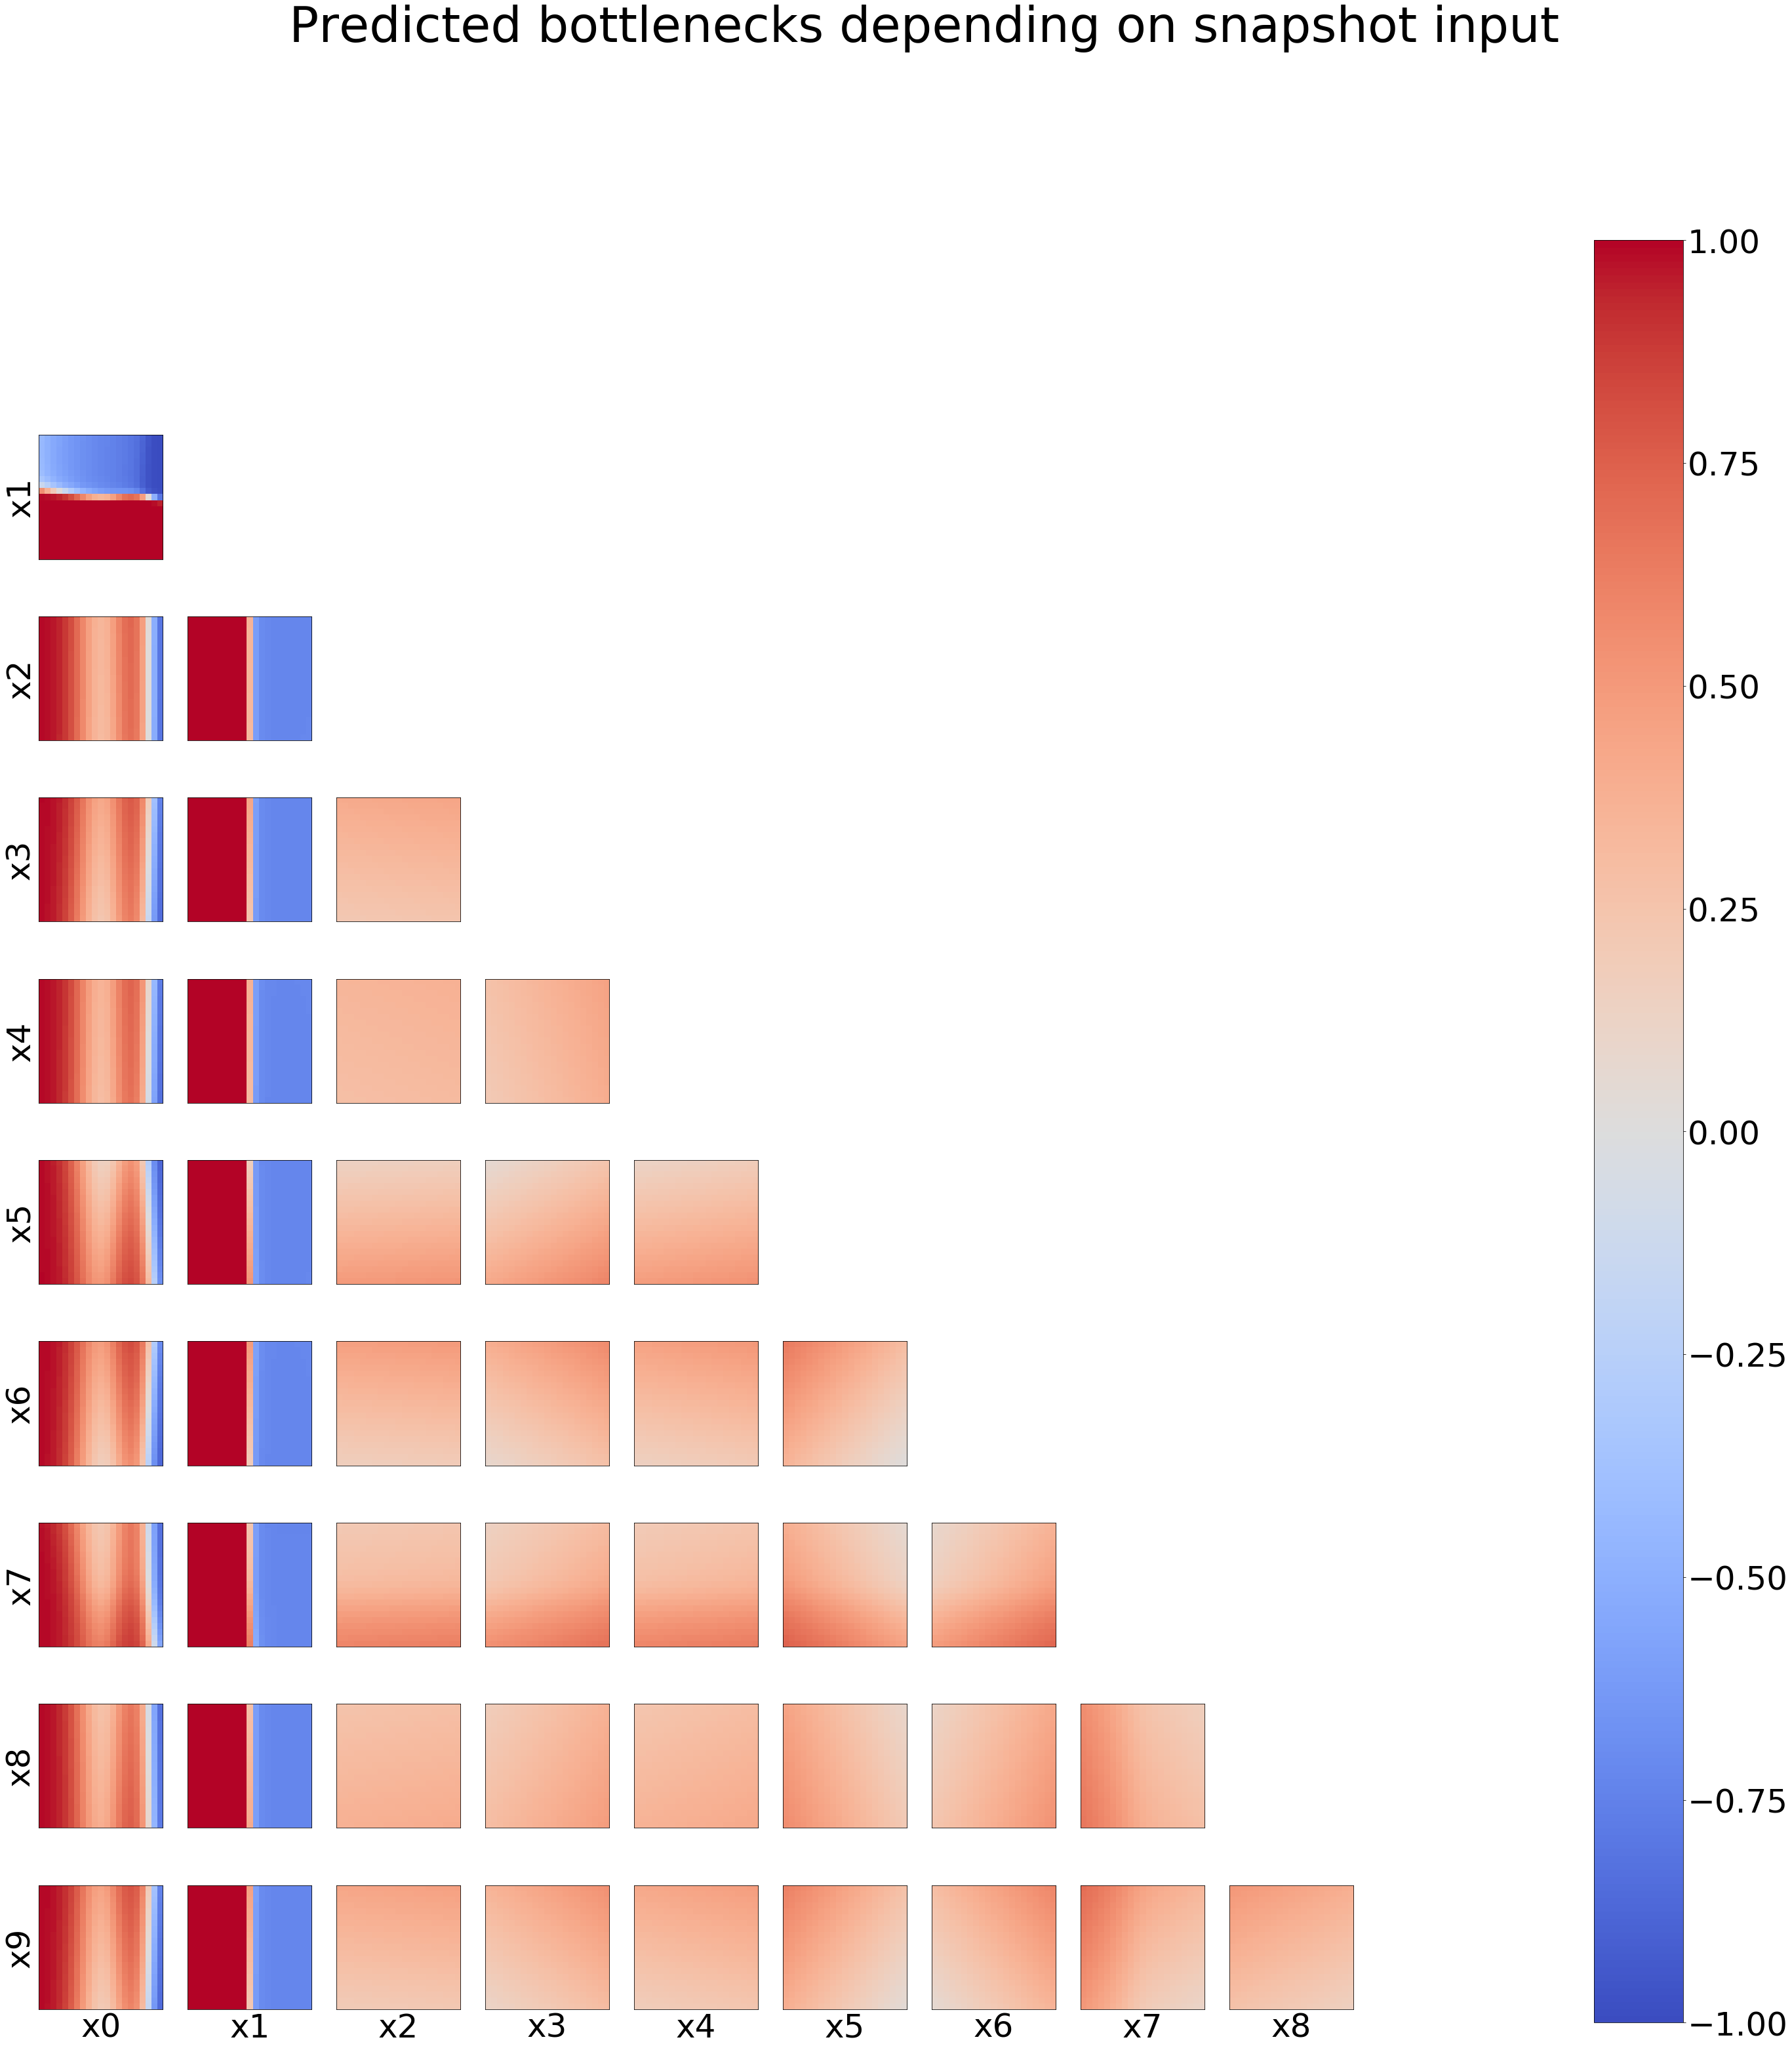

1


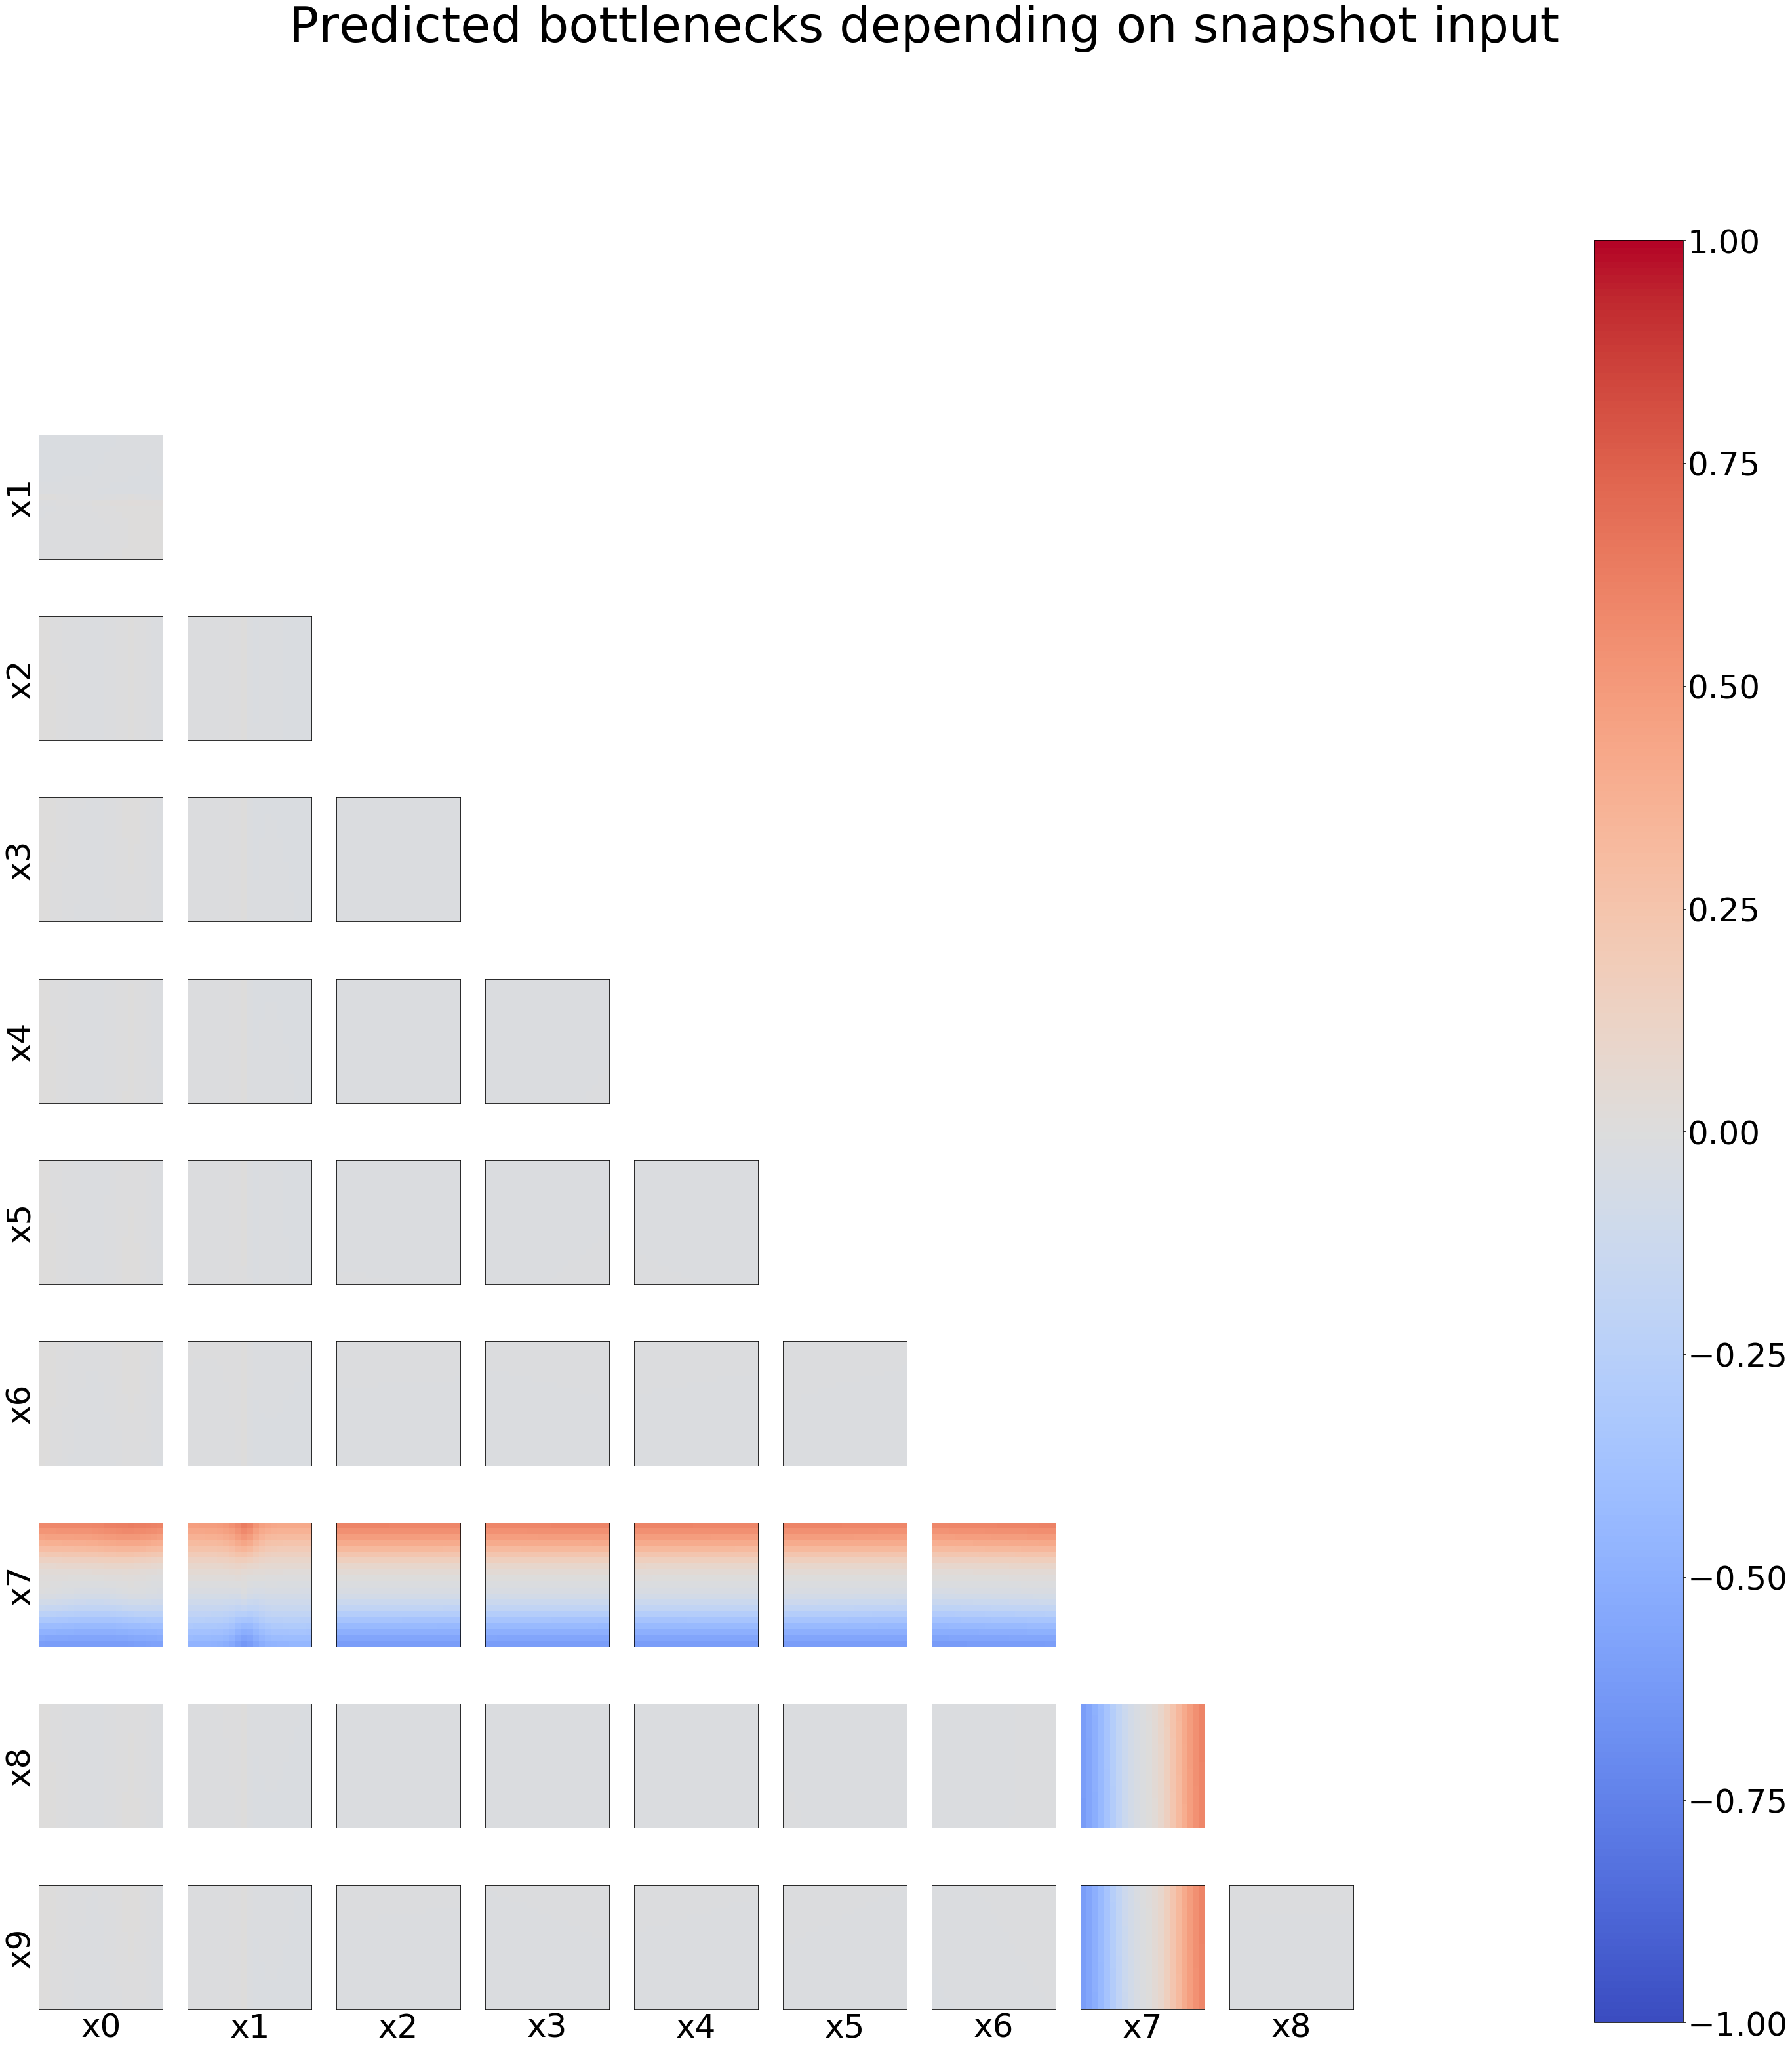

0 1
0


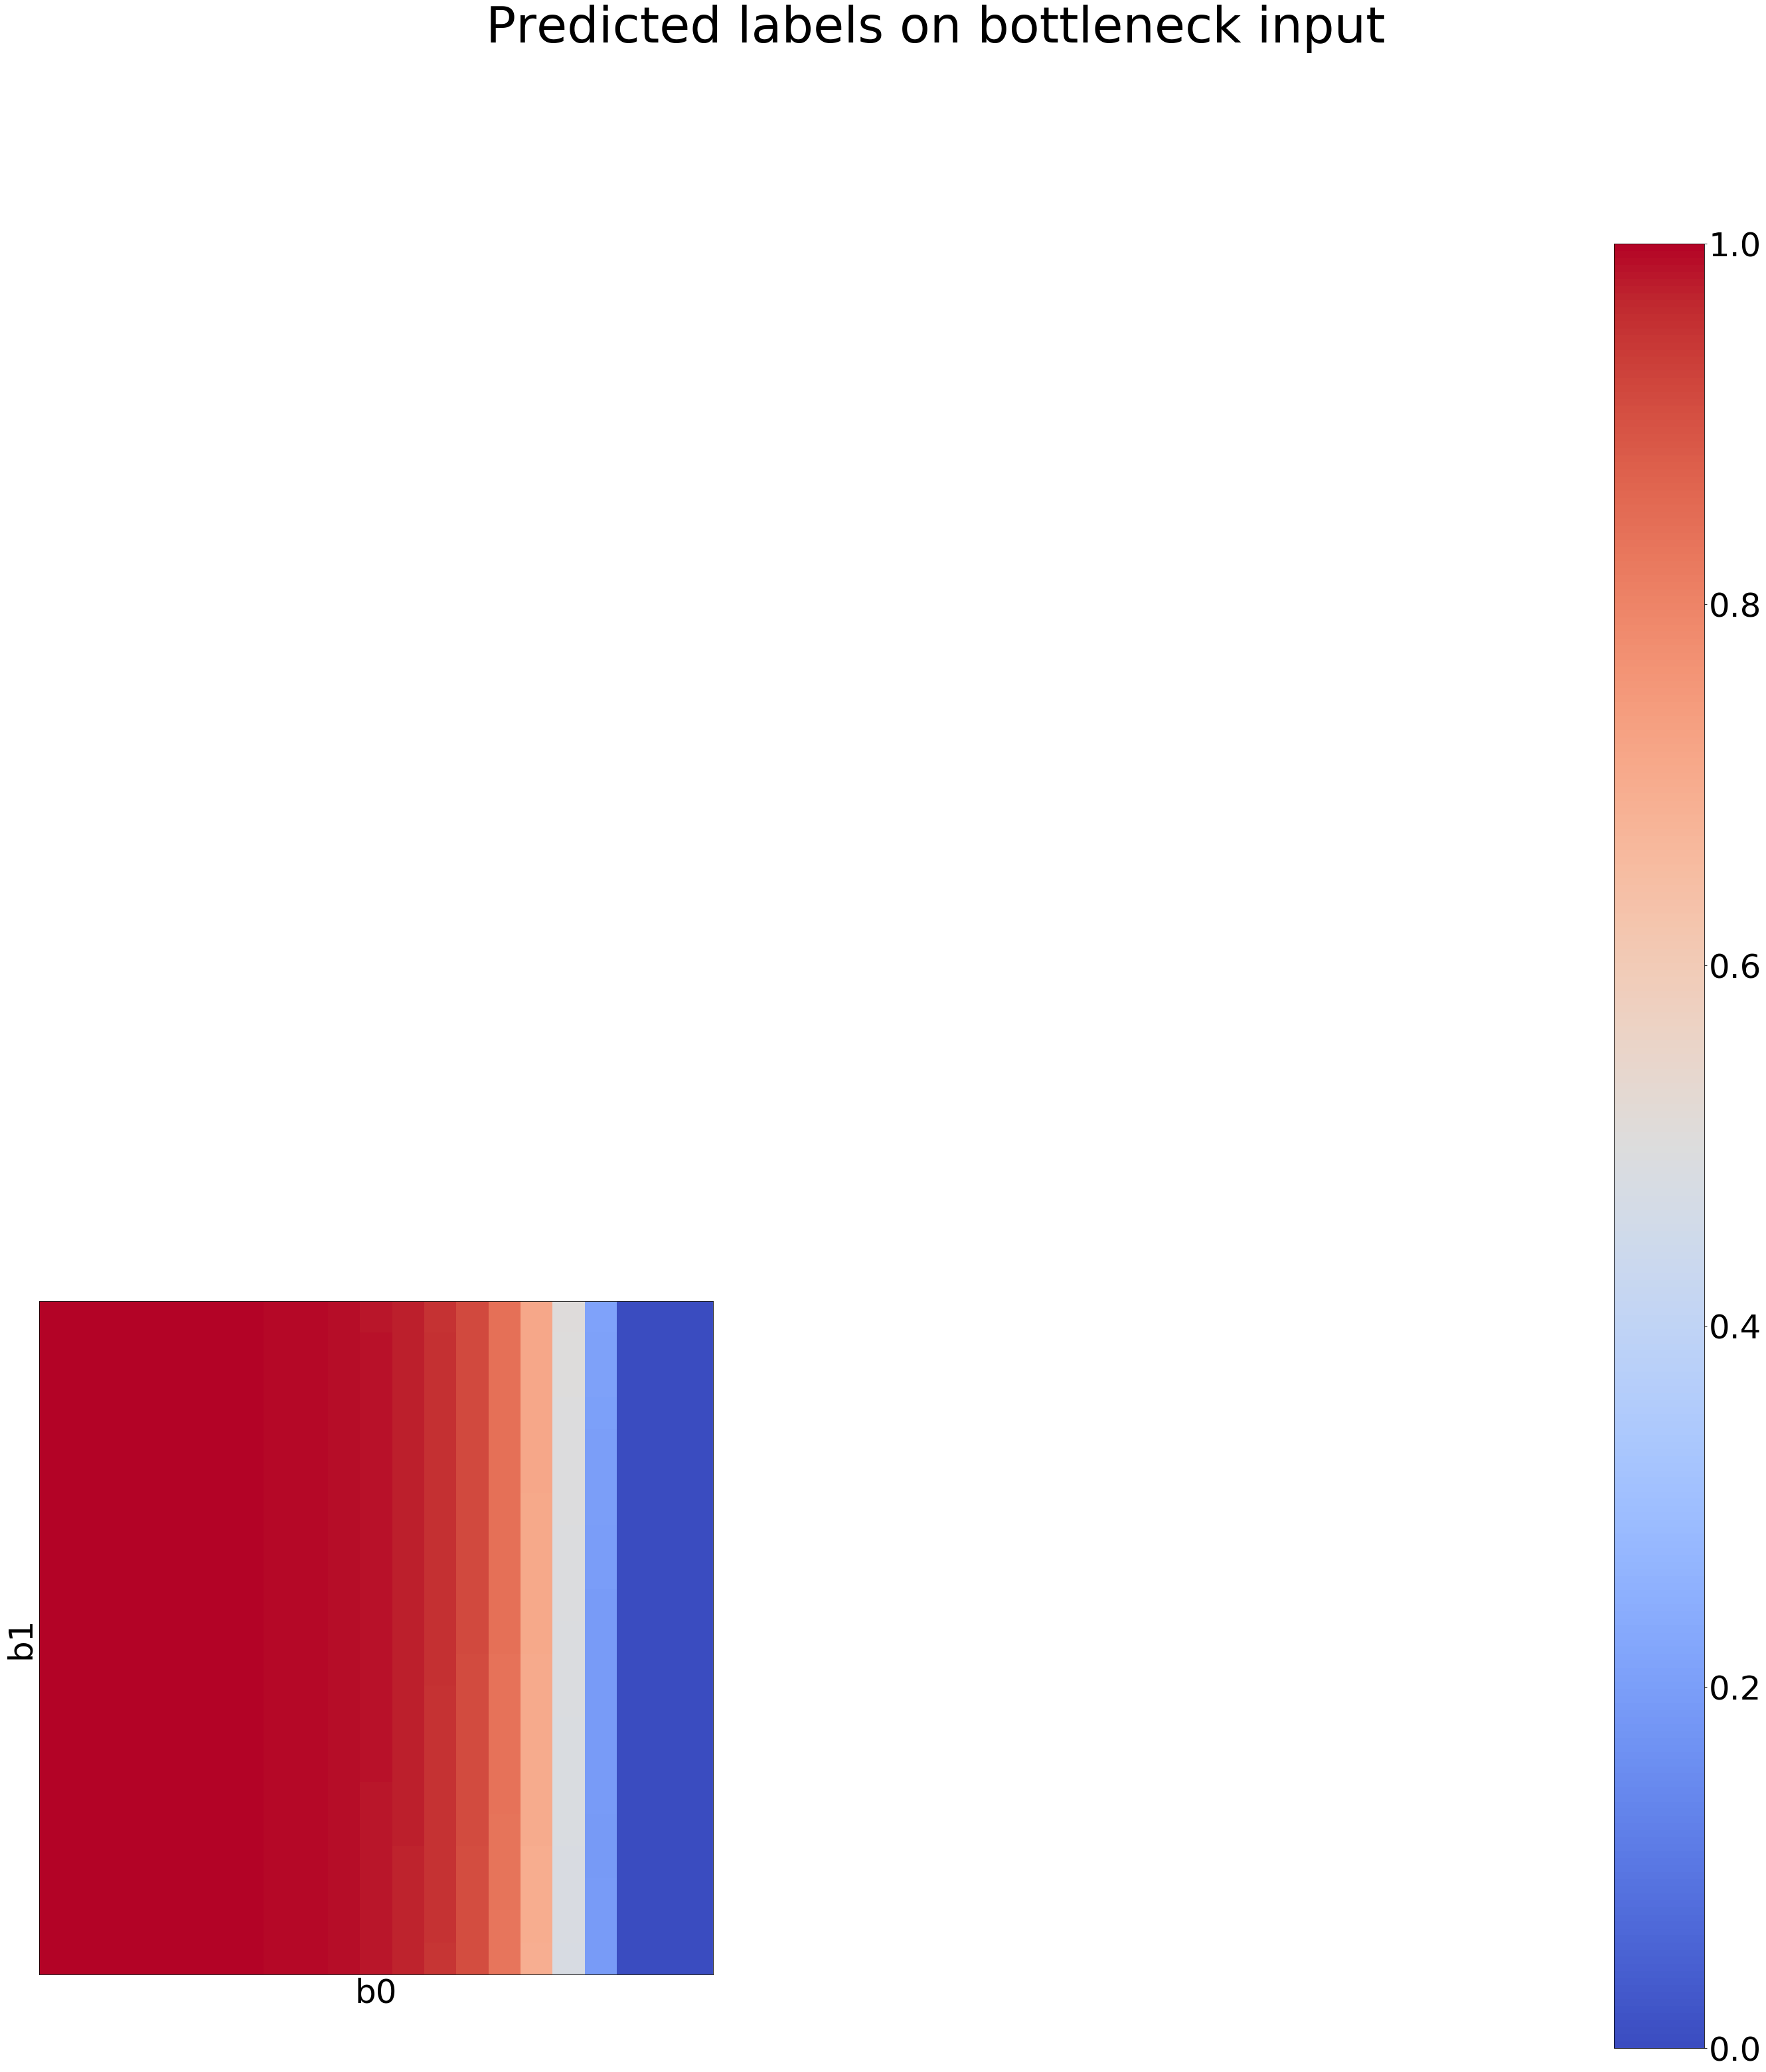

0 1
0


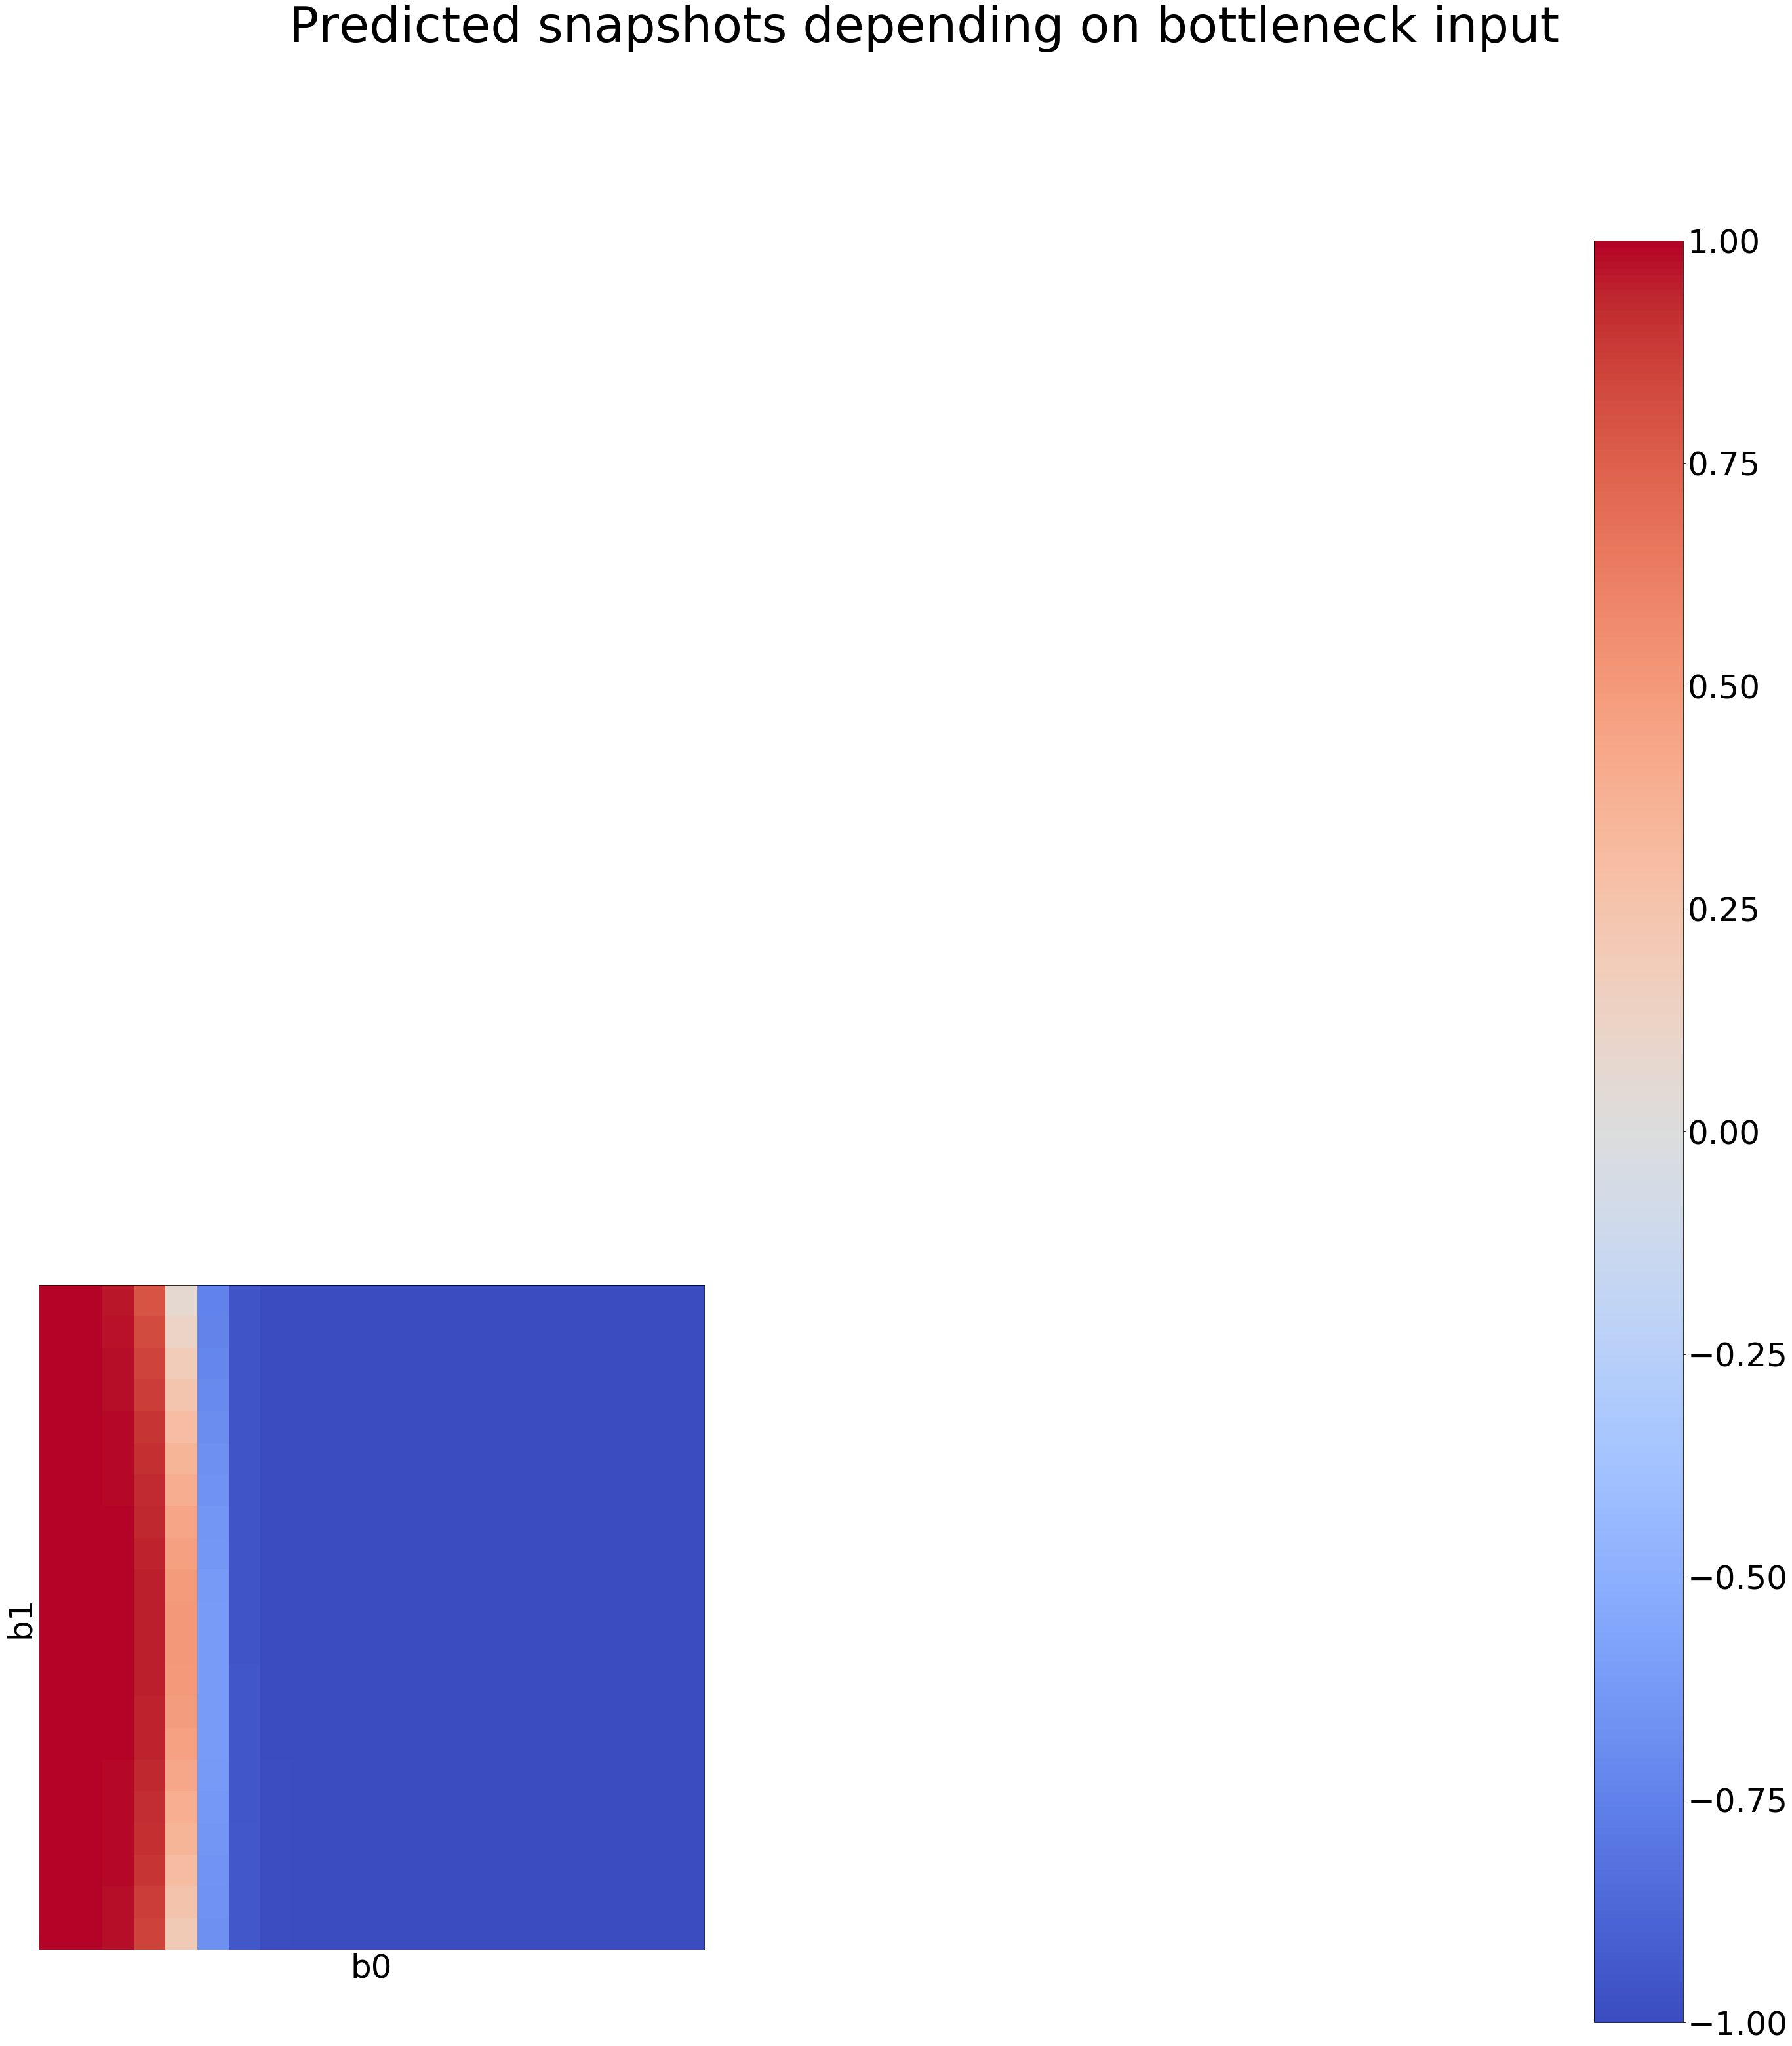

1


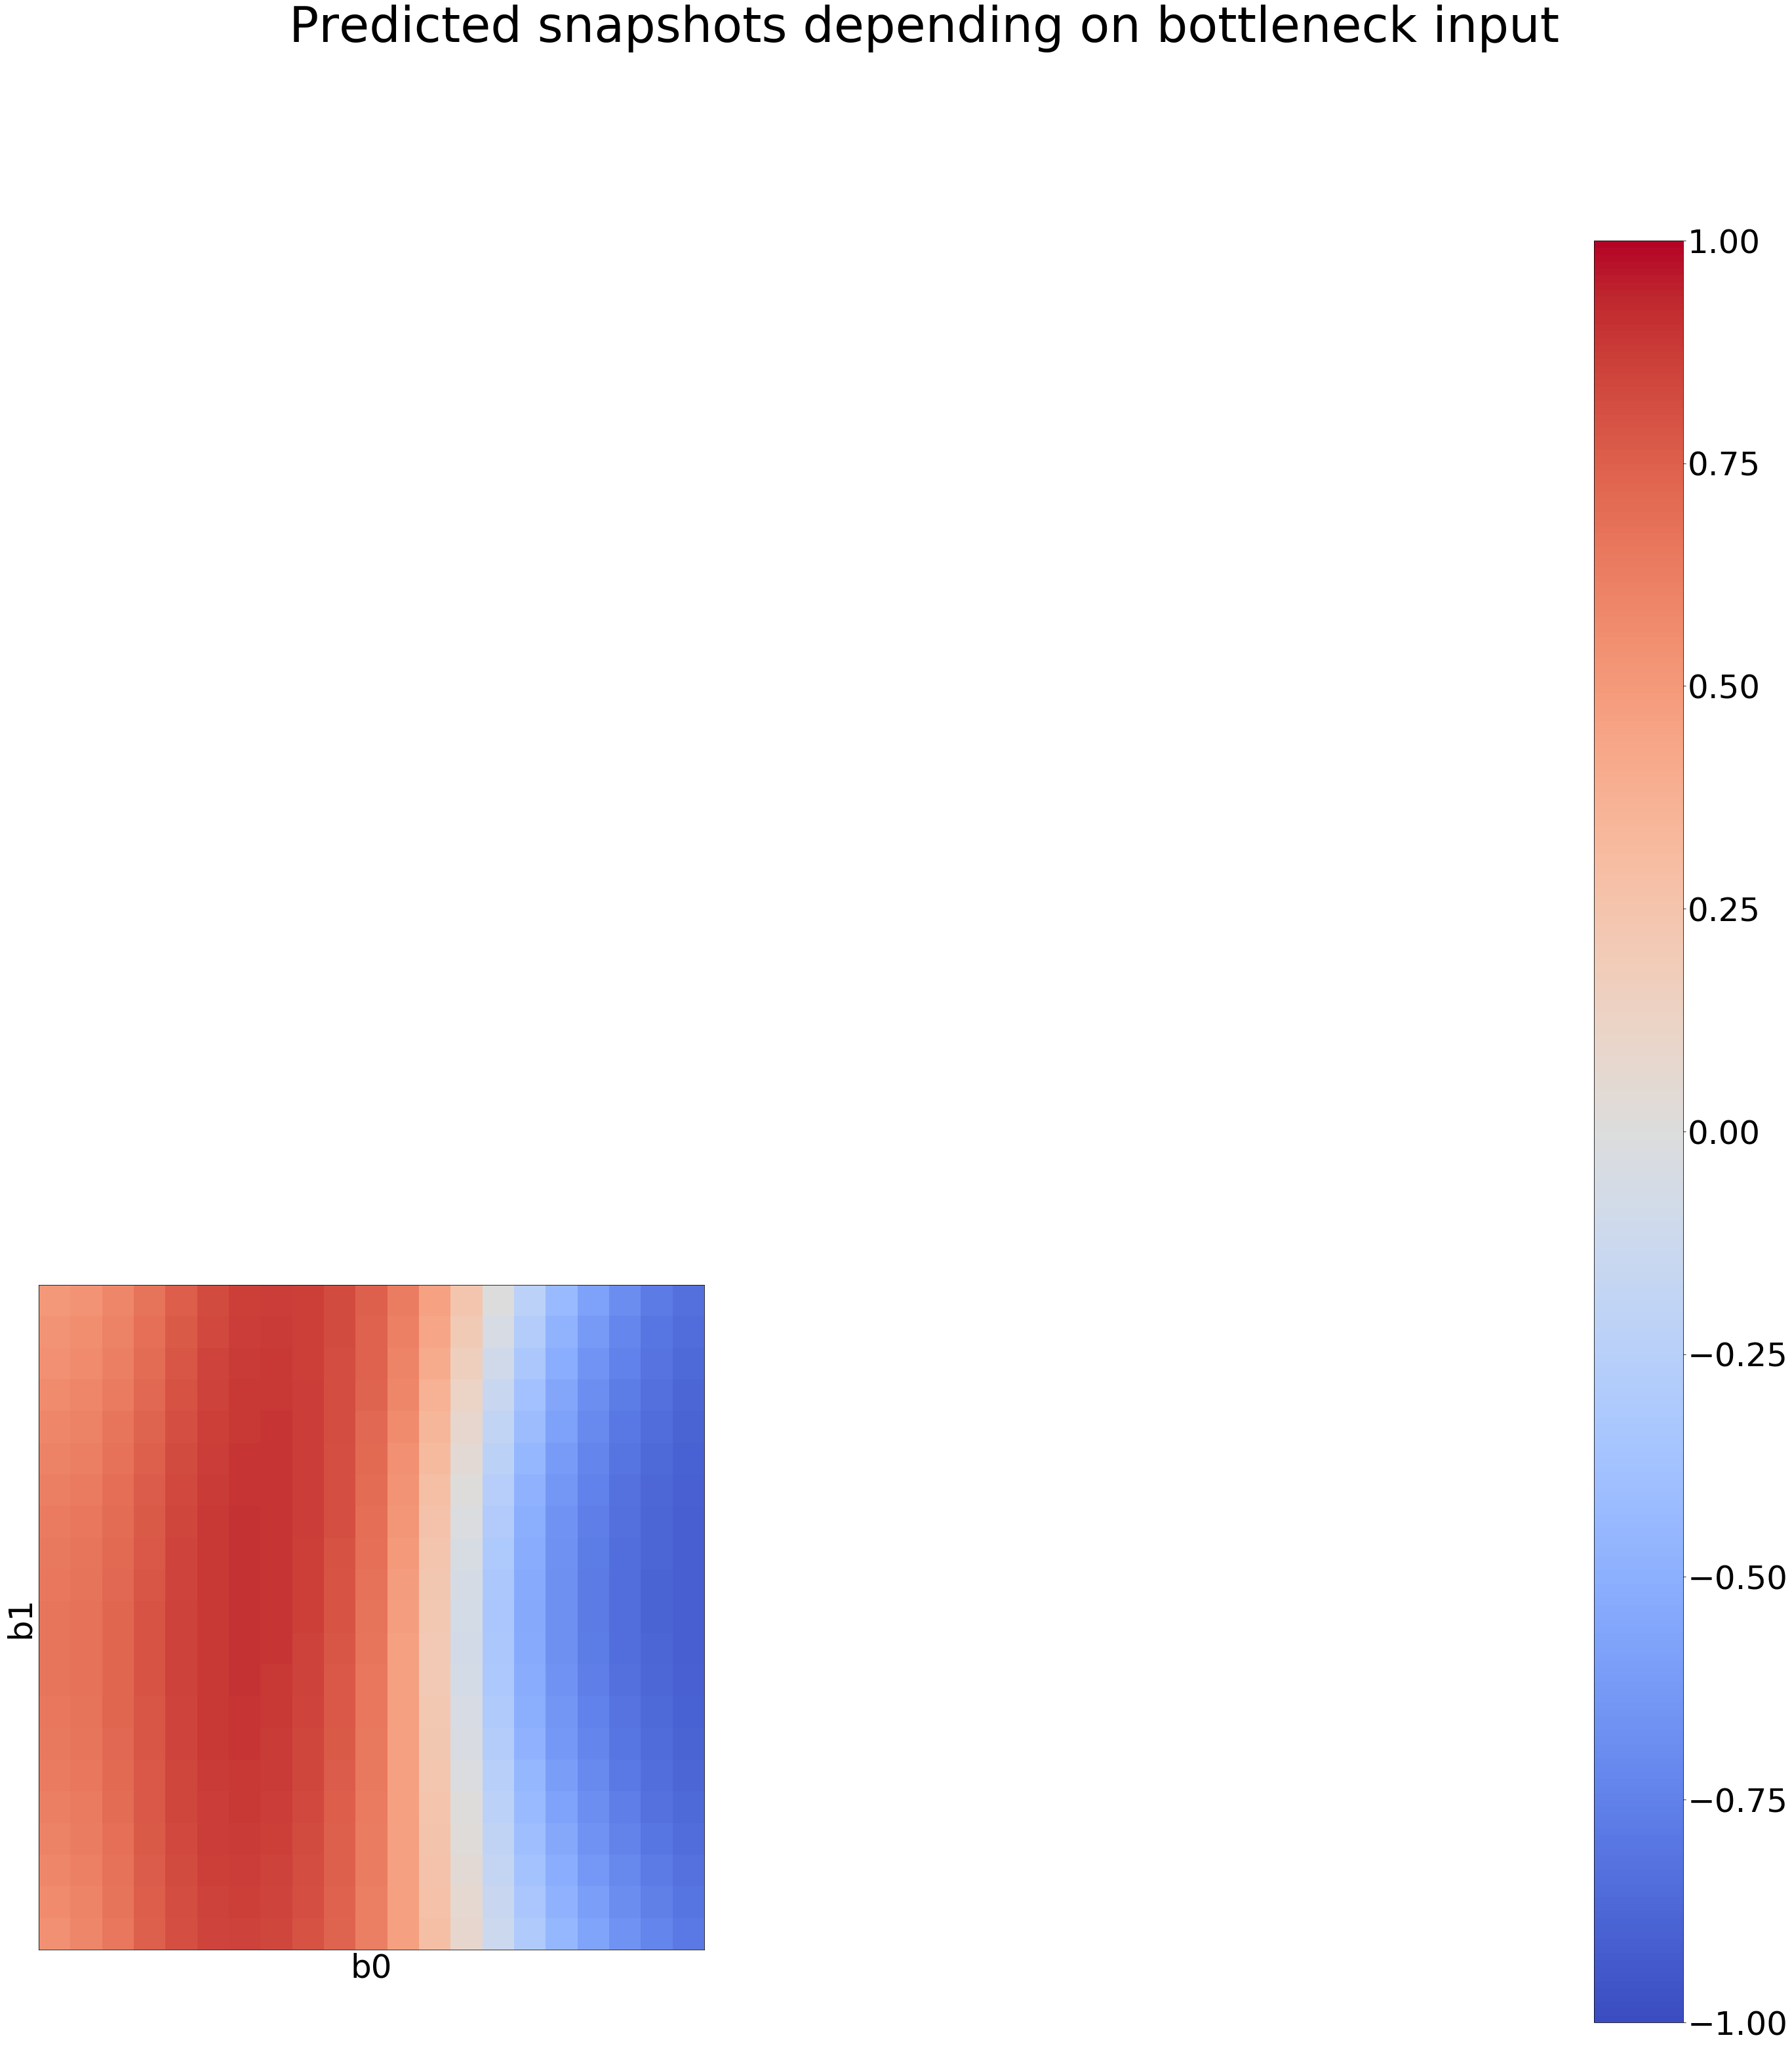

2


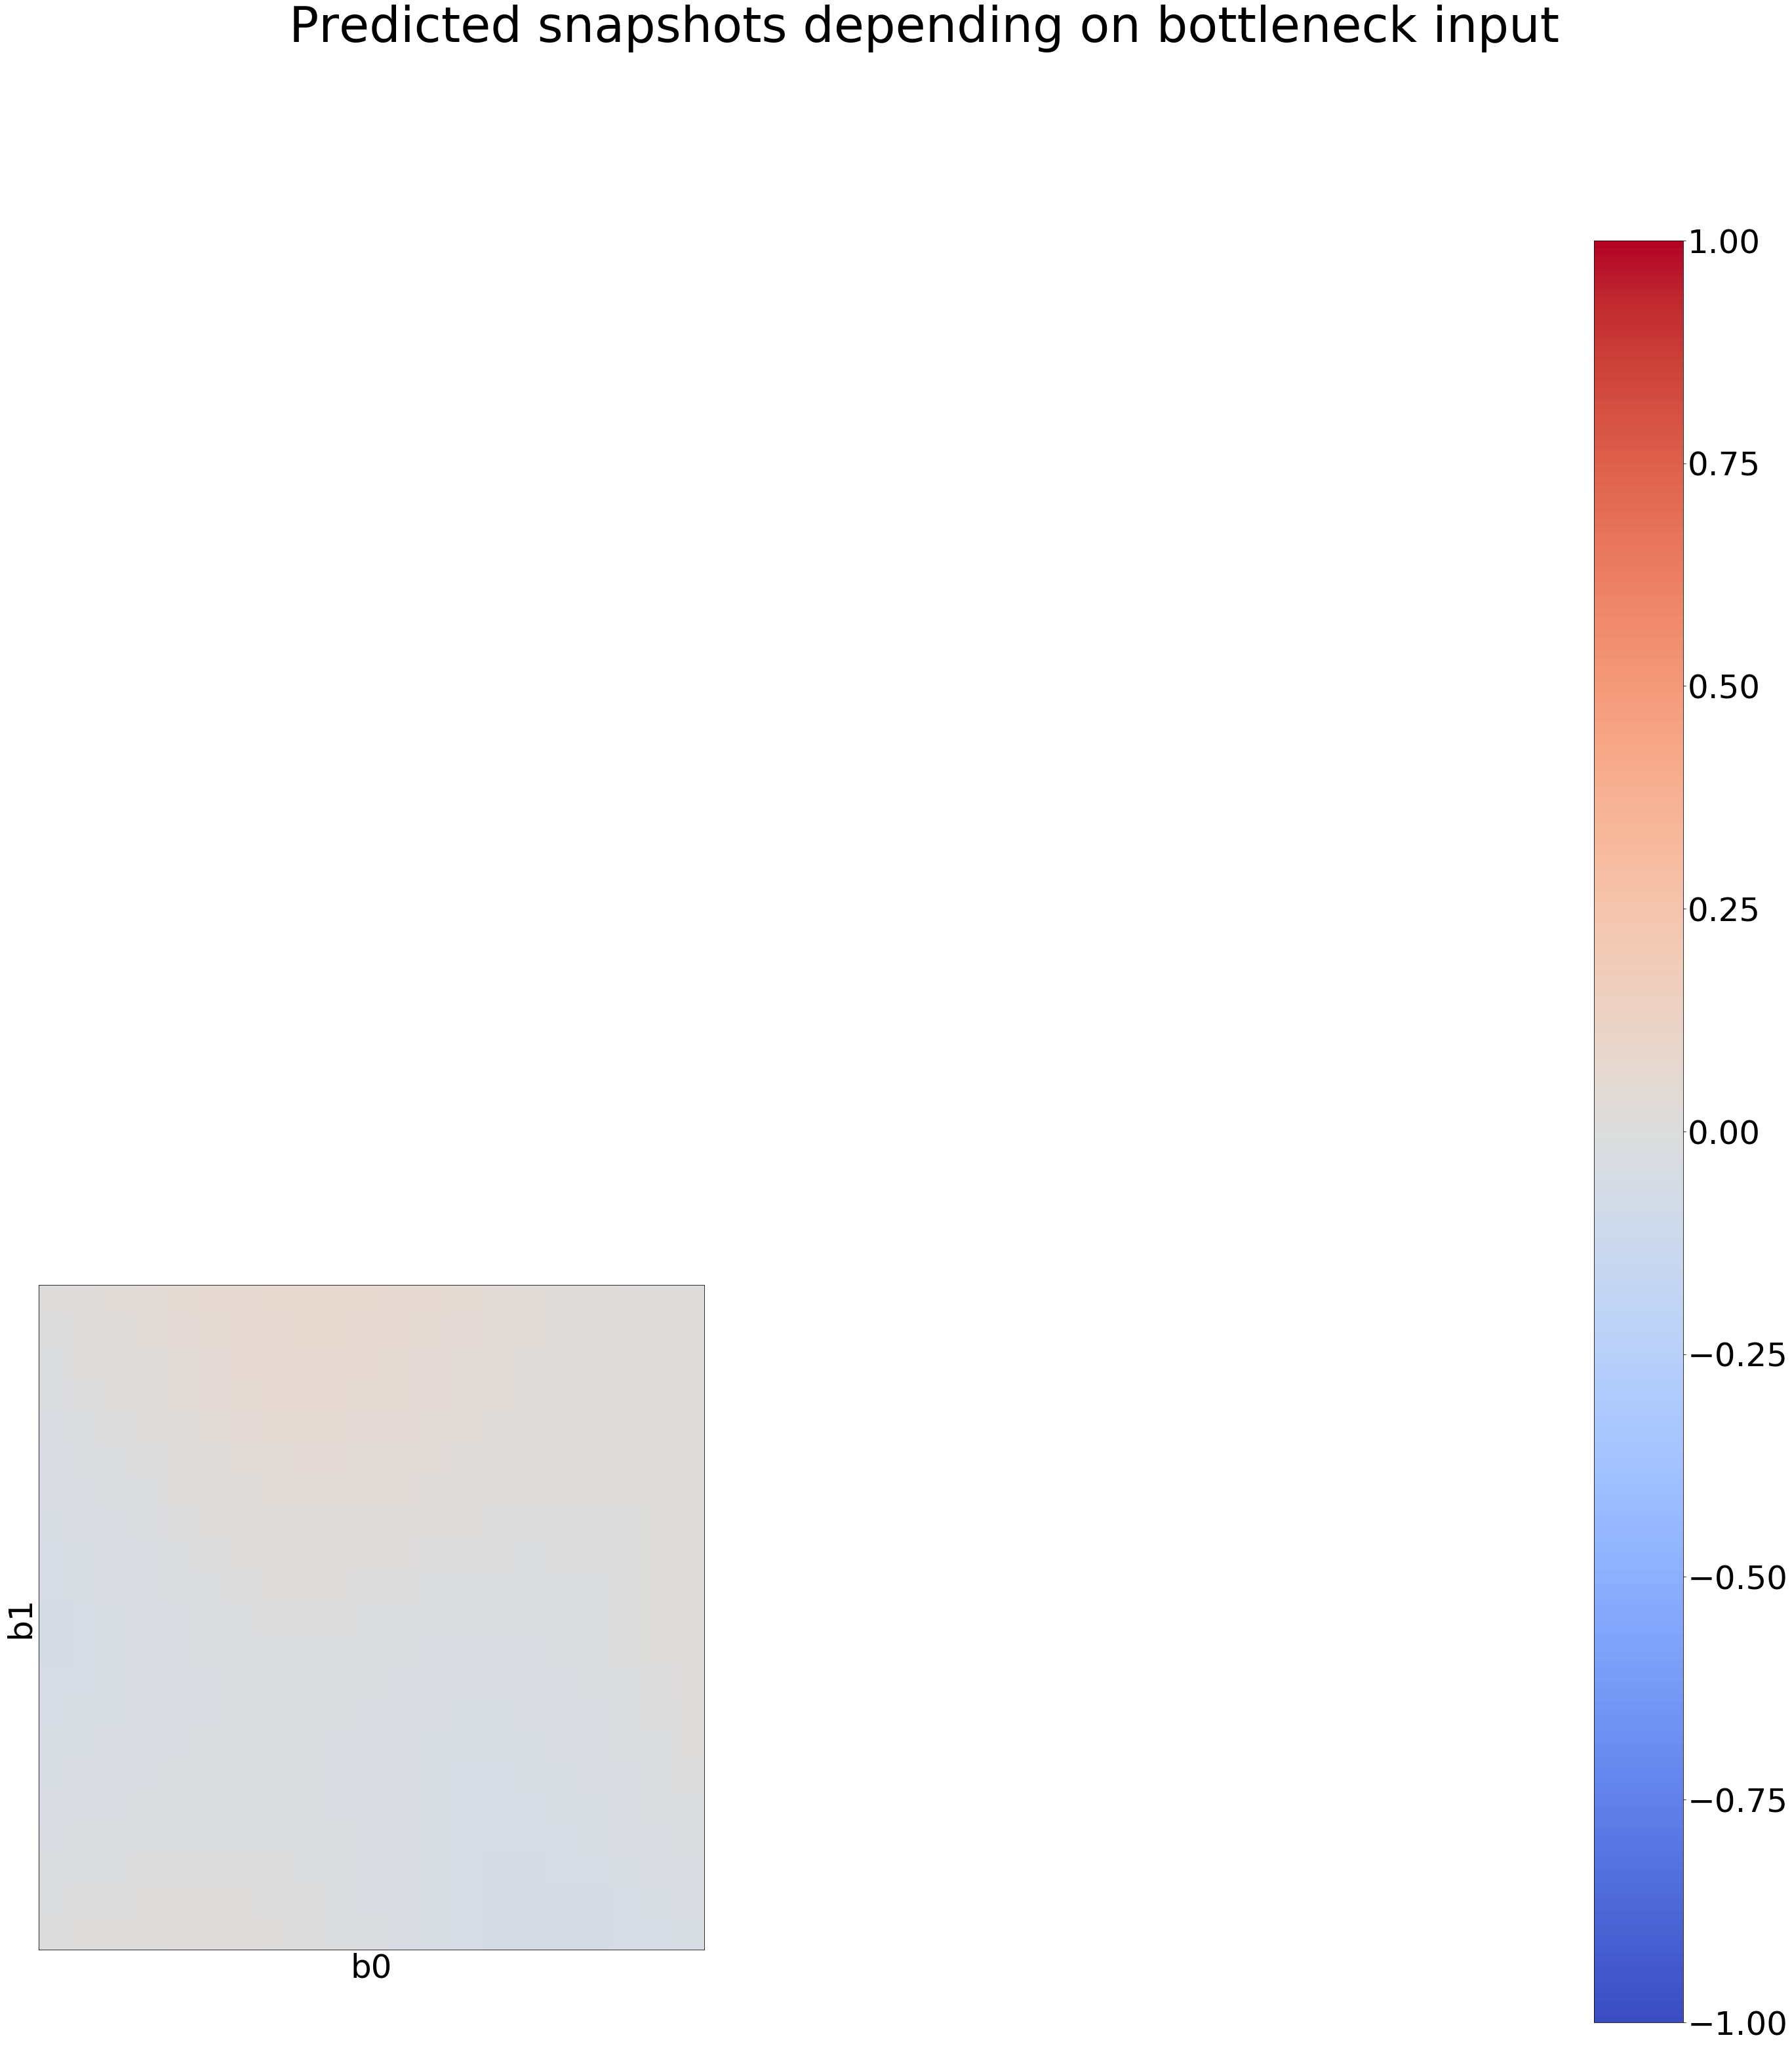

3


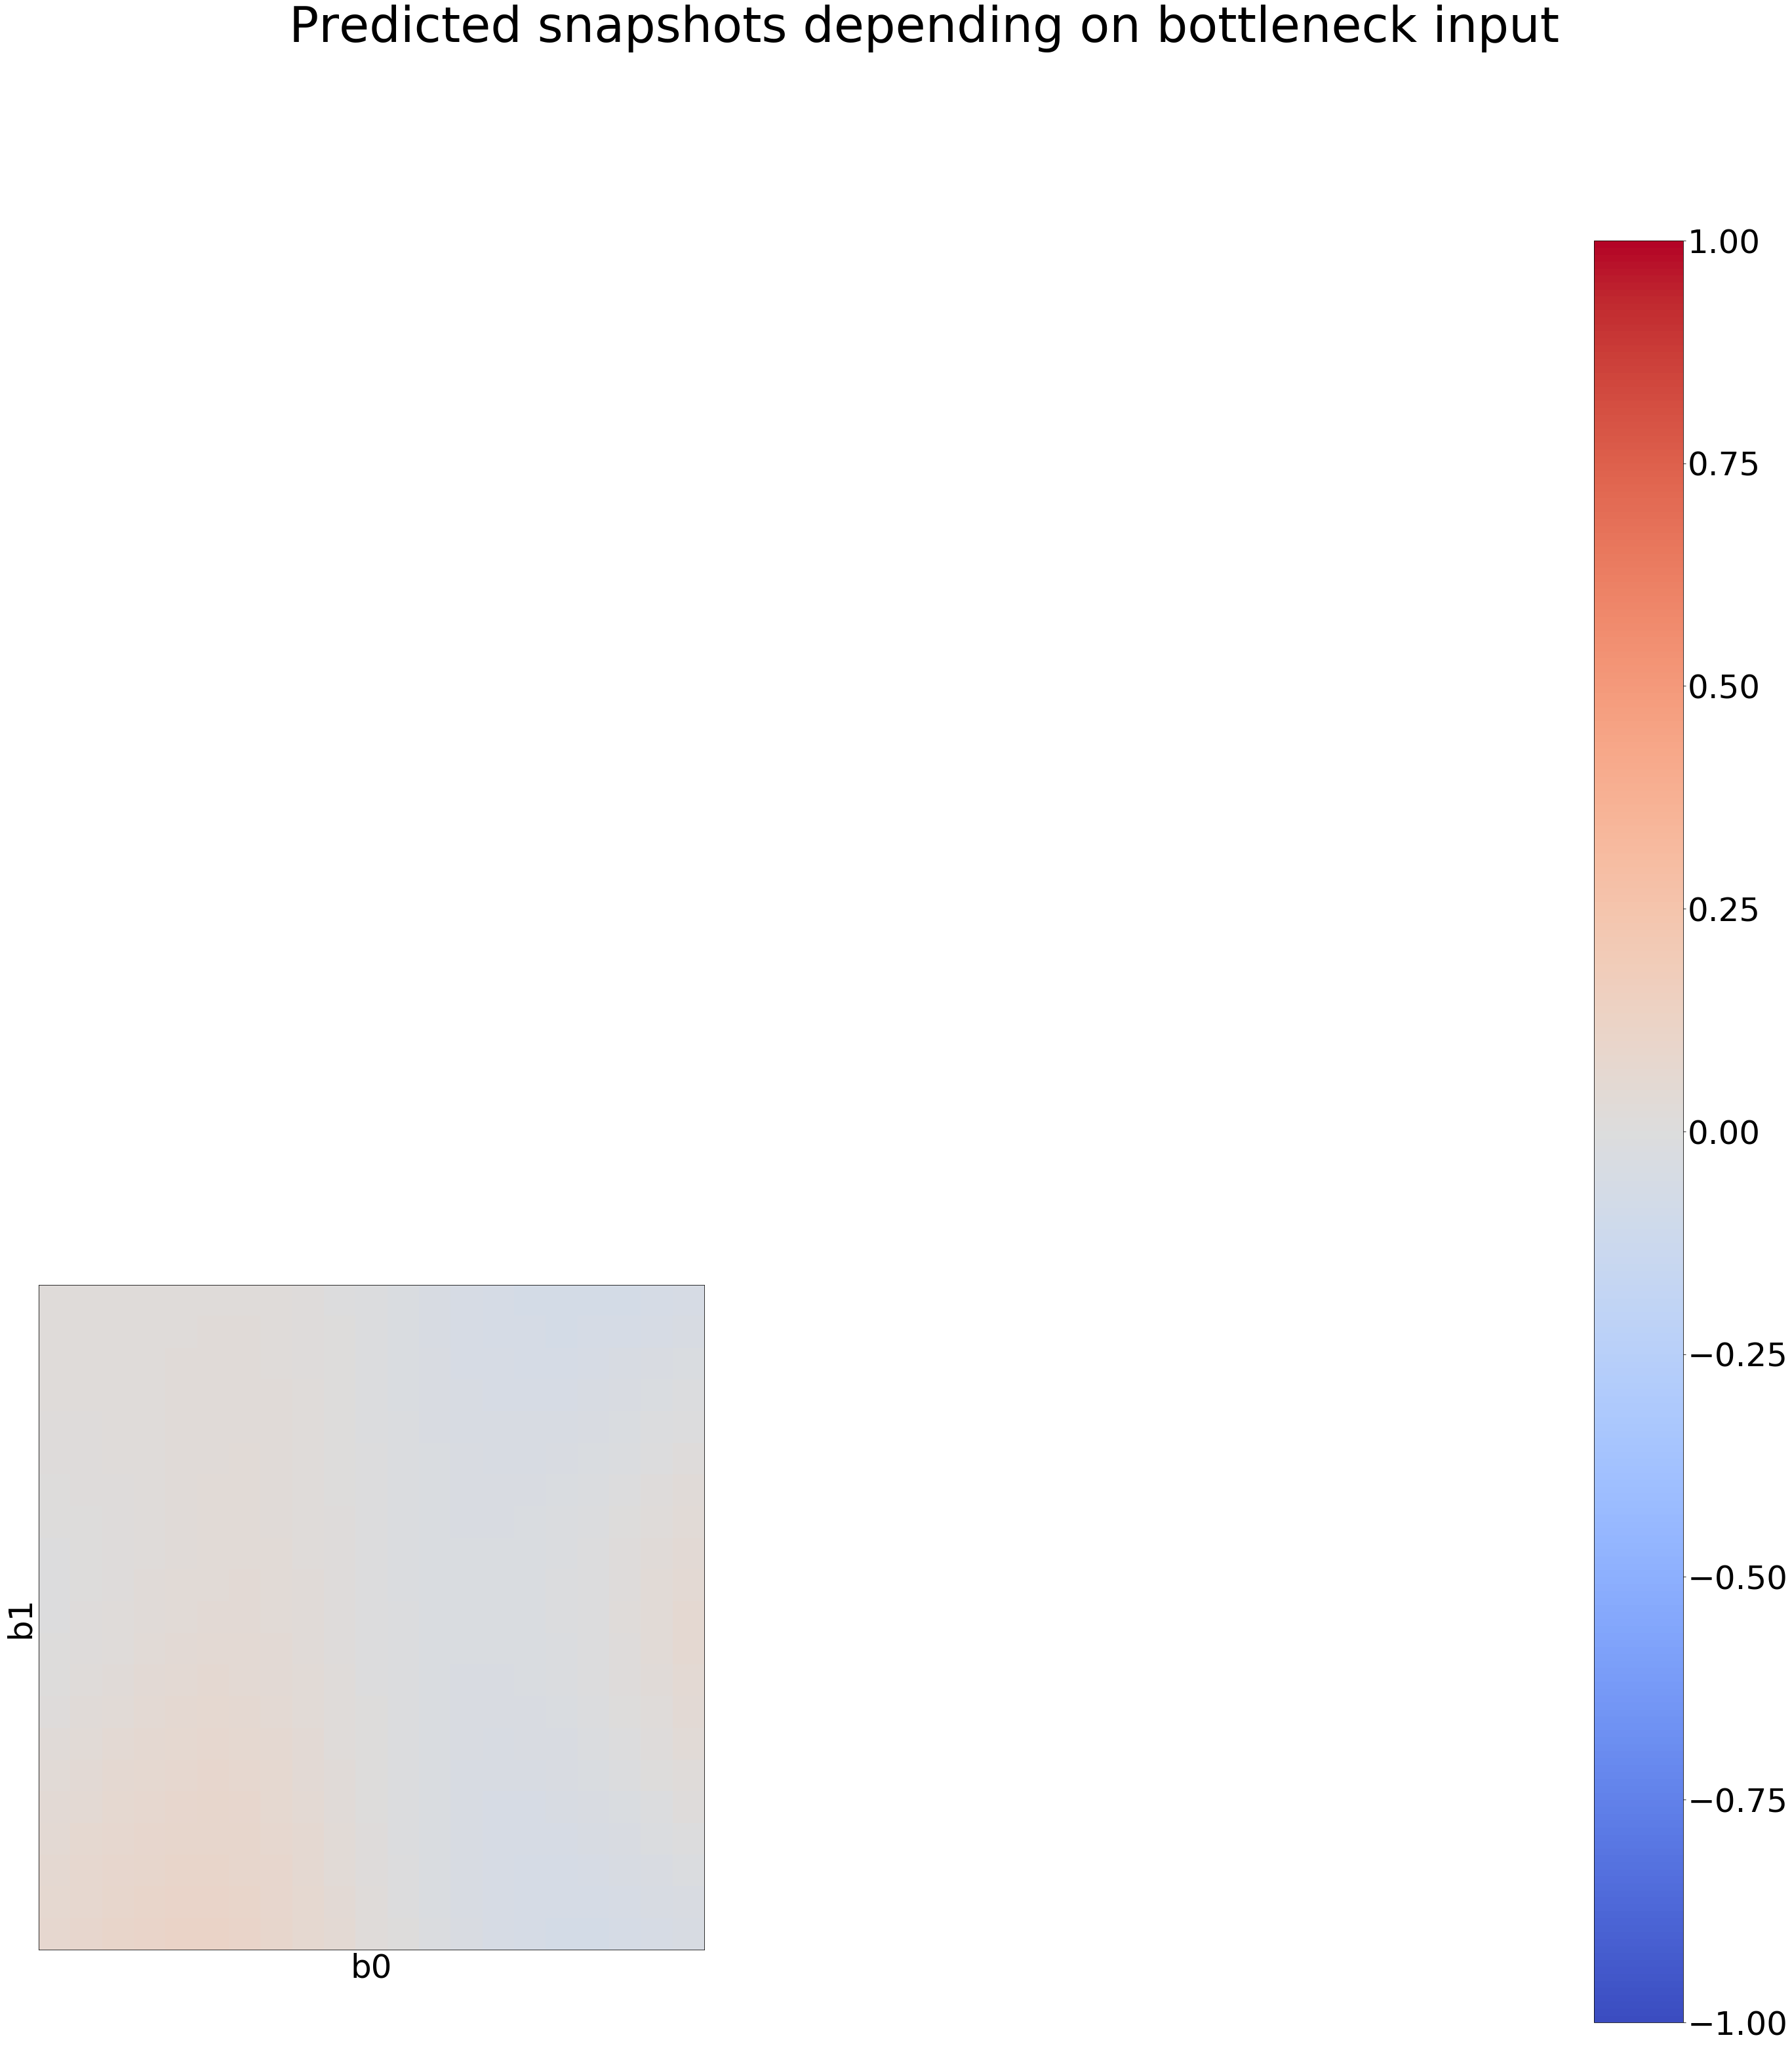

4


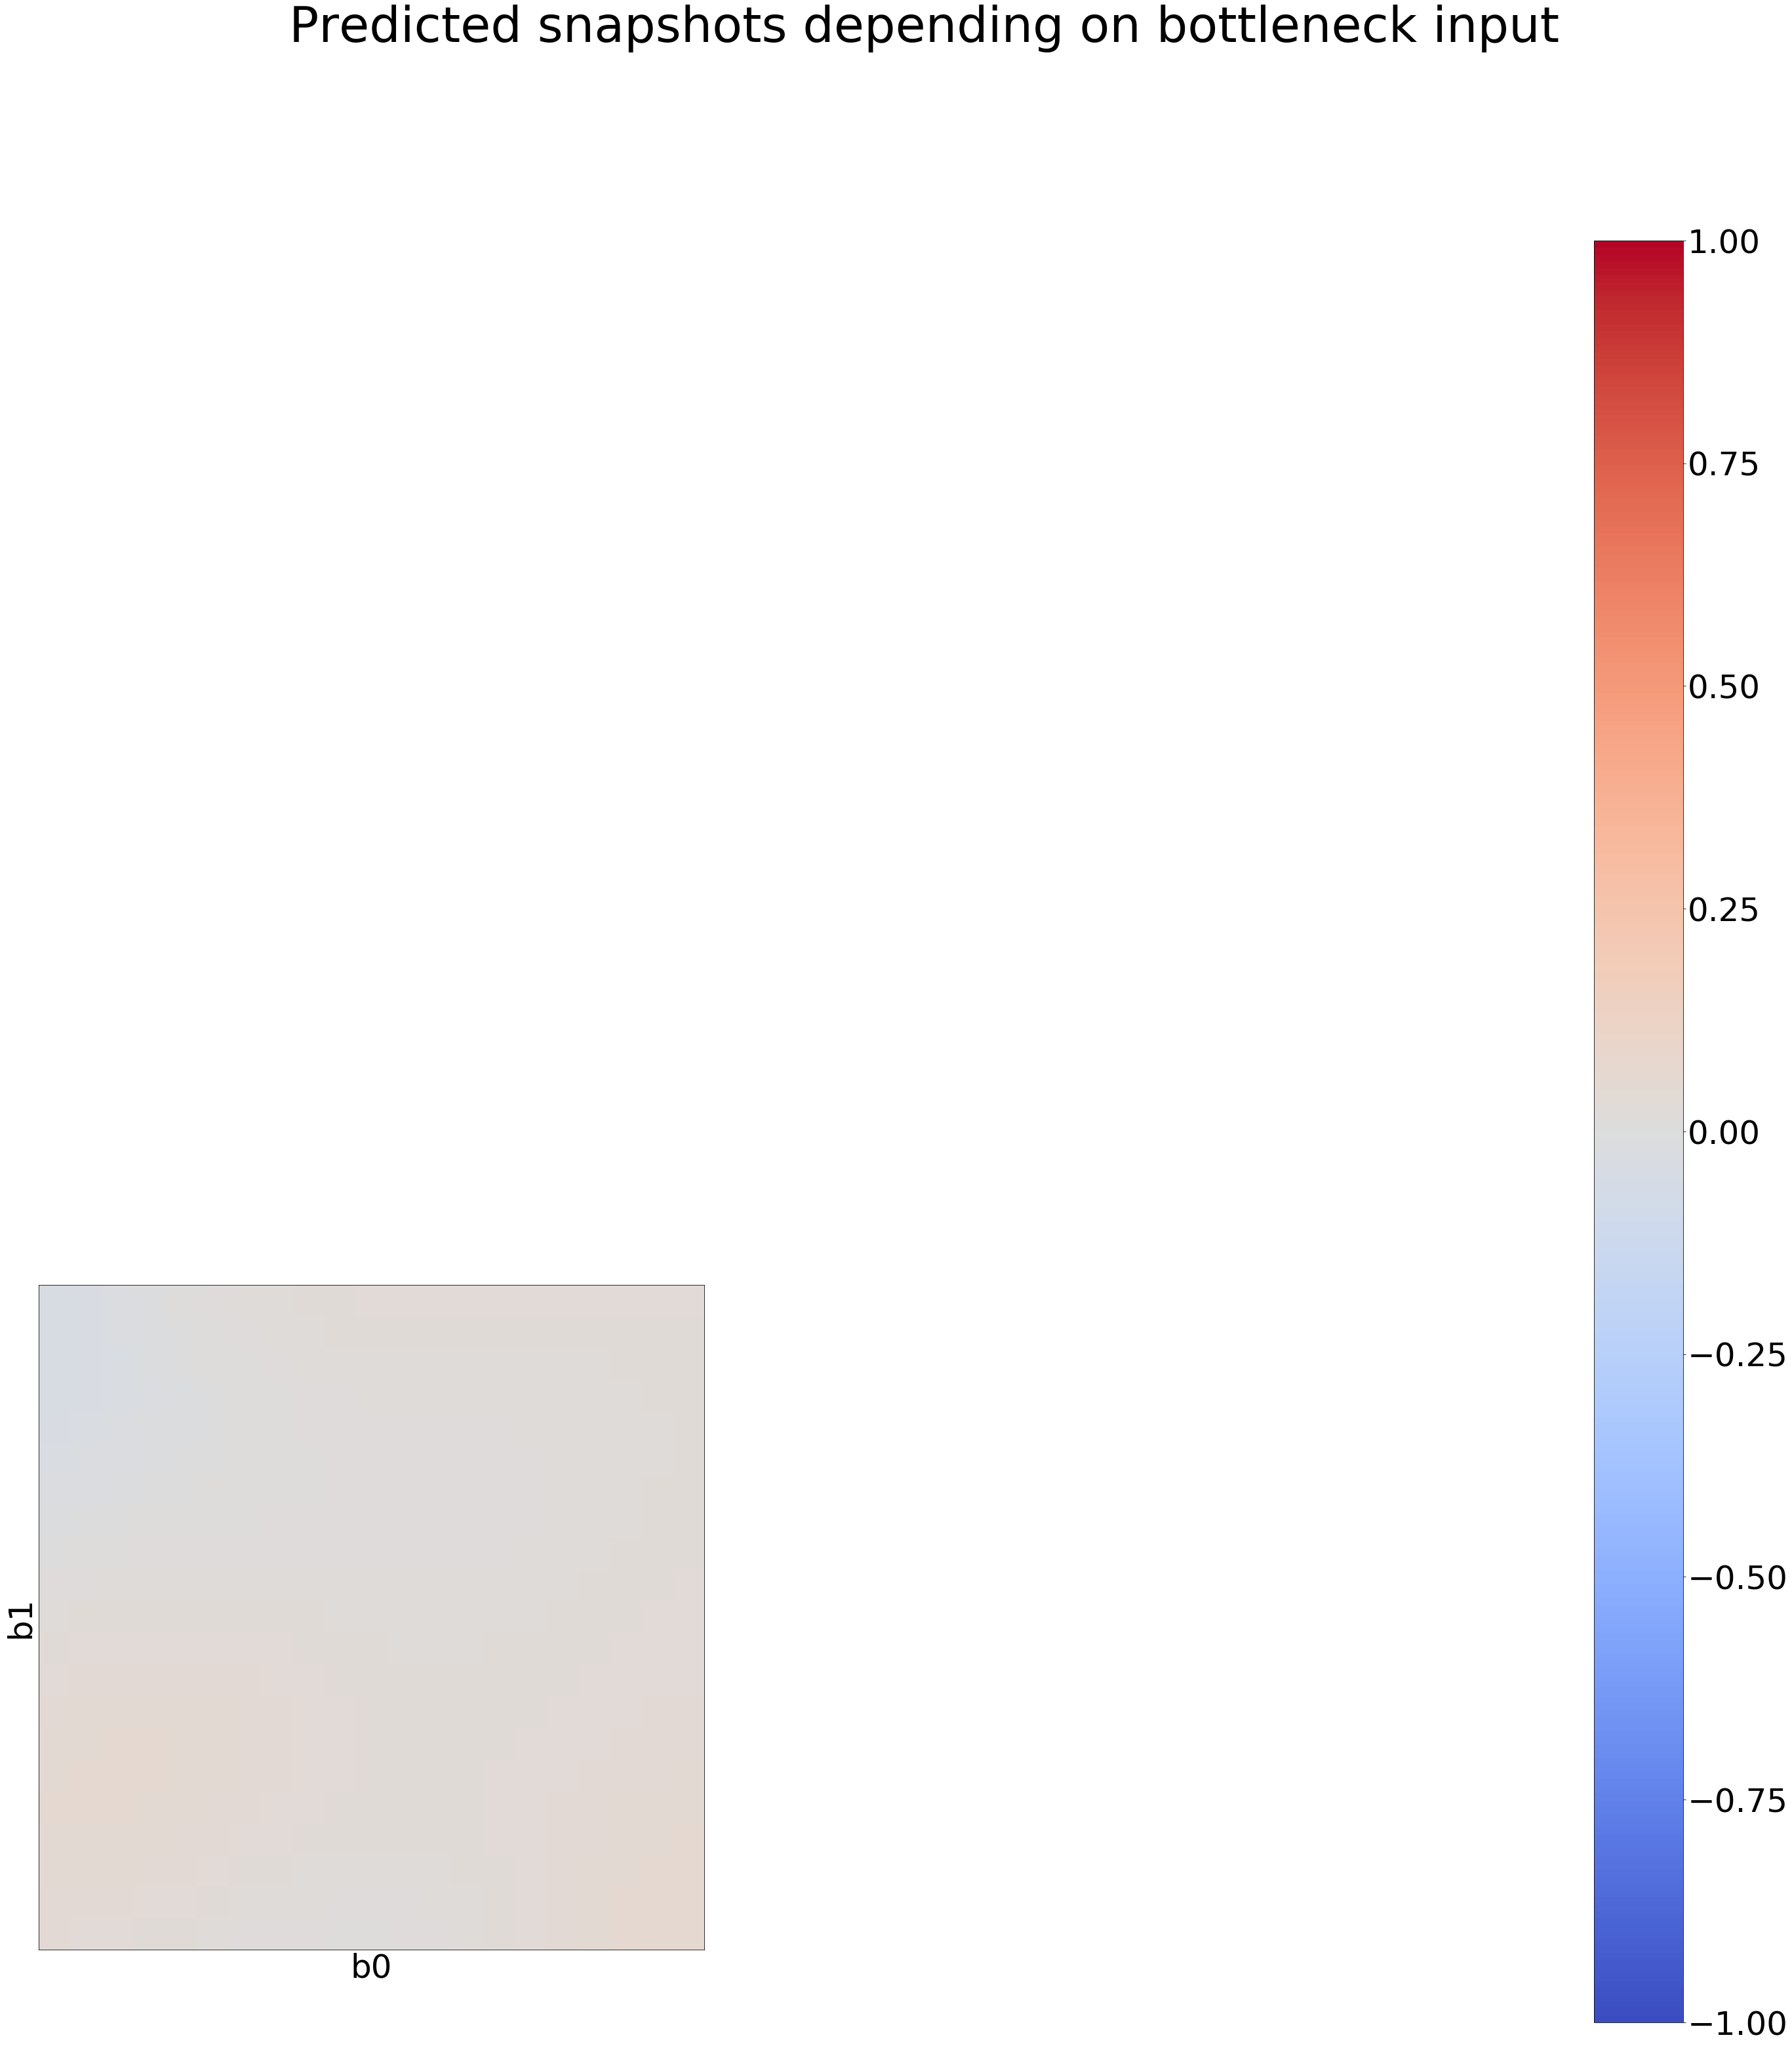

5


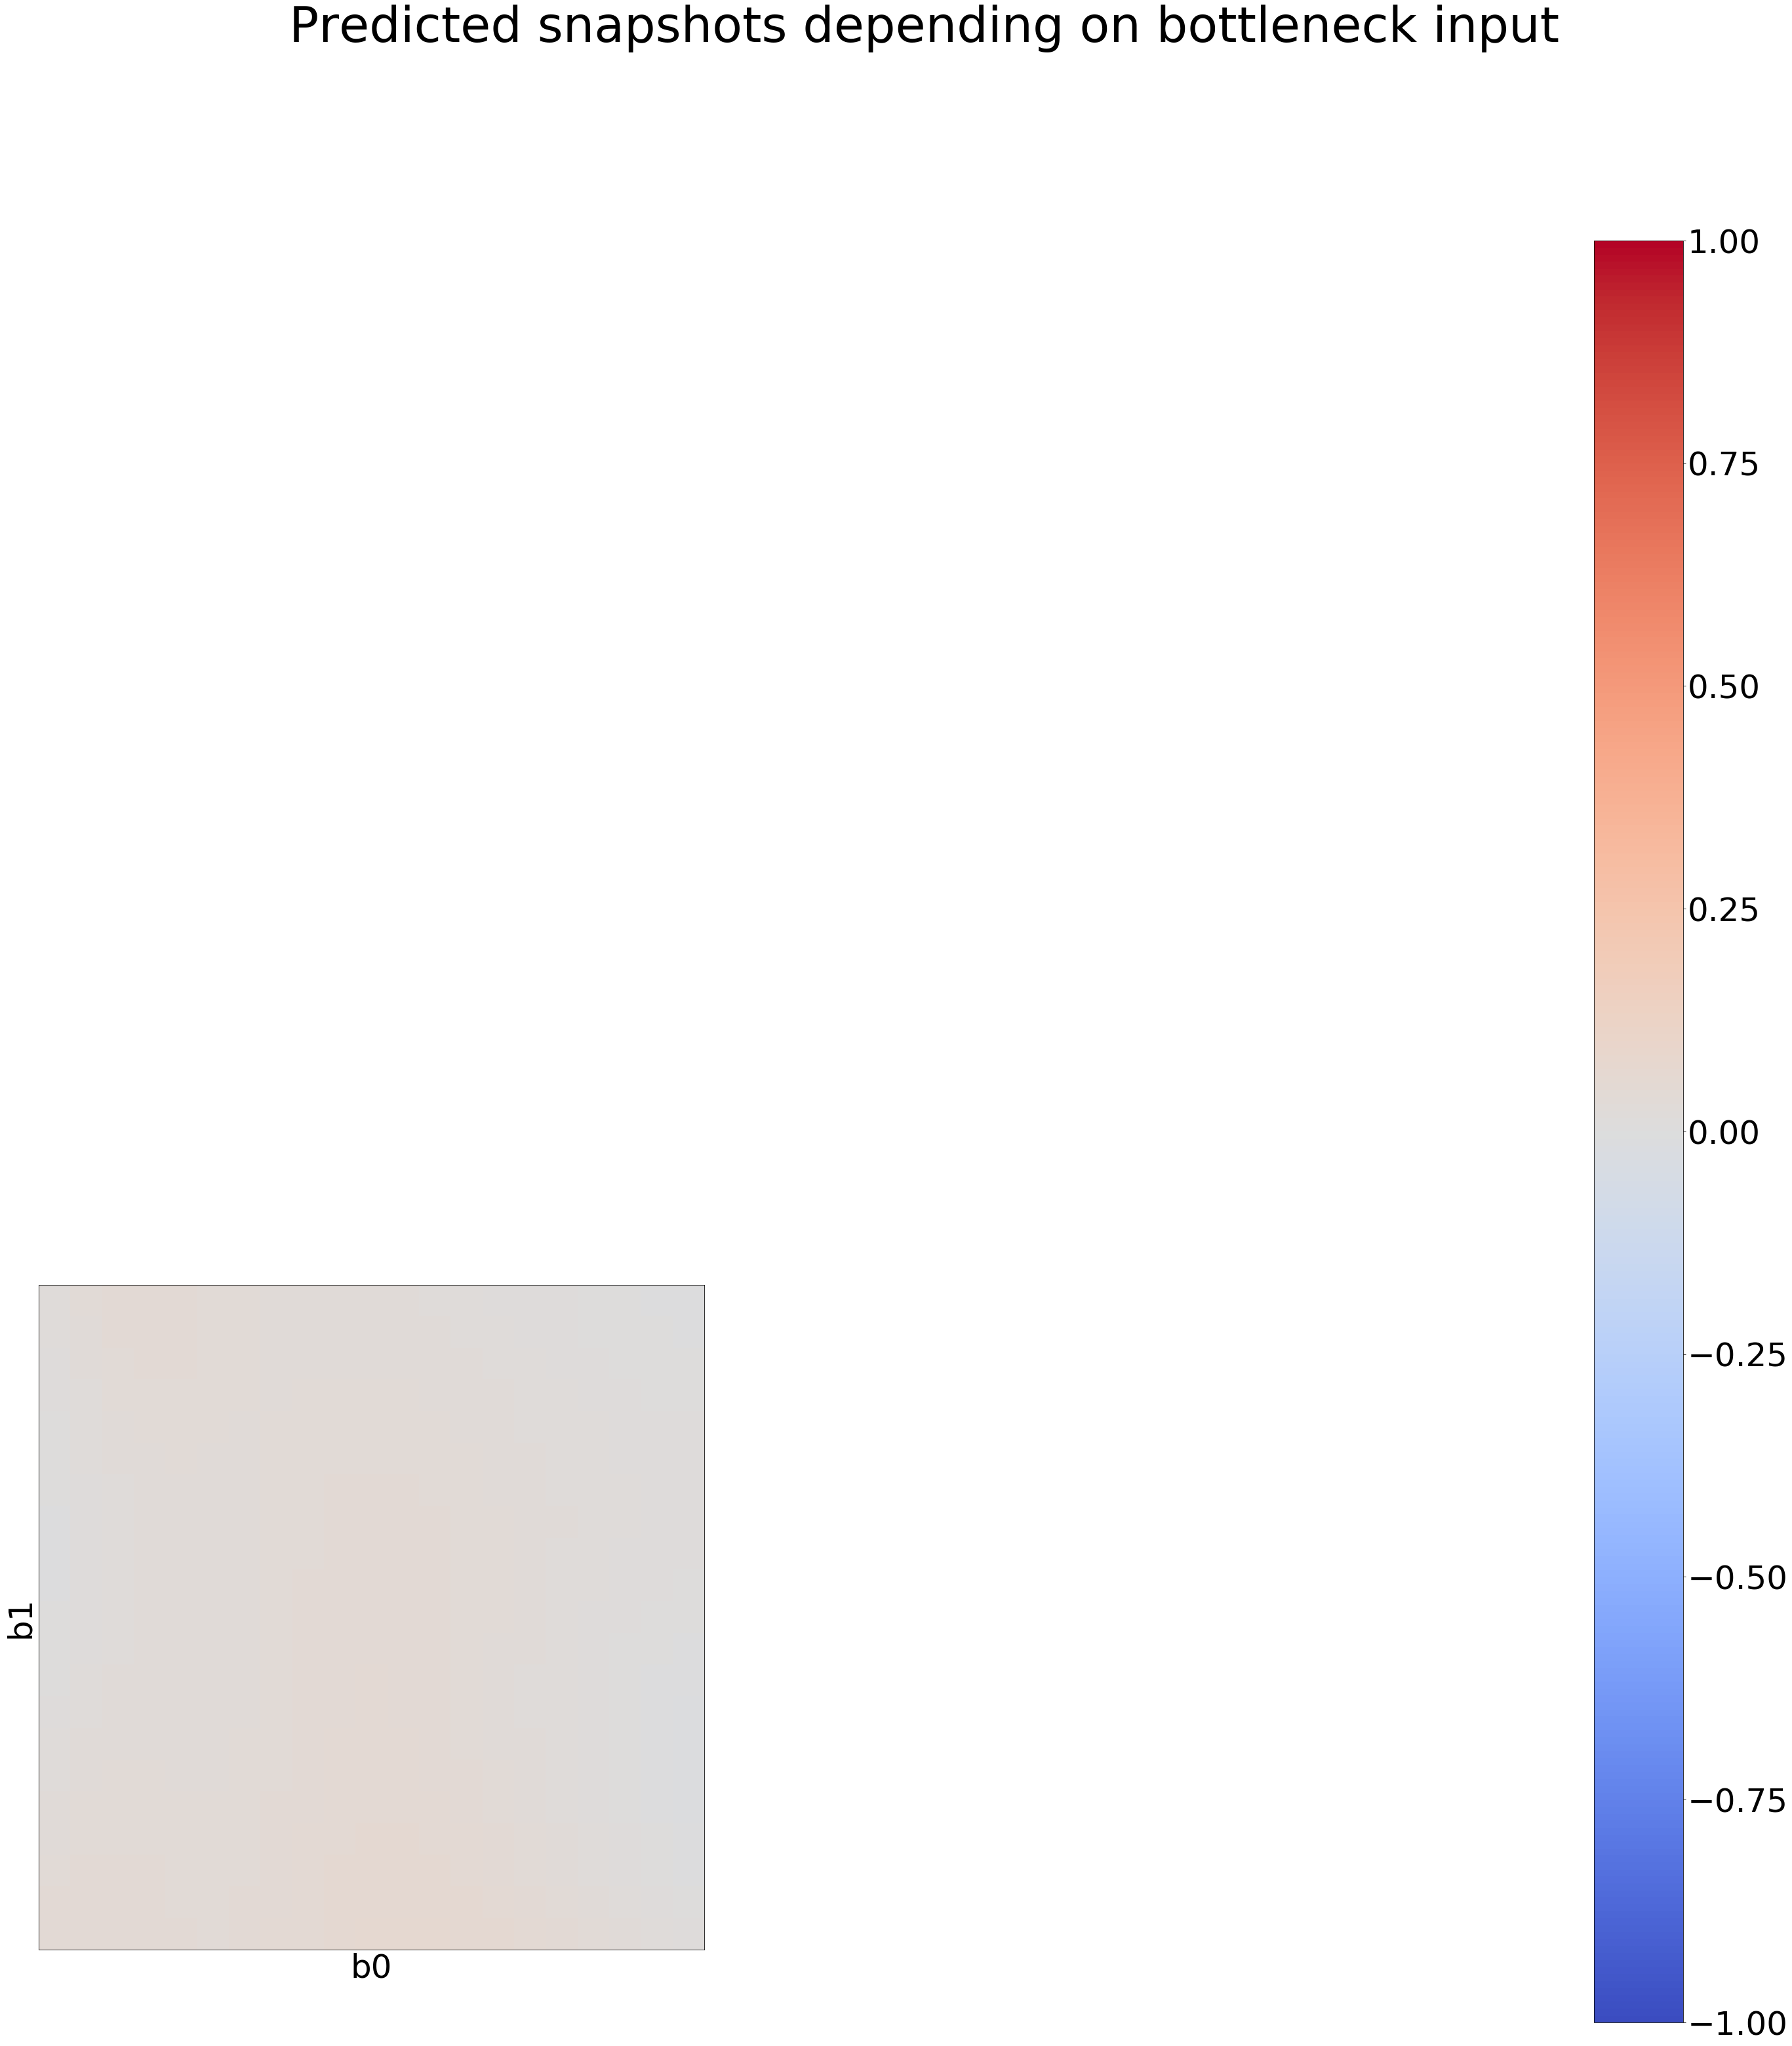

6


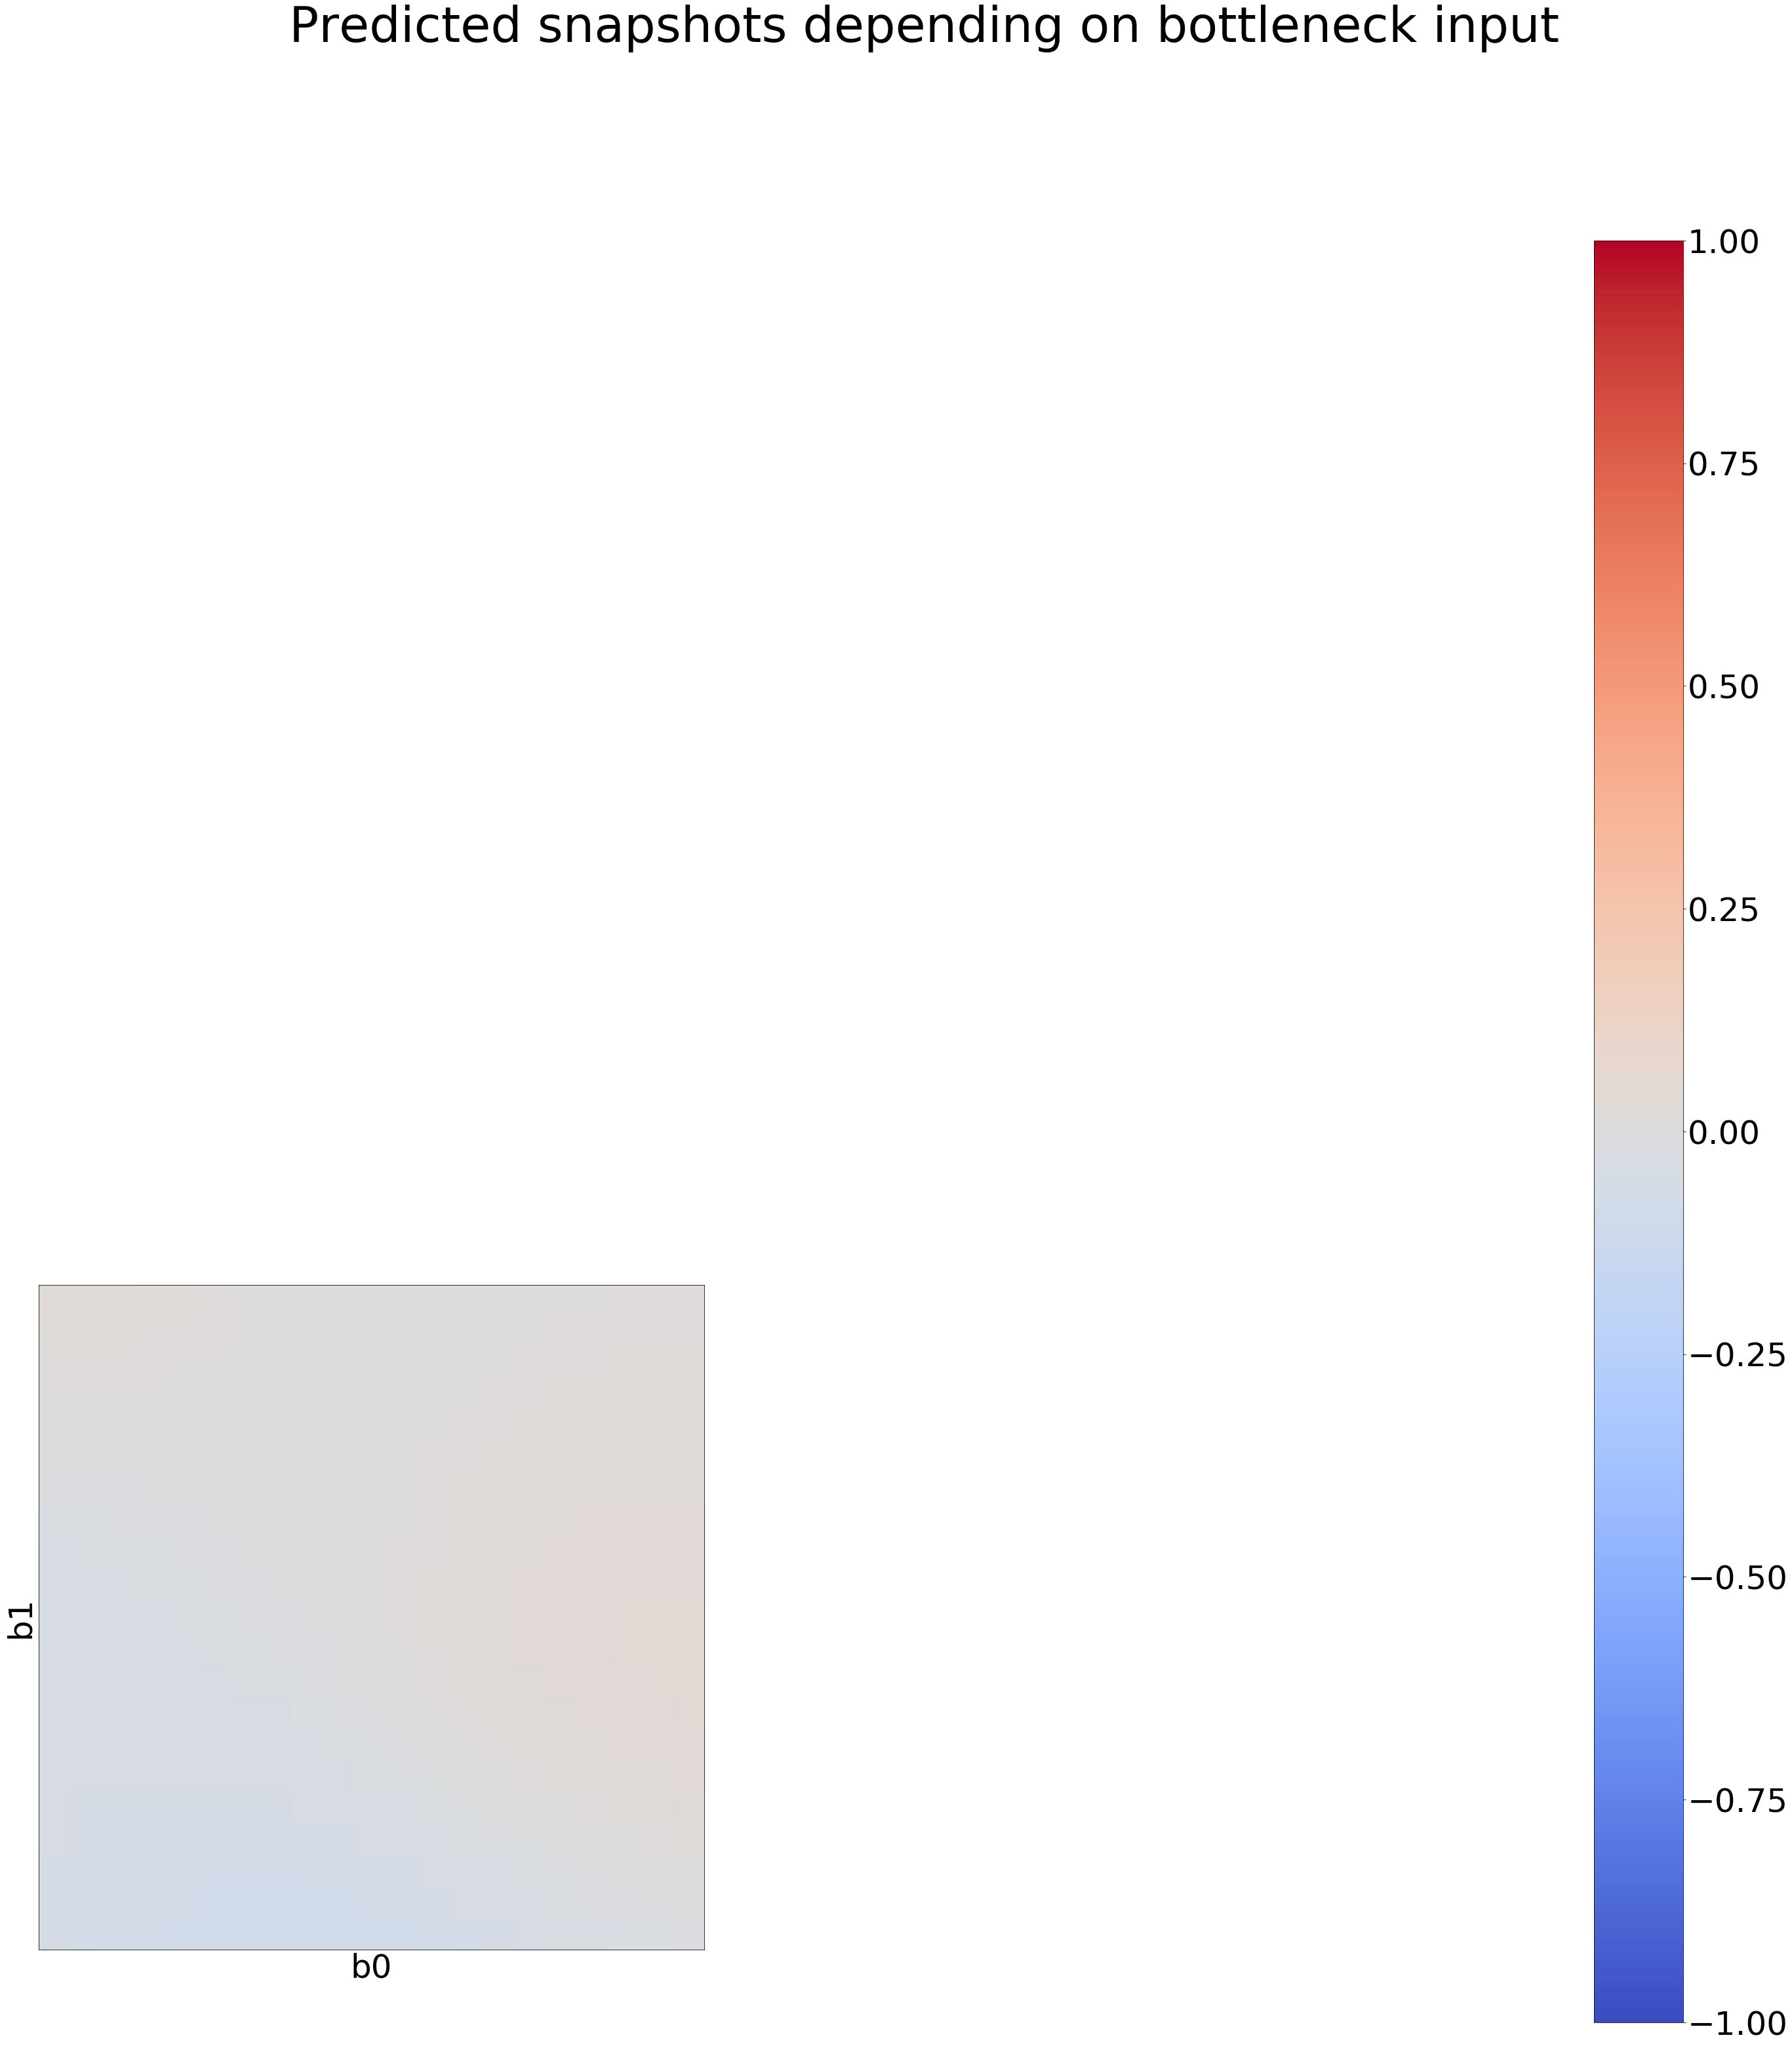

7


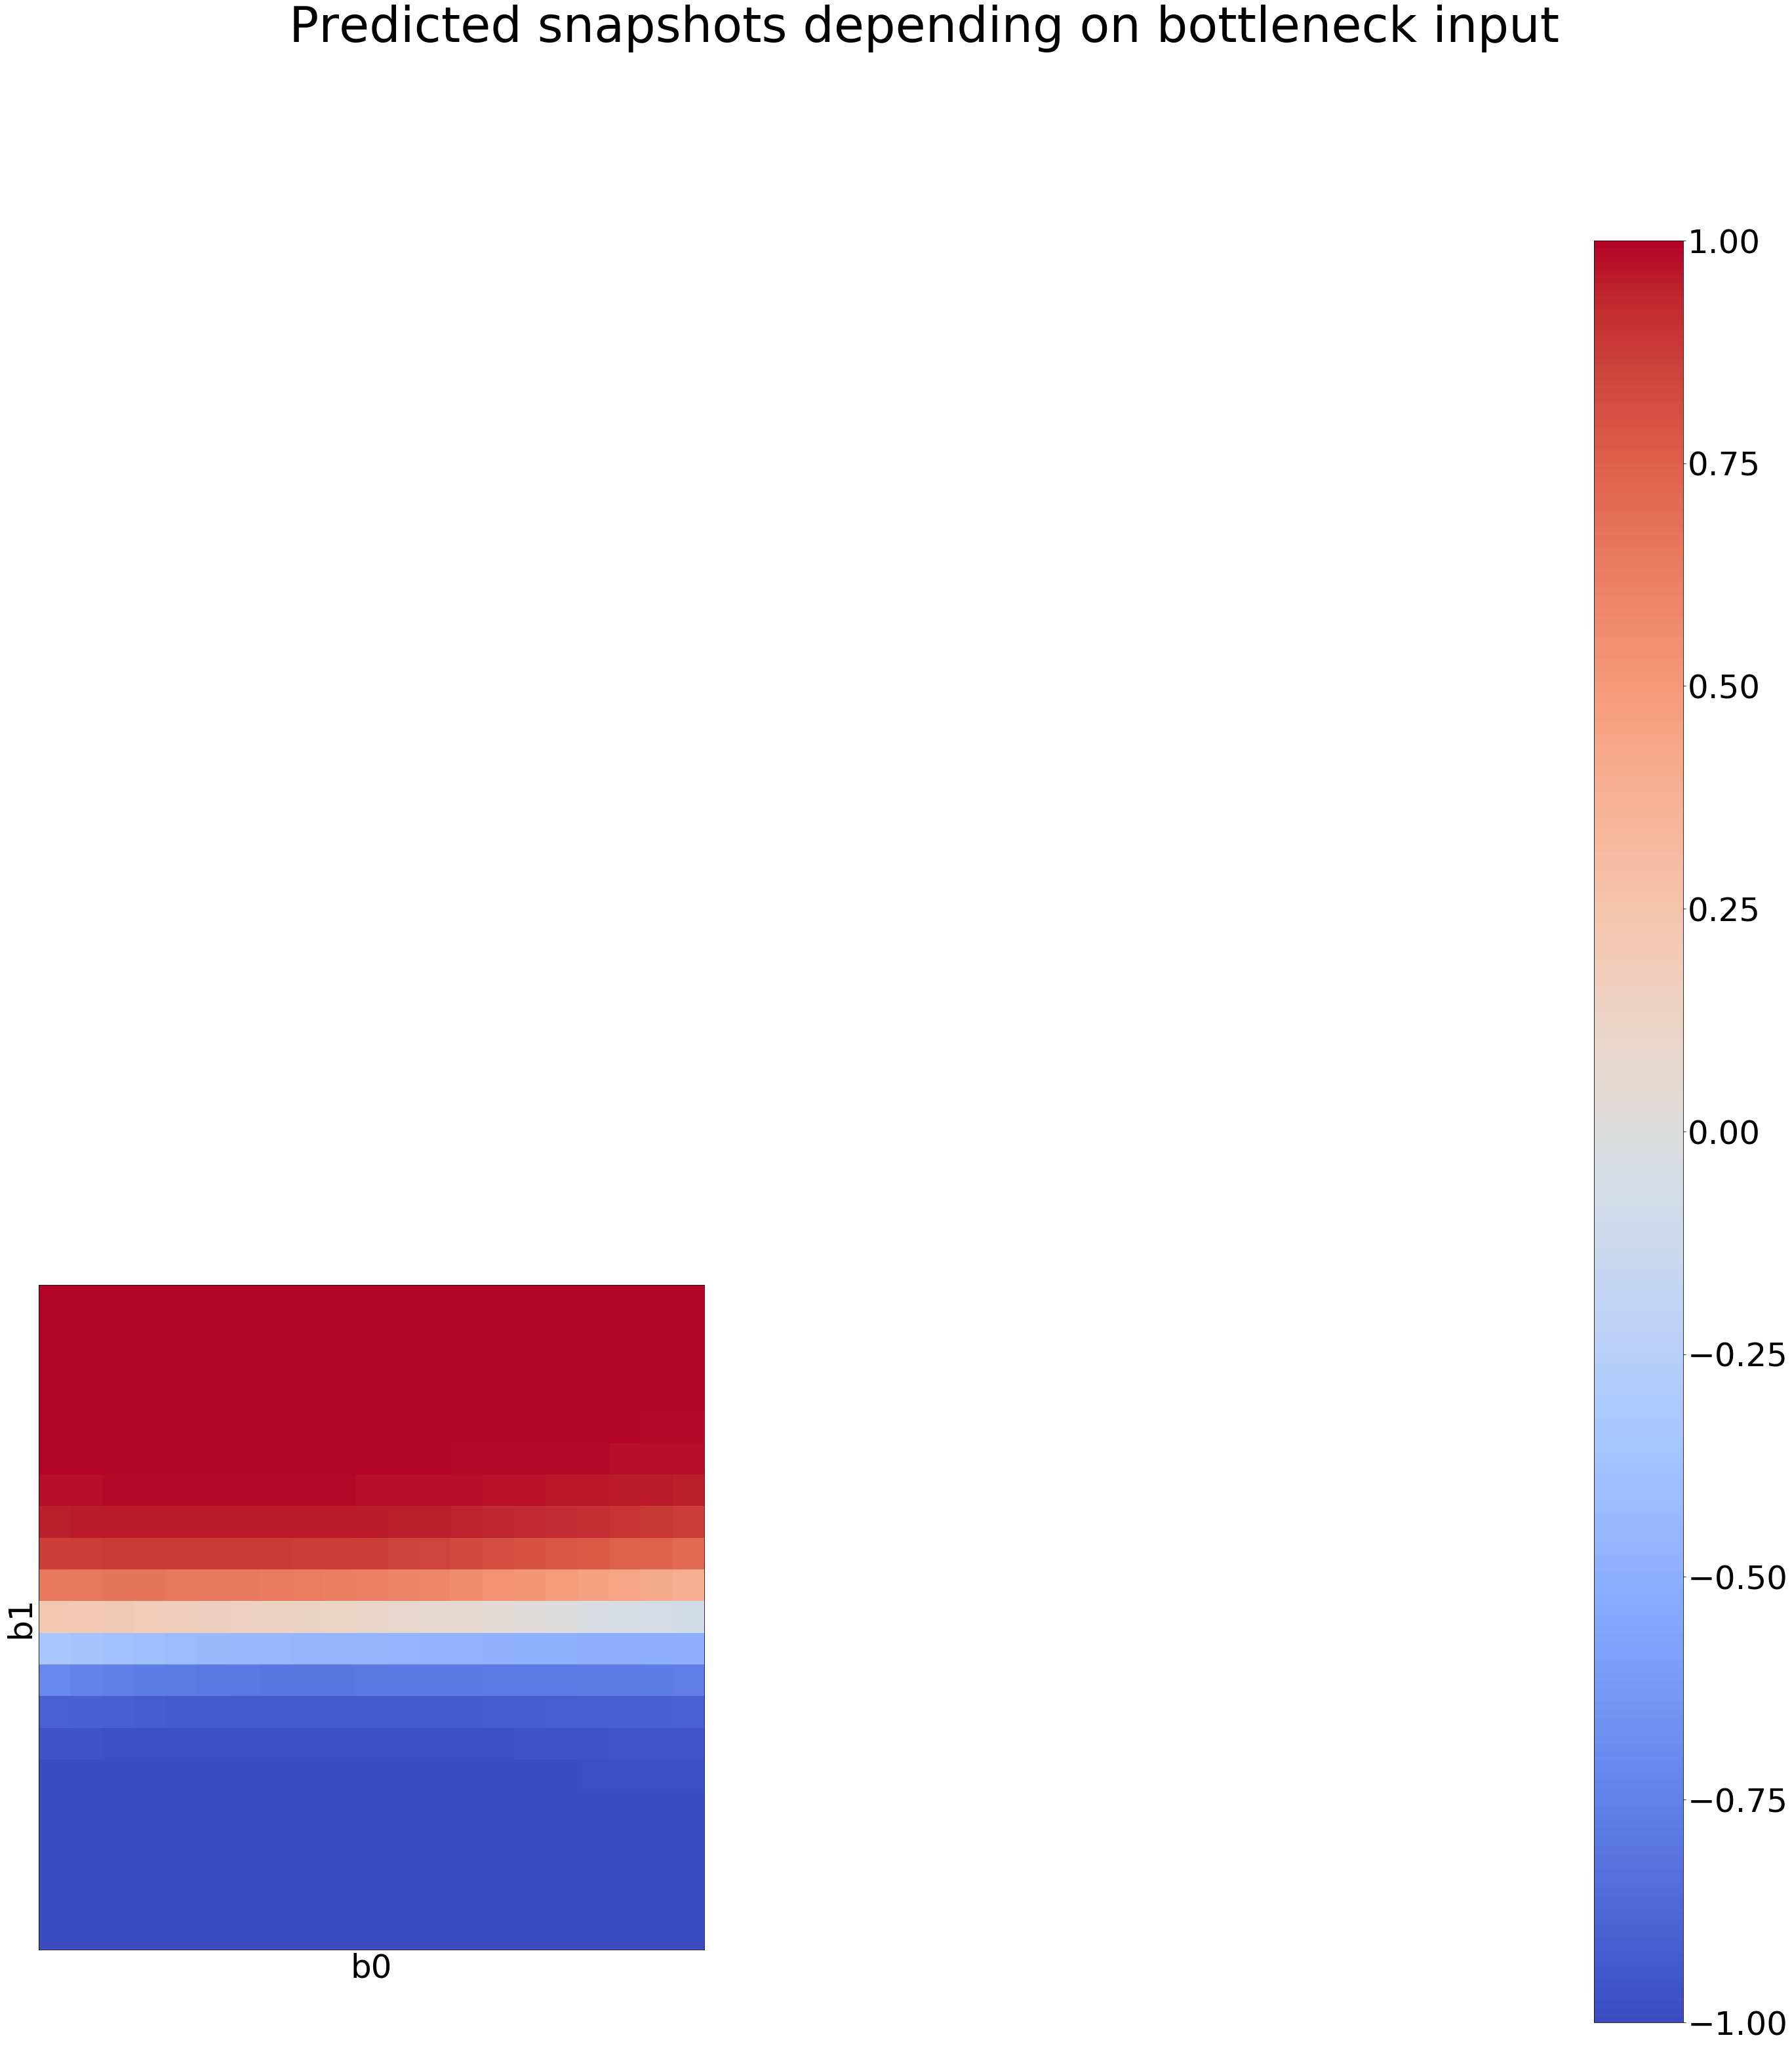

8


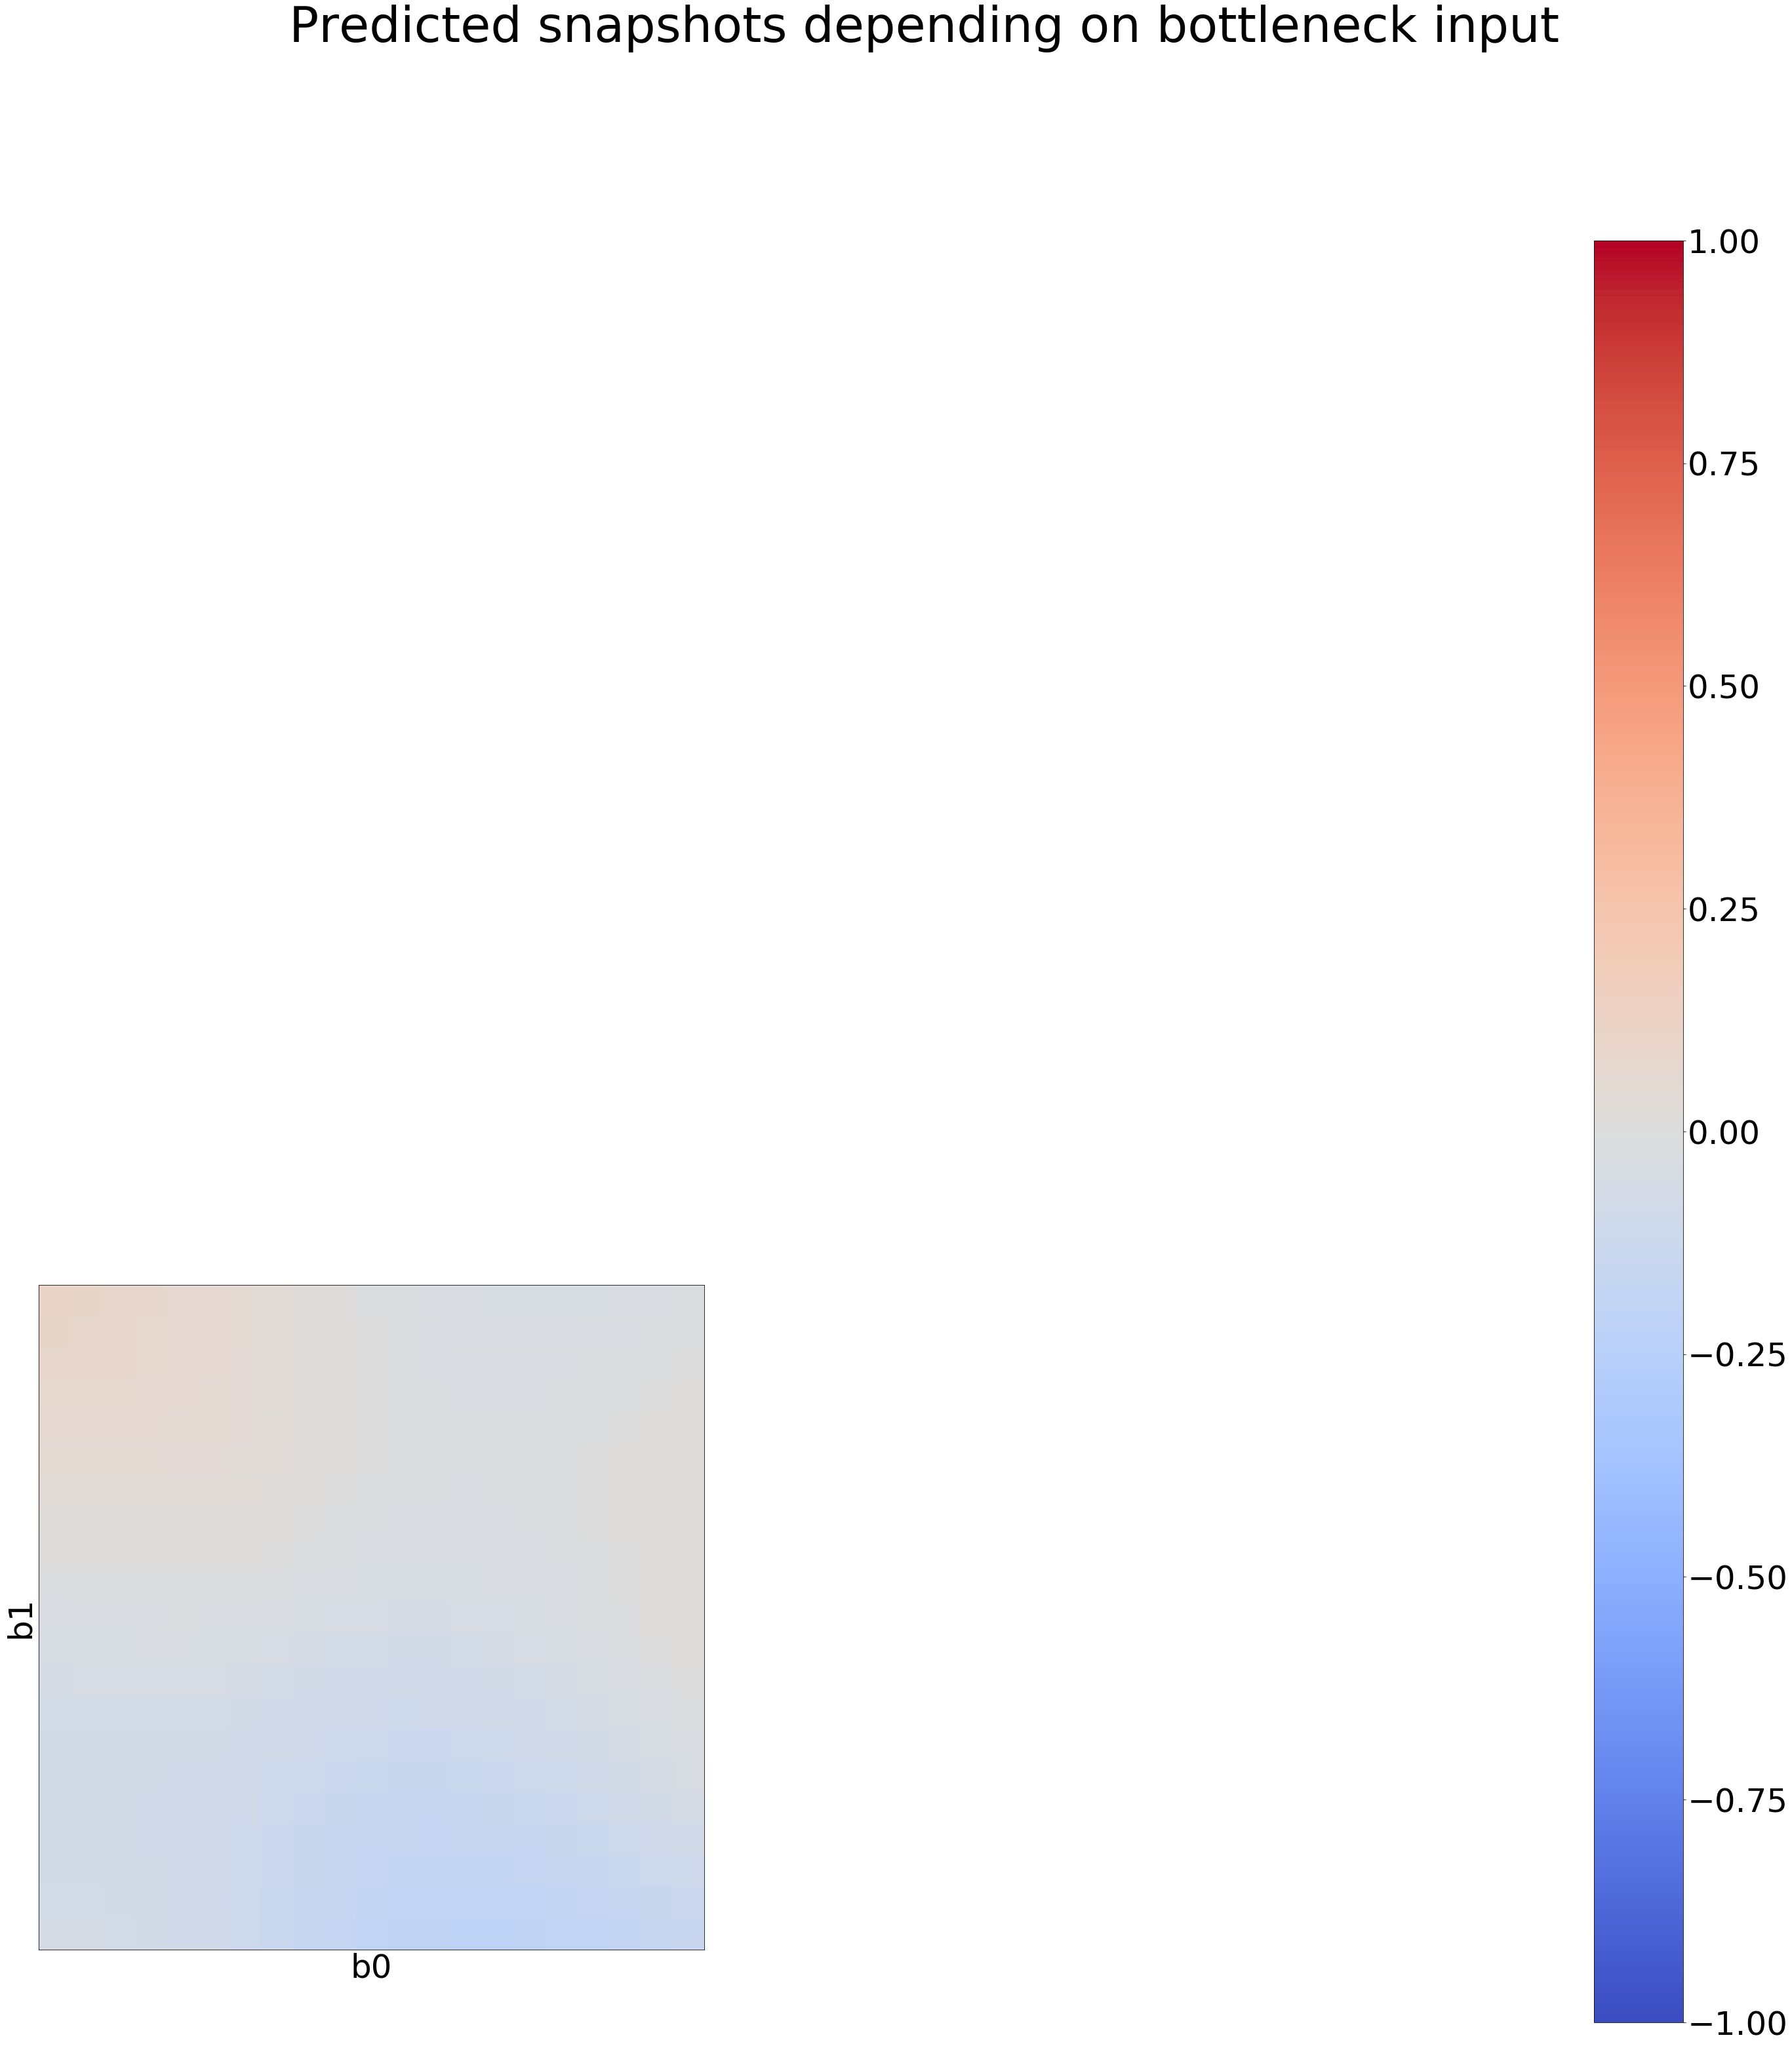

9


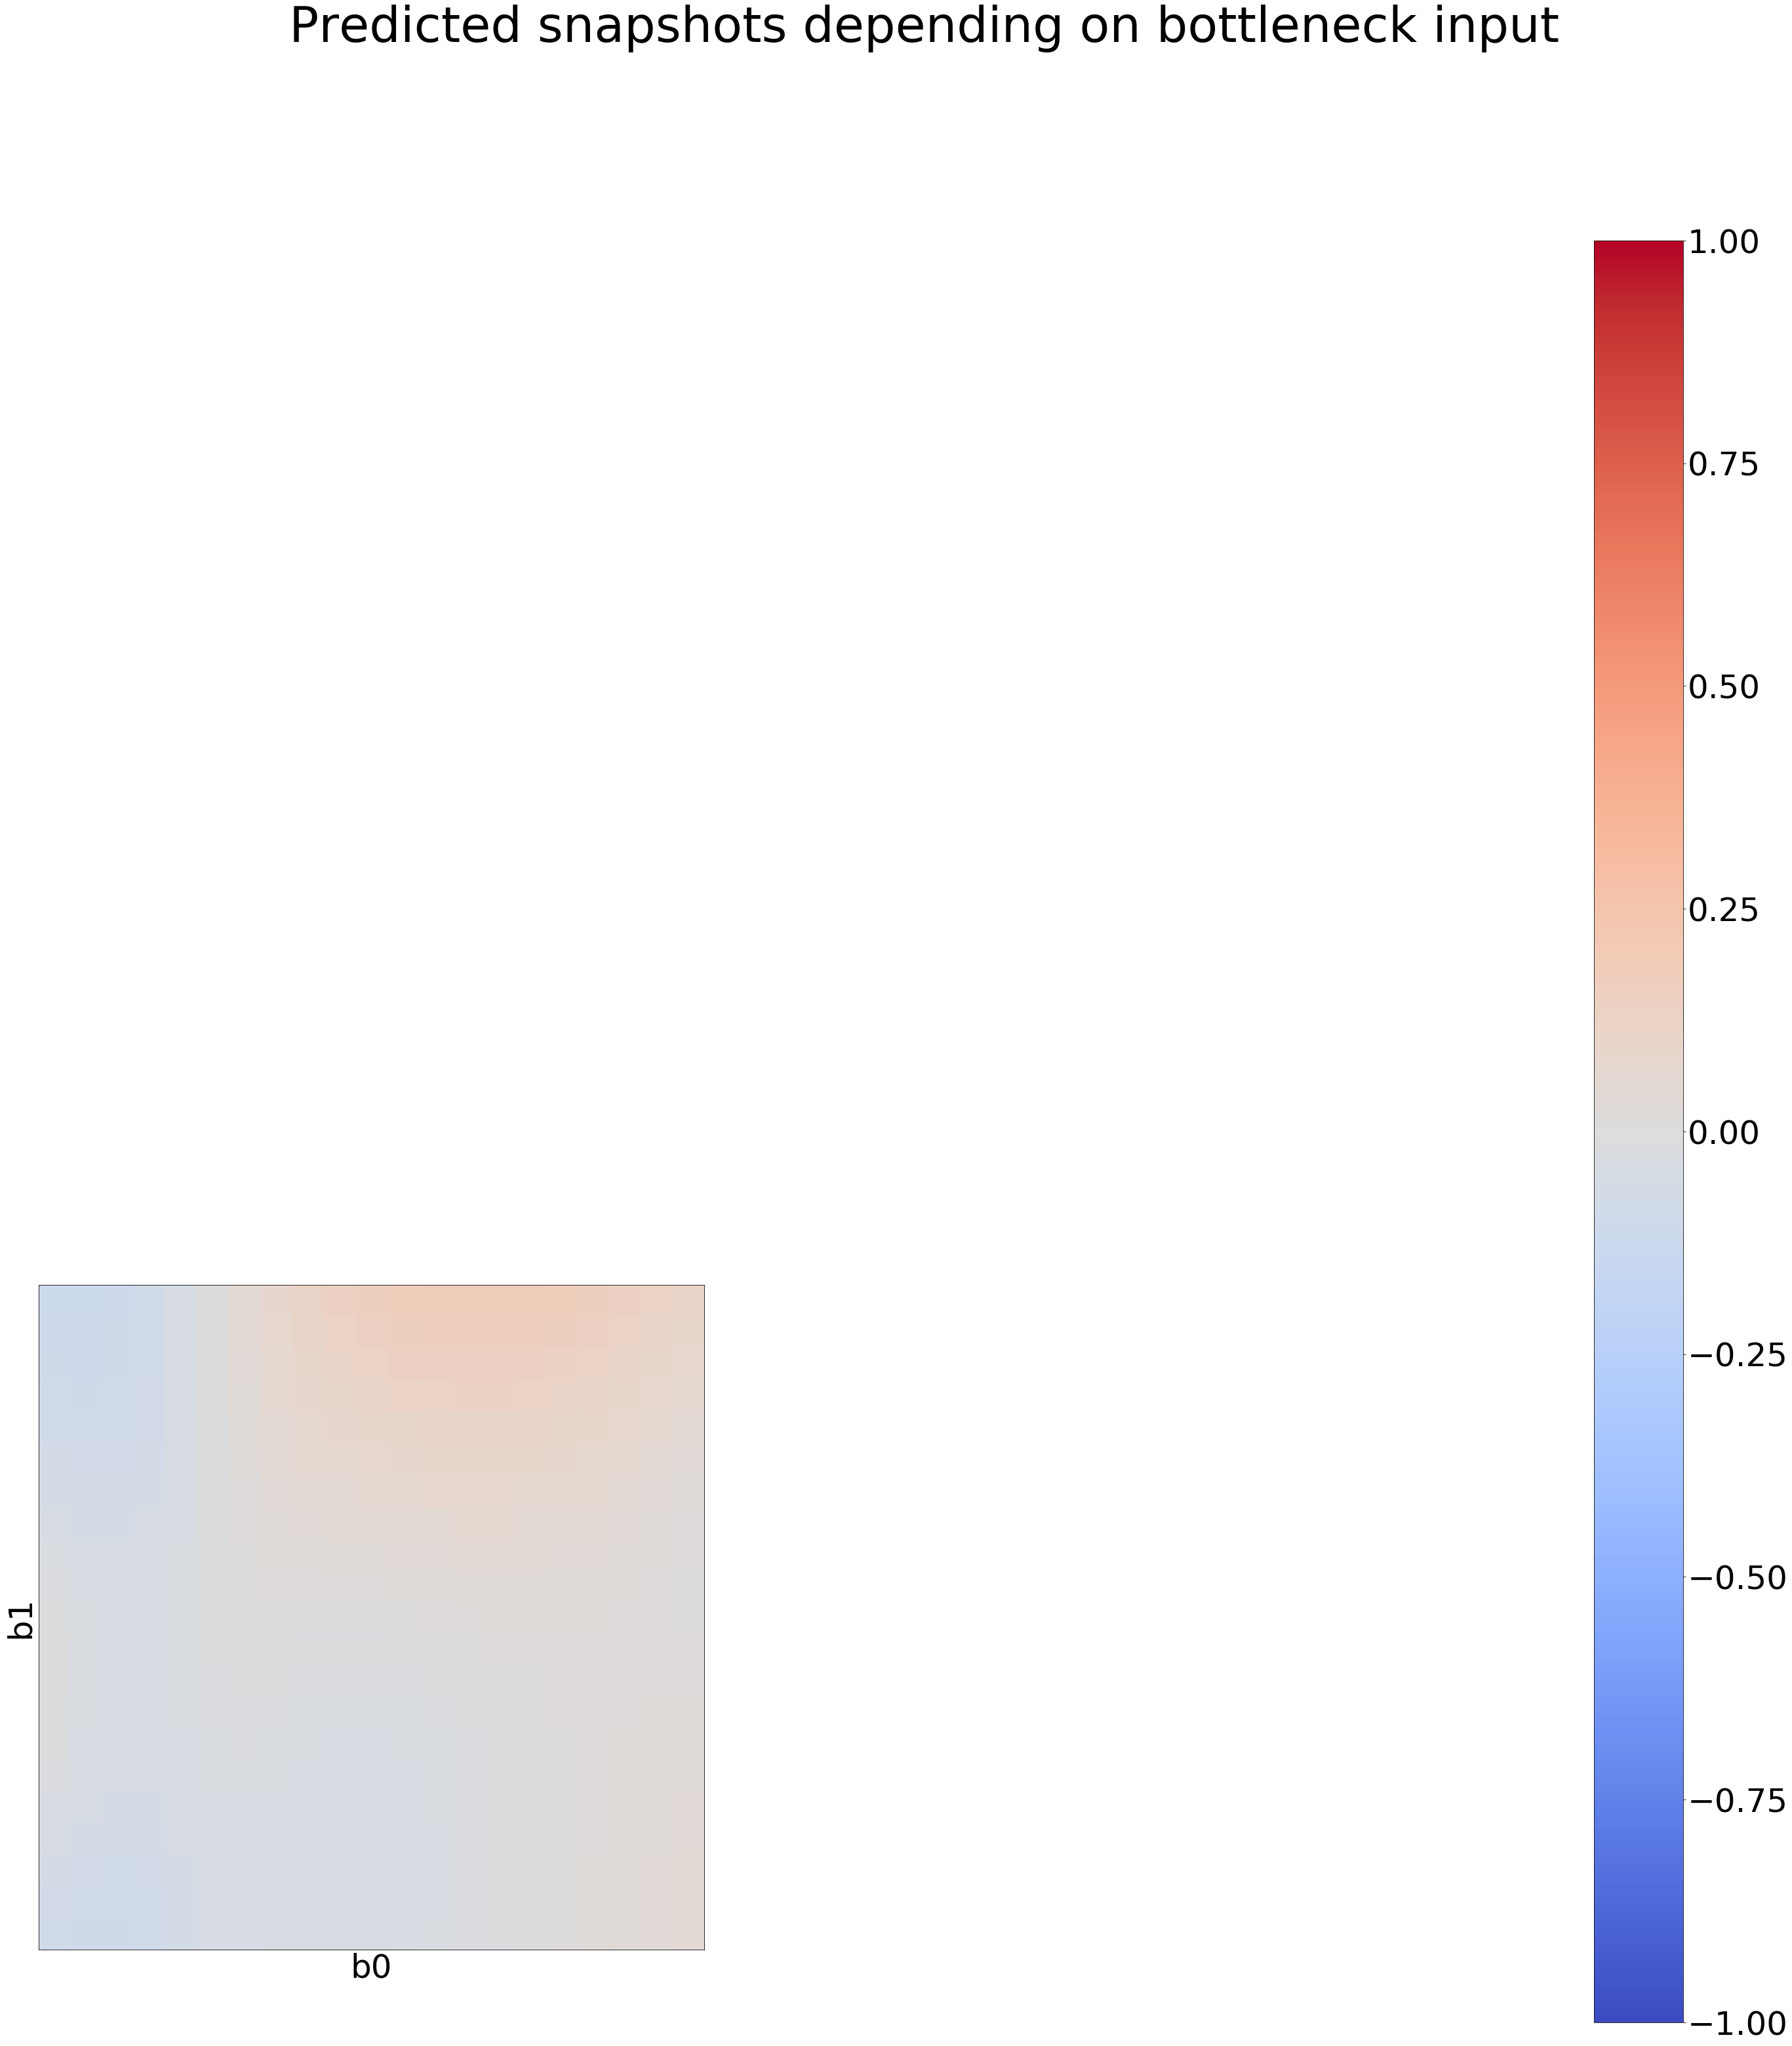

In [71]:
def make_label_map_figure(mode, mode_var, resolution, i_range, j_range, vmin, vmax):
    if mode == "generated":
        model = mode_var[0]
        additional_dim_value = mode_var[1]
        if model == encoder:
            input_type = "snapshot"
            output_type = "bn"
            suptitle = "Predicted bottlenecks depending on snapshot input"
            model_name = "encoder"
        elif model == decoder_1:
            input_type = "bn"
            output_type = "label"
            suptitle = "Predicted labels on bottleneck input"
            model_name = "decoder_1"
        elif model == decoder_2:
            input_type = "bn"
            output_type = "snapshot"
            suptitle = "Predicted snapshots depending on bottleneck input"
            model_name = "decoder_2"
        elif model == autoencoder_1:
            input_type = "snapshot"
            output_type = "label"
            suptitle = "Predicted labels depending on snapshot input"
            model_name = "autoencoder_1"
        elif model == autoencoder_2:
            input_type = "snapshot"
            output_type = "snapshot"
            suptitle = "Predicted snapshots depending on snapshot input"
            model_name = "autoencoder_2"
    elif mode == "given":
        snapshot_list = mode_var[0]
        snapshot_label_list = mode_var[1]
        model_name = "given"

    meta_label_map = []            
    for i in range(i_range):
        meta_label_map.append([])   
        for j in range(j_range):
            meta_label_map[i].append([])
            if j > i:
                print(i, j)
                if mode == "generated":
                    label_map = map_generated(model, input_type, output_type, \
                        np.linspace(lower_bound[i], upper_bound[i], resolution), \
                        np.linspace(lower_bound[j], upper_bound[j], resolution), \
                        additional_dim_value, i, j)
                elif mode == "given":
                    label_map = map_given_labels(snapshot_list, \
                        snapshot_label_list, \
                        np.linspace(lower_bound[i], upper_bound[i], resolution), \
                        np.linspace(lower_bound[j], upper_bound[j], resolution), \
                        i, j)
                    suptitle = "Given labels depending on snapshot input"
                meta_label_map[i][j].append(label_map)
    # gets output len by simply taking the length of the last generated label_map
    for k in range(len(label_map)):
        print(k)
        fig, axs = plt.subplots(i_range, j_range, figsize=(FIG_SIZE,FIG_SIZE))
        fig.suptitle(suptitle, fontsize=FIG_SIZE*1.5)                
        for i in range(i_range):
            for j in range(j_range):
                axs[i][j].tick_params(
                    axis='both',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    left = False,
                    labelleft= False)  
        for i in range(i_range):  
            for j in range(j_range):
                if j > i:
                    im = axs[j][i].imshow(np.transpose(meta_label_map[i][j][0][k])[::-1], cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
                    if mode == "given":
                        if j == j_range - 1:
                            axs[j][i].set_xlabel("x{}".format(i),fontsize=FIG_SIZE)
                        if i == 0:
                            axs[j][i].set_ylabel("x{}".format(j),fontsize=FIG_SIZE)
                    else:
                        if input_type == "snapshot":
                            if j == j_range - 1:
                                axs[j][i].set_xlabel("x{}".format(i),fontsize=FIG_SIZE)
                            if i == 0:
                                axs[j][i].set_ylabel("x{}".format(j),fontsize=FIG_SIZE)
                        elif input_type == "bn":
                            if j == j_range - 1:
                                axs[j][i].set_xlabel("b{}".format(i),fontsize=FIG_SIZE)
                            if i == 0:
                                axs[j][i].set_ylabel("b{}".format(j),fontsize=FIG_SIZE)
                else:
                    axs[j][i].axis("off")
        cax,kw = mpl.colorbar.make_axes([ax for ax in axs])
        cbar = plt.colorbar(im, cax=cax, **kw)
        cbar.ax.tick_params(labelsize=FIG_SIZE)
        plt.savefig("Map_{}_res_{}_output_node_{}.png".format(model_name, resolution, k)) 
        plt.show()
    return meta_label_map

meta_label_map_1 = make_label_map_figure(mode = "given", mode_var = [test_snapshot_list, test_snapshot_label_list], \
        resolution = RESOLUTION, i_range = DIMENSIONS, j_range = DIMENSIONS, \
        vmin = 0, vmax = 1)

meta_label_map_2 = make_label_map_figure(mode = "generated", mode_var = [autoencoder_1, 0], \
        resolution = RESOLUTION, i_range = DIMENSIONS, j_range = DIMENSIONS, \
        vmin = 0, vmax = 1)

meta_label_map_3 = make_label_map_figure(mode = "generated", mode_var = [autoencoder_2, 0], \
        resolution = RESOLUTION, i_range = DIMENSIONS, j_range = DIMENSIONS, \
        vmin = -1, vmax = 1)

meta_label_map_4 = make_label_map_figure(mode = "generated", mode_var = [encoder, 0], \
        resolution = RESOLUTION, i_range = DIMENSIONS, j_range = DIMENSIONS, \
        vmin = -1, vmax = 1)

meta_label_map_5 = make_label_map_figure(mode = "generated", mode_var = [decoder_1, 0], \
        resolution = RESOLUTION, i_range = BOTTLENECK_SIZE, j_range = BOTTLENECK_SIZE, \
        vmin = 0, vmax = 1)

meta_label_map_6 = make_label_map_figure(mode = "generated", mode_var = [decoder_2, 0], \
        resolution = RESOLUTION, i_range = BOTTLENECK_SIZE, j_range = BOTTLENECK_SIZE, \
        vmin = -1, vmax = 1)

In [72]:
def measure_correlation(test_snapshot_list):
    column_list = np.transpose(test_snapshot_list)
    covariance_matrix = np.cov(column_list)
    strong_correlated_input_list = []
    weak_correlated_input_list = []
    for row_nr in range(len(covariance_matrix)):
        for entry_nr in range(len(covariance_matrix[row_nr])):
            if row_nr > entry_nr:
                if abs(covariance_matrix[row_nr][entry_nr]) >= STRONG_CORRELATION_TRESHOLD:
                    strong_correlated_input_list.append([[str(row_nr), str(entry_nr)], "{:.3f}".format(covariance_matrix[row_nr][entry_nr])])
                elif abs(covariance_matrix[row_nr][entry_nr]) >= WEAK_CORRELATION_TRESHOLD:
                    weak_correlated_input_list.append([[str(row_nr), str(entry_nr)], "{:.3f}".format(covariance_matrix[row_nr][entry_nr])])
    if len(strong_correlated_input_list) > 0 or len(weak_correlated_input_list) > 0:
        print("Caution!\n\
Correlation between input data can affect the reliability of the importance measure.\n\
Strong correlations of more than {} were found between {} pairs of input variables:\n\t"\
.format(STRONG_CORRELATION_TRESHOLD, len(strong_correlated_input_list)) + "\n\t".join([": ".join([",".\
join(subentry) if isinstance(subentry, list) else subentry for subentry in entry]) for entry \
in strong_correlated_input_list])+ "\nAdditionally, weak correlations of more than {} were \
found between {} pairs of input variables:\n\t".format(WEAK_CORRELATION_TRESHOLD, \
len(weak_correlated_input_list)) + "\n\t".join([": ".join([",".join(subentry) if isinstance(subentry, list) \
else subentry for subentry in entry]) for entry in weak_correlated_input_list]))
    else:
        print("No correlation above {} found between the inputs.".format(WEAK_CORRELATION_TRESHOLD))
    return strong_correlated_input_list, weak_correlated_input_list

In [73]:
# if DROP_REMAINDER = True, TEST_SIZE will not fit the size of the snapshot_list anymore
# either remove the update of TEST_SIZE, adapt test_snapshot_list, or replace TEST_SIZE with a different value

def perturb_snapshot_list(column_list, mod_along, perturbation):
    transposed_list = deepcopy(column_list)
    rand_array = np.random.uniform(1 - perturbation, 1 + perturbation, TEST_SIZE)
    transposed_list[mod_along] = column_list[mod_along] * rand_array
    return np.transpose(transposed_list)

def set_mean_snapshot_list(column_list, mod_along, column_mean):
    transposed_list = deepcopy(column_list)
    transposed_list[mod_along] = column_mean
    return np.transpose(transposed_list)

def HIPR_snapshot_list(column_list, mod_along, min_value, max_value):
    transposed_list = deepcopy(column_list)
    rand_array = np.random.uniform(min_value, max_value, TEST_SIZE)
    transposed_list[mod_along] = rand_array
    return np.transpose(transposed_list)

def shuffle_snapshot_list(column_list, mod_along):
    # since independent runs should use different shuffled lists, nothing is passed down
    transposed_list = deepcopy(column_list)
    transposed_list[mod_along] = shuffle(transposed_list[mod_along])
    return np.transpose(transposed_list)


In [74]:
def input_importance(mode, mode_var, model, test_ds, test_snapshot_list, test_snapshot_label_list, \
                     test_2_snapshot_list, check_vars, repetitions):
    orig_t_loss, orig_l_loss, orig_r_loss = model.evaluate(test_ds, verbose=0, steps = STEP_NUMBER)
    meta_loss_list = []
    test_column_list = np.transpose(test_snapshot_list)
    # initialization dependent on the mode
    if mode == "Perturb":
        perturbation = mode_var
    elif mode == "Mean":
        if repetitions > 1:
            print("The mean mode does not entail stocisticity. \nNumber of repetitions was set to '1' for this measurement.")
            repetitions = 1
        mean_value_array = np.mean(test_snapshot_list, axis = 0)
    elif mode == "HIPR":
        min_value = mode_var[0]
        max_value = mode_var[1]
    elif mode == "Shuffle":
        pass
        
    print("Mode: {}".format(mode))
    for repetition in range(repetitions):
        print("Repetition {}.".format(repetition+1))
        loss_list = [[],[],[]]
        for variable_nr in check_vars:
            print("\tPerturbing variable {}.".format(variable_nr))
            # generating modified snapshot_lists
            if mode == "Perturb":
                mod_test_snapshot_list = perturb_snapshot_list(test_column_list, variable_nr, perturbation)
            elif mode == "Mean":
                mod_test_snapshot_list = set_mean_snapshot_list(test_column_list, variable_nr, mean_value_array[variable_nr])
            elif mode == "HIPR":
                mod_test_snapshot_list = HIPR_snapshot_list(test_column_list, variable_nr, min_value, max_value)
            elif mode == "Shuffle":
                mod_test_snapshot_list = shuffle_snapshot_list(test_column_list, variable_nr)
                
            mod_test_ds = tf.data.Dataset.from_tensor_slices(({INPUT_NAME: mod_test_snapshot_list},
                    {OUTPUT_NAME_1: test_snapshot_label_list, 
                OUTPUT_NAME_2: test_2_snapshot_list})).shuffle(DATASET_SIZE).batch(BATCH_SIZE, drop_remainder=DROP_REMAINDER)
            # calculate the different losses with the new dataset
            t_loss, l_loss, r_loss = model.evaluate(mod_test_ds, verbose=0, steps = STEP_NUMBER)
            # append the losses to a collective list for later comparison
            loss_list[0].append(max(0,t_loss-orig_t_loss))
            loss_list[1].append(max(0,l_loss-orig_l_loss))
            loss_list[2].append(max(0,r_loss-orig_r_loss))
        # average over the loss lists
        # negative increases of loss are set to zero
        for row_nr in range(len(loss_list)):
            full_loss = sum(loss_list[row_nr])
            for col_nr in range(len(loss_list[row_nr])):
                if full_loss > 0:
                    loss_list[row_nr][col_nr] = loss_list[row_nr][col_nr]/full_loss
                else:
                    loss_list[row_nr][col_nr] = 0
        meta_loss_list.append(np.array(loss_list))
    
    total_normalized_losses = np.transpose([sum(np.transpose(sum(meta_loss_list)))])
    # sets value to 1 if all the losses add up to 0 and would cause a divide by zero error
    total_normalized_losses = np.array([value[0] if value != 0 else 1 for value in total_normalized_losses])
    #print(np.array(sum(meta_loss_list)/repetitions))
    return sum(meta_loss_list)/np.transpose([total_normalized_losses])
    
#perturbed_loss_list= input_importance("Perturb", 0.5, autoencoder, test_norm_ds_batch, test_snapshot_list, \
#        test_snapshot_label_list, test_snapshot_list, range(3), 1)
#plot_input_importance(perturbed_loss_list,1,"Perturb_0.5")
#mean_loss_list = input_importance("Mean", None, autoencoder, test_norm_ds_batch, test_snapshot_list, \
#        test_snapshot_label_list, test_snapshot_list, range(3), 1)
#plot_input_importance(mean_loss_list,1,"Mean")
#hipr_loss_list = input_importance("HIPR", [-0.9,0.9], autoencoder, test_norm_ds_batch, test_snapshot_list, \
#        test_snapshot_label_list, test_snapshot_list, range(3), 1)
#plot_input_importance(hipr_loss_list,1,"HIPR_range[-0.9,0.9]")
#shuffle_loss_list = input_importance("Shuffle", None, autoencoder, test_norm_ds_batch, test_snapshot_list, \
#        test_snapshot_label_list, test_snapshot_list, range(3), 1)
#plot_input_importance(shuffle_loss_list,1,"Shuffle")




In [ ]:
def plot_all_input_importance(model, mode_list, test_ds, test_snapshot_list, \
        test_snapshot_label_list, test_2_snapshot_list, variable_list, repetitions):
    if model == encoder:
        model_name = "encoder"
    elif model == decoder_1:
        model_name = "decoder_1"
    elif model == decoder_2:
        model_name = "decoder_2"
    elif model == autoencoder_1:
        model_name = "autoencoder_1"
    elif model == autoencoder_2:
        model_name = "autoencoder_2"
    elif model == autoencoder:
        model_name = "autoencoder"

    
    fig, axs = plt.subplots(LOSS_TYPE_COUNT, len(mode_list), figsize=(FIG_SIZE,FIG_SIZE/len(mode_list)*LOSS_TYPE_COUNT))
    fig.suptitle("Input importance measures", fontsize=FIG_SIZE*1.1, y=0.95)
    for instance_nr in range(len(mode_list)):
        loss_list = input_importance(mode_list[instance_nr][0], mode_list[instance_nr][1], model, test_ds, test_snapshot_list, \
                test_snapshot_label_list, test_2_snapshot_list, variable_list, repetitions)
        for loss_type in range(LOSS_TYPE_COUNT):
            axs[loss_type][instance_nr].bar(range(len(variable_list)), loss_list[loss_type])
            if loss_type == 0:
                axs[loss_type][instance_nr].set_title(mode_list[instance_nr][0], fontsize = FIG_SIZE)
            if instance_nr == 0:
                axs[loss_type][instance_nr].set_ylabel("{}".format(LOSS_NAMES[loss_type]),fontsize=FIG_SIZE)
            axs[loss_type][instance_nr].tick_params(
                        axis='both',
                        which='major',
                        labelsize = FIG_SIZE*0.9)
    plt.setp(axs, xticks=range(len(variable_list)), xticklabels=variable_list, yticks=[0,1], yticklabels=[0,1])
    plt.savefig("Importance_measure_{}_repetitions_{}.png".format(model_name, repetitions)) 
    plt.show()
    

strong_correlated_input_list, weak_correlated_input_list = measure_correlation(test_snapshot_list)

mode_list = [["Perturb", 0.5],["Mean", None],["HIPR", [-0.9,0.9]],["Shuffle", None]]

if OFFSET == 0:
    plot_all_input_importance(autoencoder, mode_list, test_ds_batch, test_snapshot_list, \
            test_snapshot_label_list, test_snapshot_list, range(10), 10)
else:
    plot_all_input_importance(autoencoder, mode_list, test_ds_batch, test_snapshot_list, \
            test_snapshot_label_list, test_future_snapshot_list, range(10), 10)


Caution!
Correlation between input data can affect the reliability of the importance measure.
Strong correlations of more than 0.1 were found between 1 pairs of input variables:
	1,0: 0.260
Additionally, weak correlations of more than 0.01 were found between 0 pairs of input variables:
	
Mode: Perturb
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Perturbing variable 6.


In [46]:
# accessing the output of all layers
features_list = [layer.output for layer in encoder.layers]
feat_extraction_model = keras.Model(inputs=encoder.input, outputs=features_list[-1])
img = np.random.random((1,10)).astype('float32')
print(encoder(img).numpy())
extracted_features = feat_extraction_model(img)
print(extracted_features.numpy())

[[ 0.172 -0.771]]
[[ 0.172 -0.771]]
